In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier, Fourier

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from torch.utils.data import Dataset, Subset


#import ipdb


from torch import nn
from torch.utils.data import DataLoader
import torch

import warnings
warnings.filterwarnings('ignore')

import time


plt.rcParams['figure.figsize'] = (20, 10)

# Import data

In [28]:
flu_id = pd.read_csv("VIW_FID_EPI.csv")
flu_net = pd.read_csv("data/VIW_FNT-1-29-2024.csv")
#flu_net = pd.read_csv("VIW_FNT.csv")

flu_dict = pd.read_csv("VIW_FLU_METADATA.csv")
flu_surv= pd.read_csv("data/FluViewPhase5Data/Weekly_Data_Counts_by_Virus.csv",encoding='cp1252')
#flu_surv_24 = pd.read_excel('data/FluSurveillance_Custom_Download_Data (3).xlsx') # annoying CDC publishes live time data only in this format it appears

## Fix flu surv

In [29]:
def fix_flu_surv(flu_surv):
    columns =["SEASON", "WEEK_NUMBER", "INFLUENZA A", "INFLUENZA B", "INFLUENZA A AND B"]
    data = []
    print(columns)

    for i in range(len(flu_surv)-1):
        data.append(flu_surv.iloc[i+1].name)
    data = np.array(data)
    print(data.shape)
    return pd.DataFrame(data=data,columns = columns)

In [42]:
def pdflusurv_to_weektime(df):
    
    indices_ = list(df.index)
   # indices_.sort()
    df = df.loc[indices_]

    indices_new = []
    for i in range(len(indices_)):
        d =  str(indices_[i])[:5]
        if len(str(indices_[i])[5:]) == 1:
            d+='0'
        d+=str(indices_[i])[5:]
       # d= datetime.datetime.strptime(d + '-1', "%Y-%W-%w")
        indices_new.append(d)
    indices_new
    df.index = indices_new
    return df

In [31]:
flu_surv

Influenza-Associated Hospitalizations by Virus Type Number (data downloaded on 1/29/2024)
SEASON                                             WEEK_NUMBER INFLUENZA A INFLUENZA B INFLUENZA A AND B                                            UNKNOWN                                       
2003-04                                            2003-40     0           0           0                                                                  0                                       
                                                   2003-41     1           0           0                                                                  0                                       
                                                   2003-42     0           0           0                                                                  0                                       
                                                   2003-43     0           0           0                                                                  0                                       
...                                                                                                                                                     ...                                       
2023-24                                            2024-15     0           0           0                                                                  0                                       
                                                   2024-16     0           0           0                                                                  0                                       
                                                   2024-17     0           0           0                                                                  0                                       
1. The Influenza Hospitalization Surveillance N... NaN         NaN         NaN         NaN                                                              NaN                                       
2. In all influenza seasons except 2009-10 and ... NaN         NaN         NaN         NaN                                                              NaN                                       

[645 rows x 1 columns]

In [32]:
flu_surv = fix_flu_surv(flu_surv)
flu_surv = flu_surv.set_index('WEEK_NUMBER')
flu_surv["INFLUENZA A"] = flu_surv["INFLUENZA A"].astype('float32')
flu_surv["INFLUENZA B"] = flu_surv["INFLUENZA B"].astype('float32')
flu_surv = flu_surv.fillna(0.0)
flu_surv

['SEASON', 'WEEK_NUMBER', 'INFLUENZA A', 'INFLUENZA B', 'INFLUENZA A AND B']
(644, 5)


SEASON  INFLUENZA A  \
WEEK_NUMBER                                                                   
2003-40                                                2003-04          0.0   
2003-41                                                2003-04          1.0   
2003-42                                                2003-04          0.0   
2003-43                                                2003-04          0.0   
2003-44                                                2003-04          3.0   
...                                                        ...          ...   
2024-15                                                2023-24          0.0   
2024-16                                                2023-24          0.0   
2024-17                                                2023-24          0.0   
nan          1. The Influenza Hospitalization Surveillance ...          0.0   
nan          2. In all influenza seasons except 2009-10 and...          0.0   

             INFLUENZA B INFLUENZA A AND B  
WEEK_NUMBER                                 
2003-40              0.0                 0  
2003-41              0.0                 0  
2003-42              0.0                 0  
2003-43              0.0                 0  
2003-44              0.0                 0  
...                  ...               ...  
2024-15              0.0                 0  
2024-16              0.0                 0  
2024-17              0.0                 0  
nan                  0.0               nan  
nan                  0.0               nan  

[644 rows x 4 columns]

In [33]:
flu_surv = pdflusurv_to_weektime(flu_surv[:'2024-17'])

In [34]:
flu_surv['INF_ALL'] = flu_surv['INFLUENZA A']+flu_surv['INFLUENZA B']

## Create country keep and fix flu_surv index

In [43]:
def pd_to_weektime(df):
    
    indices_ = list(df.index)
    indices_.sort()
    df = df.loc[indices_]

    indices_new = []
    for i in range(len(indices_)):
        d =  str(indices_[i])[:4]+"-"+str(indices_[i])[4:]
       # d= datetime.datetime.strptime(d + '-1', "%Y-%W-%w")
        indices_new.append(d)
    indices_new
    df.index = indices_new
    return df

In [54]:
def join_countries(country_list):
    
    c = 0
    country_codes = country_list
    for country in country_codes:
        print(country)
        tmp = flu_net[flu_net.COUNTRY_CODE == country][["MMWRYW","INF_ALL"]]
        tmp = tmp.groupby("MMWRYW").sum() #.set_index("MMWRYW")
        tmp = pd_to_weektime(tmp)
        tmp.columns = ["INF_ALL"+country]
        if c == 0:
            df = tmp
            c+=1
        else:
            
            df = df.join(tmp,on=df.index)
            df = df.drop('key_0',axis=1)
    return df

In [55]:
country_keep = ["AUS","CHL","PRY","ARG","URY"]
df_in = join_countries(country_keep)

AUS
CHL
PRY
ARG
URY


In [56]:
df_in.loc['2022-41':'2023-10'] = np.zeros(shape=(len(df_in.loc['2022-41':'2023-10'] ),5))

In [57]:
df_in.loc['2022-41':'2023-10'] 

INF_ALLAUS  INF_ALLCHL  INF_ALLPRY  INF_ALLARG  INF_ALLURY
2022-41         0.0         0.0         0.0         0.0         0.0
2022-42         0.0         0.0         0.0         0.0         0.0
2022-43         0.0         0.0         0.0         0.0         0.0
2022-44         0.0         0.0         0.0         0.0         0.0
2022-45         0.0         0.0         0.0         0.0         0.0
2022-46         0.0         0.0         0.0         0.0         0.0
2022-47         0.0         0.0         0.0         0.0         0.0
2022-48         0.0         0.0         0.0         0.0         0.0
2022-49         0.0         0.0         0.0         0.0         0.0
2022-50         0.0         0.0         0.0         0.0         0.0
2022-51         0.0         0.0         0.0         0.0         0.0
2022-52         0.0         0.0         0.0         0.0         0.0
2023-01         0.0         0.0         0.0         0.0         0.0
2023-02         0.0         0.0         0.0         0.0         0.0
2023-03         0.0         0.0         0.0         0.0         0.0
2023-04         0.0         0.0         0.0         0.0         0.0
2023-05         0.0         0.0         0.0         0.0         0.0
2023-06         0.0         0.0         0.0         0.0         0.0
2023-07         0.0         0.0         0.0         0.0         0.0
2023-08         0.0         0.0         0.0         0.0         0.0
2023-09         0.0         0.0         0.0         0.0         0.0
2023-10         0.0         0.0         0.0         0.0         0.0

In [58]:
# normalizations

df_norm = df_in.copy()
df_norm[df_norm.columns] = MinMaxScaler().fit_transform(df_norm)
df_norm = df_norm.fillna(0.0)

usa_infall_norm = flu_surv.copy()
norms = MinMaxScaler().fit_transform(pd.DataFrame(data=usa_infall_norm["INF_ALL"].values,columns = ["INF_ALL"]))
usa_infall_norm["INF_ALL"] = norms
usa_infall_norm = usa_infall_norm.fillna(0.0)

In [62]:
df = df_norm.join(usa_infall_norm,on=df_norm.index).drop('key_0',axis=1)
df = df.fillna(0.0)

In [63]:
usa_infall_norm = df['INF_ALL']

In [64]:
df

INF_ALLAUS  INF_ALLCHL  INF_ALLPRY  INF_ALLARG  INF_ALLURY   INF_ALL
1996-52    0.000643    0.000000       0.000    0.000000         0.0  0.000000
1997-01    0.000643    0.000000       0.000    0.000000         0.0  0.000000
1997-02    0.000000    0.002270       0.000    0.000000         0.0  0.000000
1997-03    0.000000    0.000000       0.000    0.000000         0.0  0.000000
1997-04    0.000000    0.000000       0.000    0.000000         0.0  0.000000
...             ...         ...         ...         ...         ...       ...
2023-51    0.019293    0.165721       0.000    0.002909         0.0  0.678535
2023-52    0.018650    0.130533       0.005    0.001163         0.0  0.912174
2024-01    0.019293    0.000000       0.030    0.000873         0.0  0.676161
2024-02    0.028939    0.000000       0.020    0.002327         0.0  0.523567
2024-03    0.069453    0.000000       0.000    0.000000         0.0  0.294337

[1398 rows x 6 columns]

<Axes: >

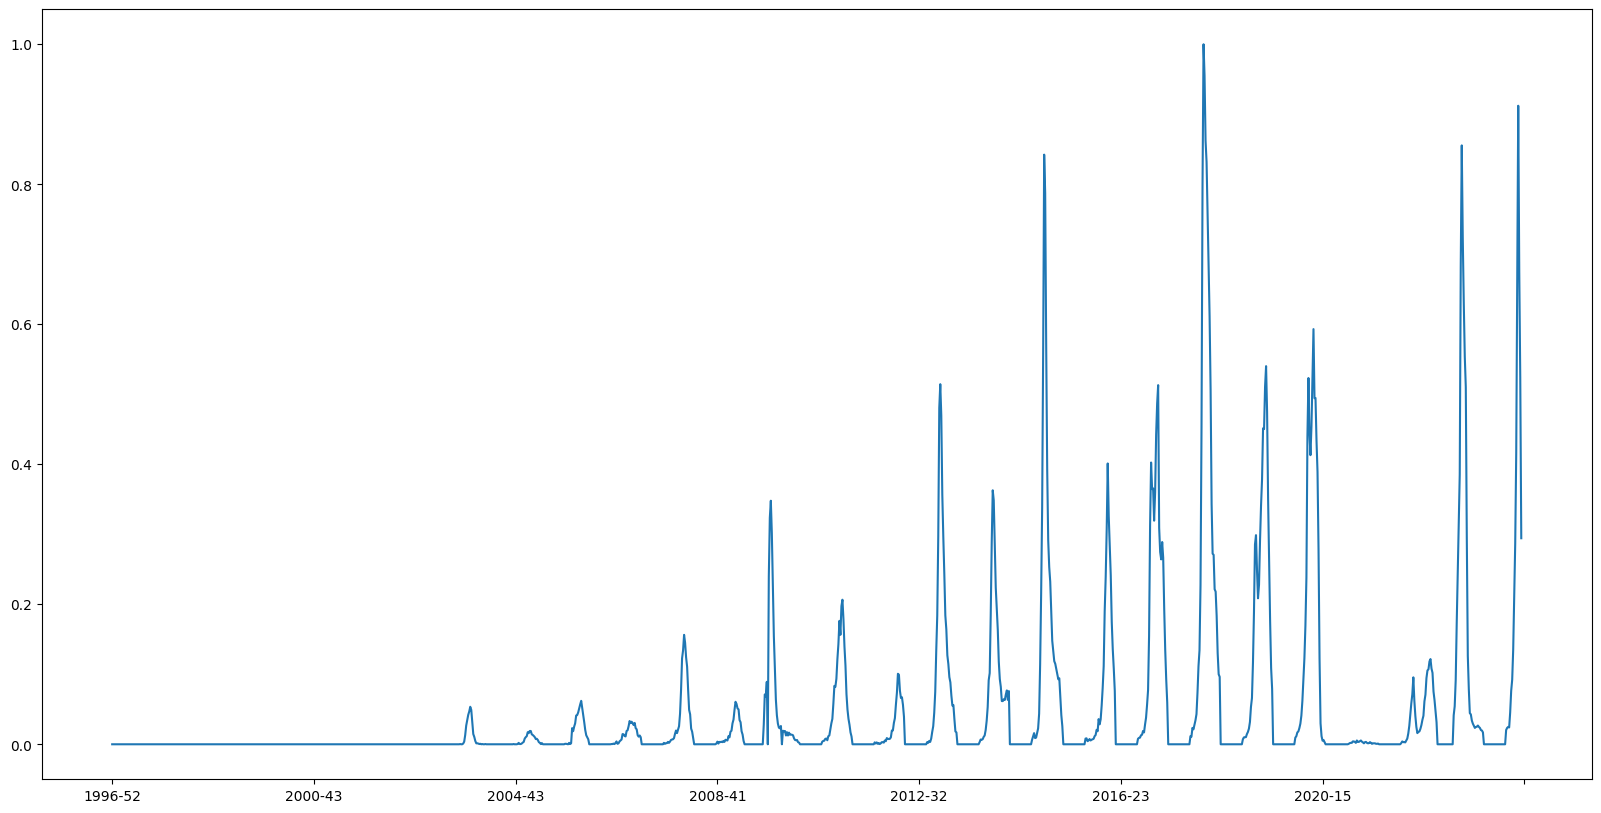

In [65]:
usa_infall_norm.plot()

In [66]:
df_in

INF_ALLAUS  INF_ALLCHL  INF_ALLPRY  INF_ALLARG  INF_ALLURY
1996-52         1.0         NaN         NaN         NaN         NaN
1997-01         1.0         0.0         NaN         NaN         NaN
1997-02         0.0         2.0         NaN         NaN         NaN
1997-03         0.0         NaN         NaN         NaN         NaN
1997-04         0.0         0.0         NaN         NaN         NaN
...             ...         ...         ...         ...         ...
2023-51        30.0       146.0         0.0        10.0         0.0
2023-52        29.0       115.0         1.0         4.0         0.0
2024-01        30.0         0.0         6.0         3.0         0.0
2024-02        45.0         0.0         4.0         8.0         0.0
2024-03       108.0         0.0         0.0         0.0         0.0

[1398 rows x 5 columns]

In [133]:
df_norm.to_excel("data\\VIW_FNT_6-26-2023.xlsx")

# Neural Network 

In [67]:
##################### training executable ########################################
def train(dataloader, model,device, loss_fn, optimizer,noise):
    
    # train function gets called inside function train_model
    # set up to be general but loss_fn and optimizer are hardcoded in train_model

    model.train()
    cnt = 0
    total_loss = 0
    for batches in dataloader:
            x,y = batches
         
            x=x.to_dense().to(device)
            y= y.to(device).float()
            pred=  model(x.float())
            if noise == True:
               randos = []
               for i in range(y.shape[0]):
                   rando = np.random.normal(loc=0.0, scale=.2, size=None)
                   randos.append(rando)
               randos = torch.tensor(randos)
               y = (1+rando)*y
          
            loss = loss_fn(pred,y)
           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            loss,current = loss.item(), cnt * len(x) # can't remember why I wanted "current"
          
            cnt+=1
            total_loss+= loss
    return float(total_loss)


############### test executable ##############################################
def test(dataloader, model, device,loss_fn):
    
    #same thing as train but doesn't run the optimizer or a backward

    num_batches = len(dataloader)
    
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to_dense().to(device), y.to(device)
            pred = model(X.float())
            
            test_loss+=loss_fn(pred,y.float()).item()
           
    return test_loss

################ this is the full training executable, uses "train" and "test" ##############################################
################ user be warned I change this almost daily trying to figure out better features ##########################################

def train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast):

# This is the function for minimizing a model for a dataset, saves best val and train model in PATH and outputs two tuples of losses for train/val


# PATH = destination for saving/loading the model
# model, device = model class instance , resources
# loss_fn = loss class instance
# batched_sequence = Dataset instance
# learn_rate = (float) learn_rate 
# num_epochs = (int) number of epochs
# kill = (int) if loss does not decrease for "kill" number of epochs end the routine
# batch_size_ = (int) batch size
# t_beg = (int) index in DATES to start fit
# t_end = (int) index in DATES to end fit
# noise = (bool) true or false to introduce noise in train
# forecast = (int) number of indices to include in validation beyond t_end

    #sparse_tensor = Dataset_(Y_df,dataframe_list) 
    #batched_sequence = SequenceDataset(sparse_tensor) # this is hard coded in but could get rid of this by just feeding batched_sequence as input
    time0 = time.perf_counter()
    
    with open(PATH[:-4]+".log","w") as f:
        f.write("starting log for model: "+PATH+"\n")
        loss_values = []
        pred = []
        train_ = Subset(batched_sequence,range(t_beg,t_end)) 
        train_dataloader = DataLoader(train_, batch_size=batch_size_, shuffle=False)

        test_ = Subset(batched_sequence,range(t_end,t_end+forecast))
        test_dataloader = DataLoader(test_, batch_size=1, shuffle=False)




        #loss_fn = nn.MSELoss()
        #loss_fn = nn.L1Loss()
        #loss_fn = elastic_net_loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
        losses, losses_test = [],[]
        c, epoch, loss_cut= 0,0, 1e99 # init
        d=c
        g = c
        loss_cut_t = loss_cut
        loss_cut_val = loss_cut

        while epoch < num_epochs:
        #for epoch in range(num_epochs):
            print("epoch",epoch,c,d)
            time1 = time.perf_counter()
            
            d+=1
            g+=1
            if d % 10 == 0 and d!=0:
                learn_rate*=0.1
                model.load_state_dict(torch.load(PATH[:-4]+"_train.pth"))
                optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
                
                print("Shrinking learning rate to",str(learn_rate))
                f.write("Shrinking learning rate to "+str(learn_rate)+"\n")
                if learn_rate < 1e-6:
                    print("Learning rate getting small")
                    f.write("Learning rate getting small\n")
                    break
    #         optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
            loss = train(train_dataloader,model,device,loss_fn,optimizer,noise)
            losses.append(loss)
        
            loss_test = test(test_dataloader,model,device,loss_fn)
            losses_test.append(loss_test)
            time2 = time.perf_counter()
        
            print("Train loss:",loss,"Val loss:",loss_test,"Time:",time2-time1)
            f.write("Train loss: "+str(loss)+" Val loss: "+str(loss_test)+" Time: "+str(time2-time1)+"\n")

            if epoch == 0:
                loss_cut = loss_test
            if epoch > 0:
                if loss_cut < loss_test:
                    c+=1
                else:
                    c = 0
                    torch.save(model.state_dict(), PATH)
                loss_cut = loss_test
            


            
            if loss < loss_cut_t:
                loss_cut_t = loss
                torch.save(model.state_dict(), PATH[:-4]+"_train.pth")
                d = 0
            if loss_test < loss_cut_val and epoch > 15:
                loss_cut_val = loss_test
                torch.save(model.state_dict(), PATH[:-4]+"_val.pth")
                g = 0
        # test(train_dataloader,model,loss_fn)
        
            if c == kill and epoch > 30:
                print("reached val limit, early stopping now")
                break
            epoch +=1
                
        
        print("Complete")
        print("Total time:",time2-time0)
        f.write("Complete\n Total time: "+str(time2-time0))
    return losses,losses_test 

In [68]:
def create_prediction(PATH,NN,device,batched_sequence,Y_mean,Y_std,norm_bool):
    
    # PATH = location of model
    # NN = model class instance
    # batched_sequence= data class instance
    # Y_mean = mean of target for undoing standard scalar transform
    # Y_std = standard deviation of target for undoing standard scalar transform
    # norm_bool = True/False if you want to return Normalized/Raw transformation
    
    NN.load_state_dict(torch.load(PATH))
    NN.eval()
    #sparse_tensor = Dataset_(Y_df,dataframe_list)
    #batched_sequence = SequenceDataset(sparse_tensor)
    #sub_ = Subset(batched_sequence,range(0,136))
    sub_ = batched_sequence
    datas = DataLoader(sub_, batch_size=1, shuffle=False)
    all_,ys = [],[]
    for x,y in datas:
        x=x.to_dense().to(device)
        pred= NN(x.float())
    
        all_.append(pred[0].cpu().detach().numpy())
        ys.append(y.to_dense().numpy())
    all_ =  np.array(all_)
    
    if norm_bool==False: # undo standard scalar
        tmp = np.ones(shape = all_[:,0].shape,dtype=float)*Y_mean[0]
    
        all_ = all_[:,0] * Y_std[0]+tmp

    return all_

In [79]:
class Dataset_(Dataset):
    
    def __init__(self,Y_df,df,seq,shift):
    
            
        df = df.to_numpy()
        y = Y_df.to_numpy()
        data_tmp = []
        for i in range(df.shape[0]):
            batch = []
            for j in range(seq):

                ind = i+j - shift

                if ind <0:
                    batch.append(np.zeros(shape=df[ind].shape))

                else:
                    batch.append(df[ind])
            data_tmp.append(batch)

        data_tmp = np.array(data_tmp)

        data = []
        print(y.shape)
        for j in range(df.shape[0]):
            
            x = torch.from_numpy(np.asarray(data_tmp[j]))
            Y = torch.tensor(y[j])
            data.append((x,Y))
        
        self.data = data
        
    def __len__(self):

        return len(self.data)
    def __getitem__(self,i):
            
            #return item at i
            
        return self.data[i]

In [76]:
usa_infall_norm

1996-52    0.000000
1997-01    0.000000
1997-02    0.000000
1997-03    0.000000
1997-04    0.000000
             ...   
2023-51    0.678535
2023-52    0.912174
2024-01    0.676161
2024-02    0.523567
2024-03    0.294337
Name: INF_ALL, Length: 1398, dtype: float32

In [80]:
tmp =df_norm.join( pd.DataFrame(data=usa_infall_norm.values, columns =['all'],index=usa_infall_norm.index),on=df_norm.index)
tmp = tmp.fillna(0.0)
index = list(tmp.index)

data_in = Dataset_(tmp["all"],tmp.drop(['all','key_0'],axis=1),26,26+20)

(1398,)


# GRU

In [81]:
class gru(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru, self).__init__()
        
        
        
        self.gru = nn.GRU(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.gru(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.gru(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [128]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 16.616910080220492 Val loss: 2.4811990413018066 Time: 0.780868100002408
epoch 1 0 0
Train loss: 14.048882770018562 Val loss: 2.301873894131859 Time: 0.6862132000096608
epoch 2 0 0
Train loss: 12.7479440673198 Val loss: 2.0695868060804514 Time: 0.6487251999933505
epoch 3 0 0
Train loss: 11.103969885884567 Val loss: 1.759486658818787 Time: 0.6504878000123426
epoch 4 0 0
Train loss: 8.877313449833053 Val loss: 1.410648511533509 Time: 0.6632784999965224
epoch 5 0 0
Train loss: 7.214896598190251 Val loss: 1.2465707544179168 Time: 0.6544199000054505
epoch 6 0 0
Train loss: 6.3775866181775624 Val loss: 1.2202693251892924 Time: 0.6483256999927107
epoch 7 0 0
Train loss: 6.161883623614003 Val loss: 1.2172930326778442 Time: 0.6343469000130426
epoch 8 0 0
Train loss: 6.106733873055341 Val loss: 1.2145691006153356 Time: 0.681072999999742
epoch 9 0 0
Train loss: 5.946364864644014 Val loss: 1.2142729983315803 Time: 0.6829715999920154
epoch 10 0 0
Train loss: 5.765143487714759

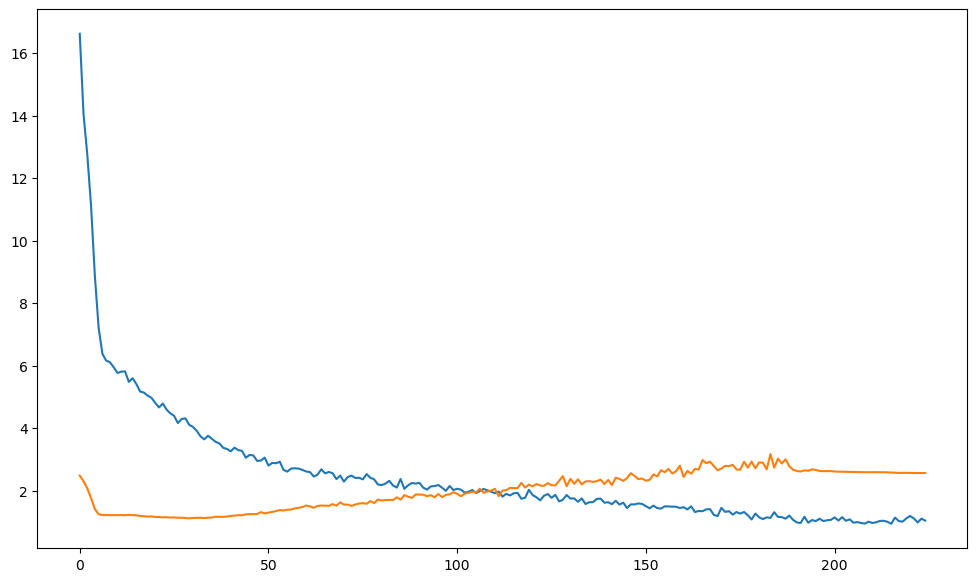

In [129]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

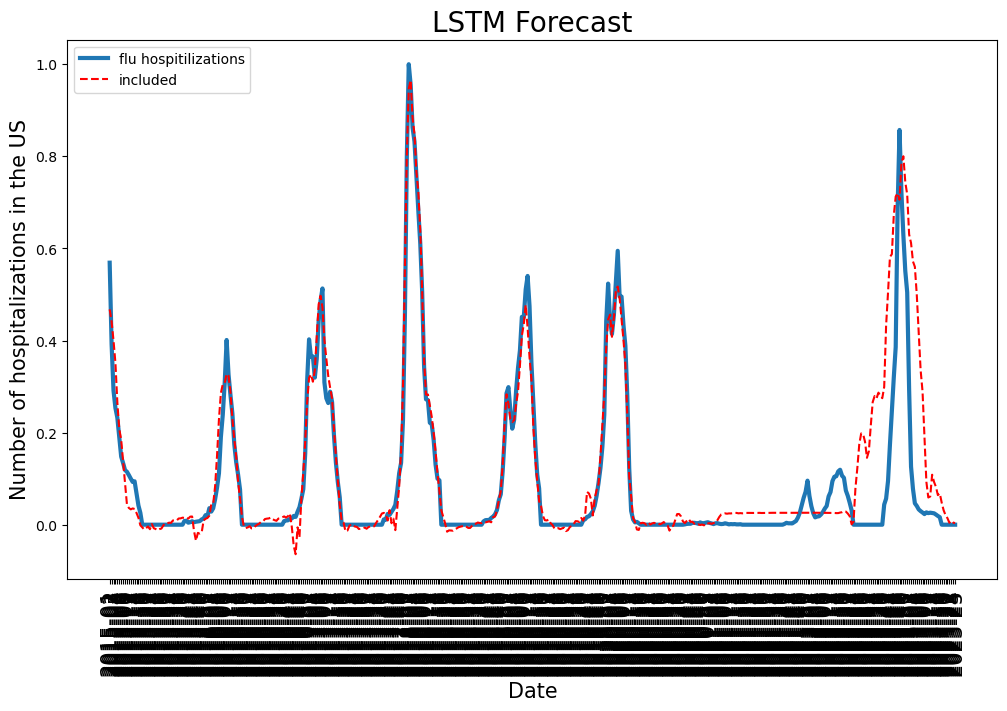

In [135]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [143]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 3.5346466688987688 Val loss: 0.0 Time: 0.9295592999988003
epoch 1 0 0
Train loss: 3.6944229654639766 Val loss: 0.0 Time: 0.8179782999941381
epoch 2 0 1
Train loss: 2.9332456192163563 Val loss: 0.0 Time: 0.7305305000045337
epoch 3 0 0
Train loss: 3.0330596951348094 Val loss: 0.0 Time: 0.70671910000965
epoch 4 0 1
Train loss: 2.7321796904125253 Val loss: 0.0 Time: 0.7145052999985637
epoch 5 0 0
Train loss: 2.59415670315074 Val loss: 0.0 Time: 0.6997169000096619
epoch 6 0 0
Train loss: 2.4527965838584938 Val loss: 0.0 Time: 0.6944220000004862
epoch 7 0 0
Train loss: 2.3578970532056553 Val loss: 0.0 Time: 0.6983154000045033
epoch 8 0 0
Train loss: 2.2896741703410415 Val loss: 7.671608841519628e-07 Time: 0.7145773999945959
epoch 9 1 0
Train loss: 2.169482777121681 Val loss: 0.0 Time: 0.7075658000103431
epoch 10 0 0
Train loss: 2.1858031039670323 Val loss: 6.684902018605499e-06 Time: 0.8987534000043524
epoch 11 1 1
Train loss: 2.075417609888461 Val loss: 3.12888062126

Text(0.5, 0, 'Date')

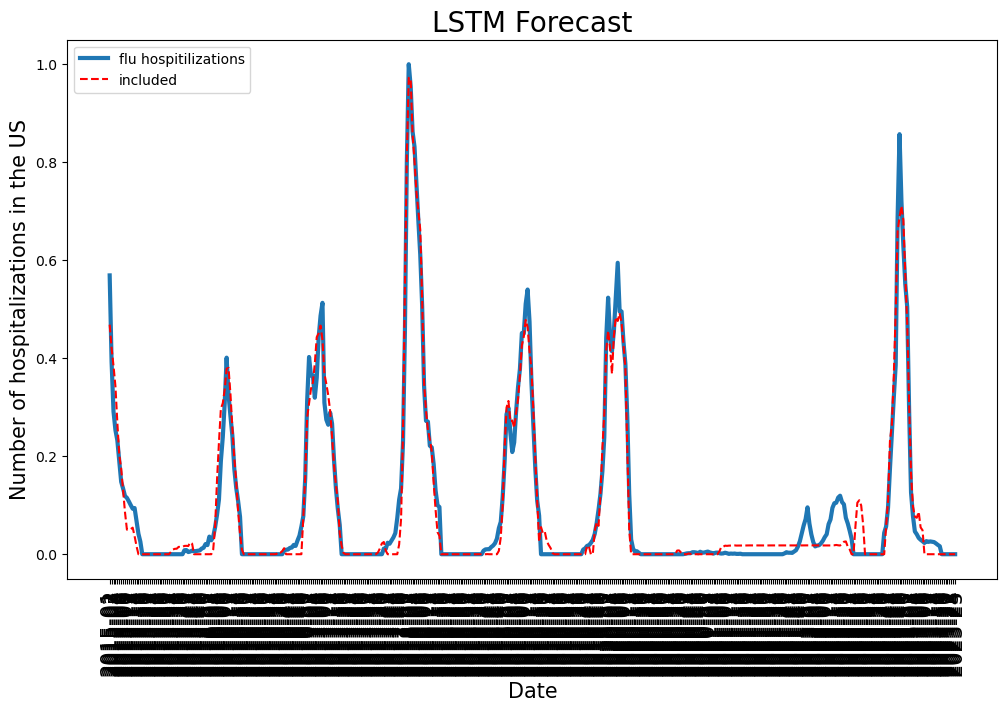

In [144]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

(1370,)


Text(0.5, 0, 'Date')

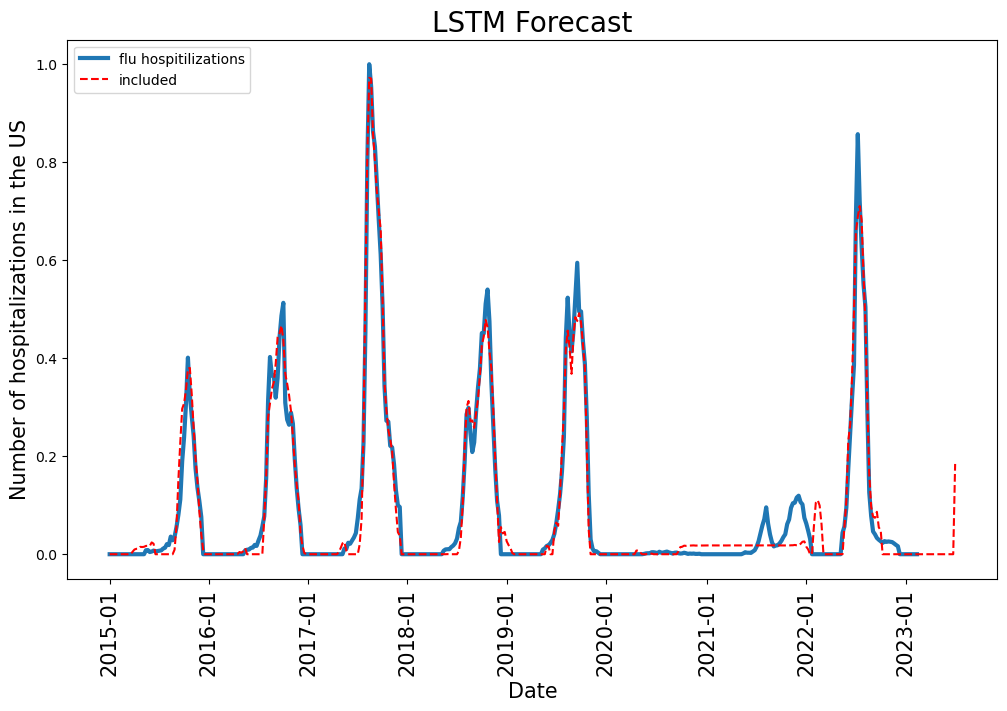

In [147]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,26)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].shift(-20).loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# GRU - Linear - GRU - Linear - Linear

In [82]:
class gru_drop(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru_drop, self).__init__()
        
        
        
        self.gru = nn.GRU(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.20),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.gru(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.gru(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [164]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 16.01972439670064 Val loss: 2.5358576538583293 Time: 0.9493535999936284
epoch 1 0 0
Train loss: 14.395146600277974 Val loss: 2.4592087899254693 Time: 0.8814392999920528
epoch 2 0 0
Train loss: 13.902264284515923 Val loss: 2.378747069516976 Time: 0.8596061999996891
epoch 3 0 0
Train loss: 12.314892520470199 Val loss: 2.1927524294869727 Time: 0.865769600000931
epoch 4 0 0
Train loss: 9.728183449909679 Val loss: 1.6325577824609354 Time: 0.8498623999912525
epoch 5 0 0
Train loss: 7.666266876420252 Val loss: 1.3958138425114157 Time: 0.8525076000078116
epoch 6 0 0
Train loss: 6.827099656150984 Val loss: 1.3224419932521414 Time: 0.8713372999918647
epoch 7 0 0
Train loss: 6.330625499853532 Val loss: 1.305312226388196 Time: 0.8685859000106575
epoch 8 0 0
Train loss: 6.211696676471625 Val loss: 1.3085760725152795 Time: 0.8497795000002952
epoch 9 1 0
Train loss: 5.797990739720124 Val loss: 1.3014910843635334 Time: 0.8505749000032665
epoch 10 0 0
Train loss: 5.7507488213091

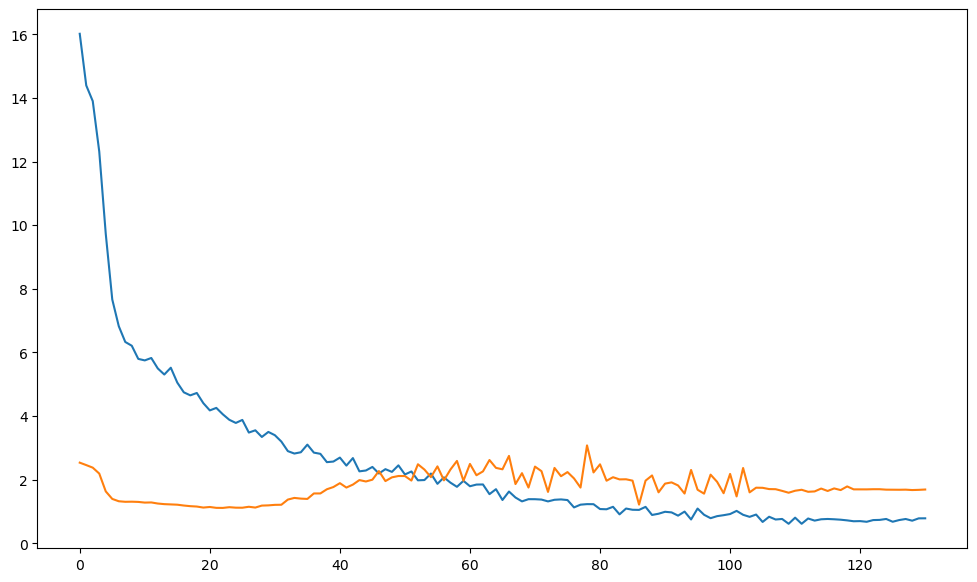

In [165]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

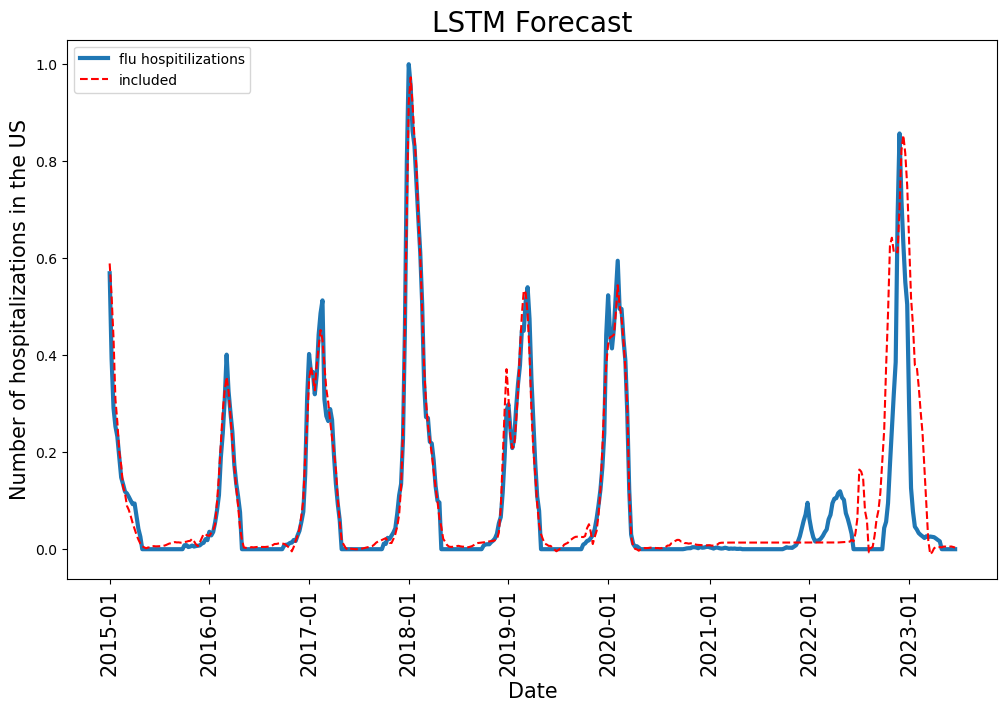

In [166]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [170]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [171]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 2.245656678959975 Val loss: 0.0 Time: 0.9671429000009084
epoch 1 0 0
Train loss: 2.879762383157418 Val loss: 0.0 Time: 1.6220725999883143
epoch 2 0 1
Train loss: 2.336570934593923 Val loss: 0.0 Time: 2.0829387999983737
epoch 3 0 2
Train loss: 2.187462782328121 Val loss: 0.0 Time: 1.3734609999955865
epoch 4 0 0
Train loss: 1.8248754945705943 Val loss: 0.0 Time: 1.0275094999960857
epoch 5 0 0
Train loss: 1.7734294983042795 Val loss: 0.0 Time: 0.96462350001093
epoch 6 0 0
Train loss: 1.9390870623081247 Val loss: 0.0 Time: 0.9513777000101982
epoch 7 0 1
Train loss: 1.3993500799806746 Val loss: 0.0 Time: 0.9569488999986788
epoch 8 0 0
Train loss: 1.71046632990081 Val loss: 0.0 Time: 0.9656978999992134
epoch 9 0 1
Train loss: 1.1209559905072375 Val loss: 0.0 Time: 2.240541100007249
epoch 10 0 0
Train loss: 1.3255863163231267 Val loss: 0.0 Time: 2.345554200001061
epoch 11 0 1
Train loss: 1.2393439711985668 Val loss: 0.0 Time: 1.0499038999987533
epoch 12 0 2
Train loss:

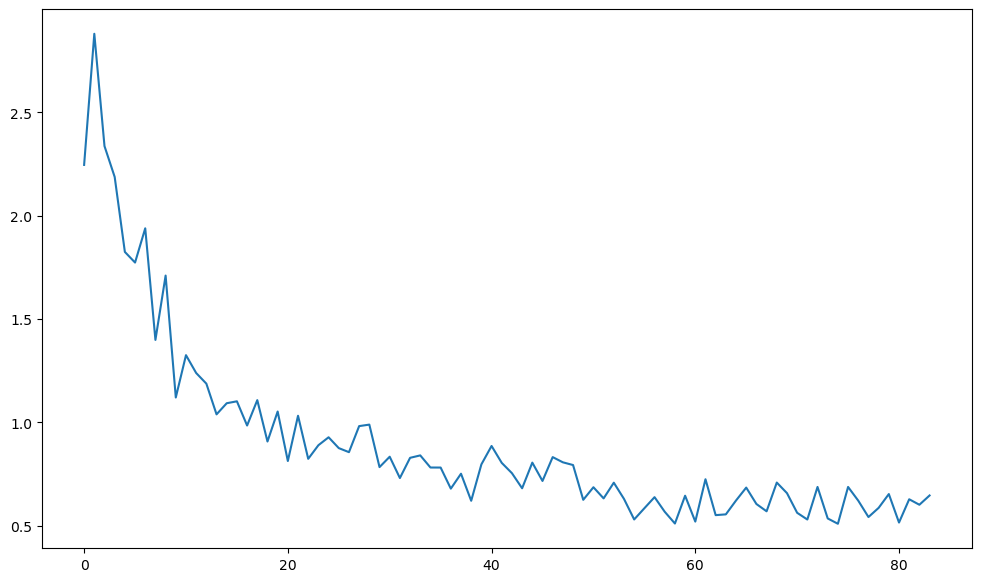

In [172]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

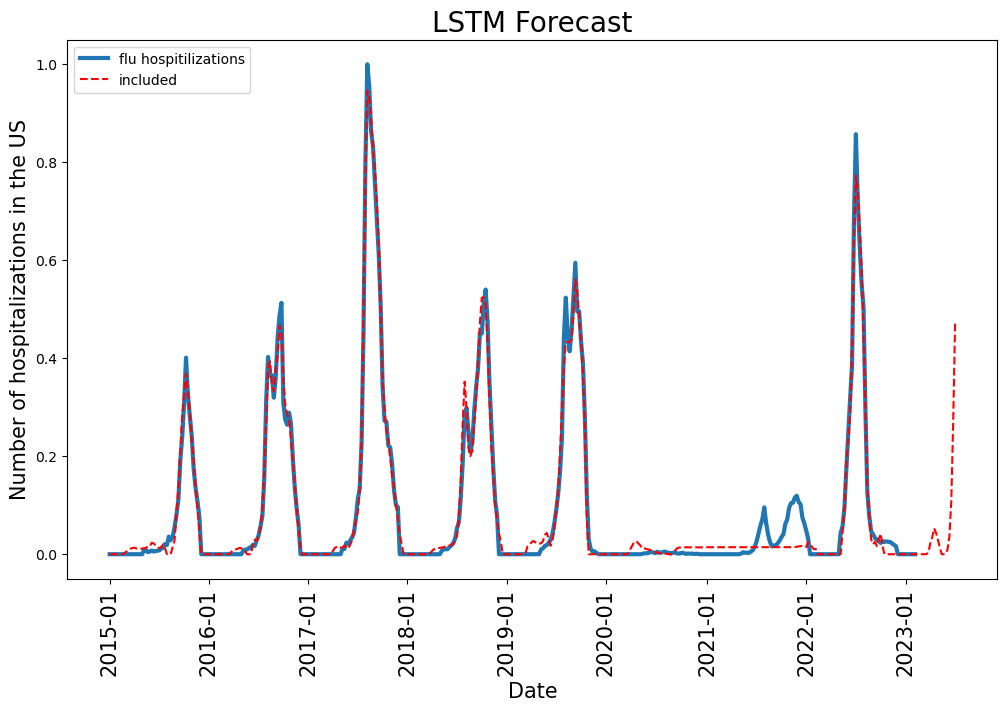

In [180]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# GRU - Linear - GRU - Linear - GRU - Linear - Linear

In [83]:
class gru_3lay_drop(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru_3lay_drop, self).__init__()
        
        self.gru = nn.GRU(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(50,1)
        )        
        
    def forward(self, x):
        
        logits, _ = self.gru(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.gru(logits)
        logits = self.enc(logits)
        logits, _ = self.gru(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [269]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_3lay_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [270]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 17.11632422599213 Val loss: 2.571337046754479 Time: 1.2503694000042742
epoch 1 0 0
Train loss: 14.747952652827667 Val loss: 2.5044909056814504 Time: 1.0961225999926683
epoch 2 0 0
Train loss: 14.639941387988301 Val loss: 2.5173887083146838 Time: 1.1137114000011934
epoch 3 1 0
Train loss: 14.598763867643072 Val loss: 2.611901161399146 Time: 1.1718961000005947
epoch 4 2 0
Train loss: 14.879162602334922 Val loss: 2.5664651679956023 Time: 1.136651399996481
epoch 5 0 1
Train loss: 14.861692862652433 Val loss: 2.552685138700781 Time: 1.1501893999957247
epoch 6 0 2
Train loss: 14.642531839083517 Val loss: 2.4855718125763815 Time: 1.1335943000012776
epoch 7 0 3
Train loss: 14.287691668245891 Val loss: 2.38448679387875 Time: 1.1243462999991607
epoch 8 0 0
Train loss: 12.441980750750709 Val loss: 1.9568174398227711 Time: 1.1465850000095088
epoch 9 0 0
Train loss: 7.814506115962857 Val loss: 1.410179827202228 Time: 1.1008409000060055
epoch 10 0 0
Train loss: 6.185289280846

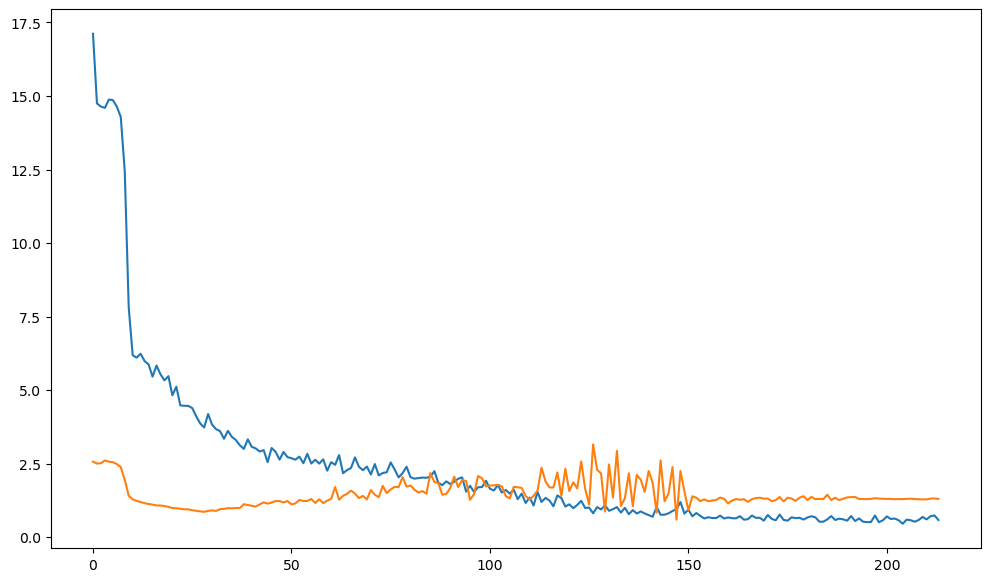

In [271]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

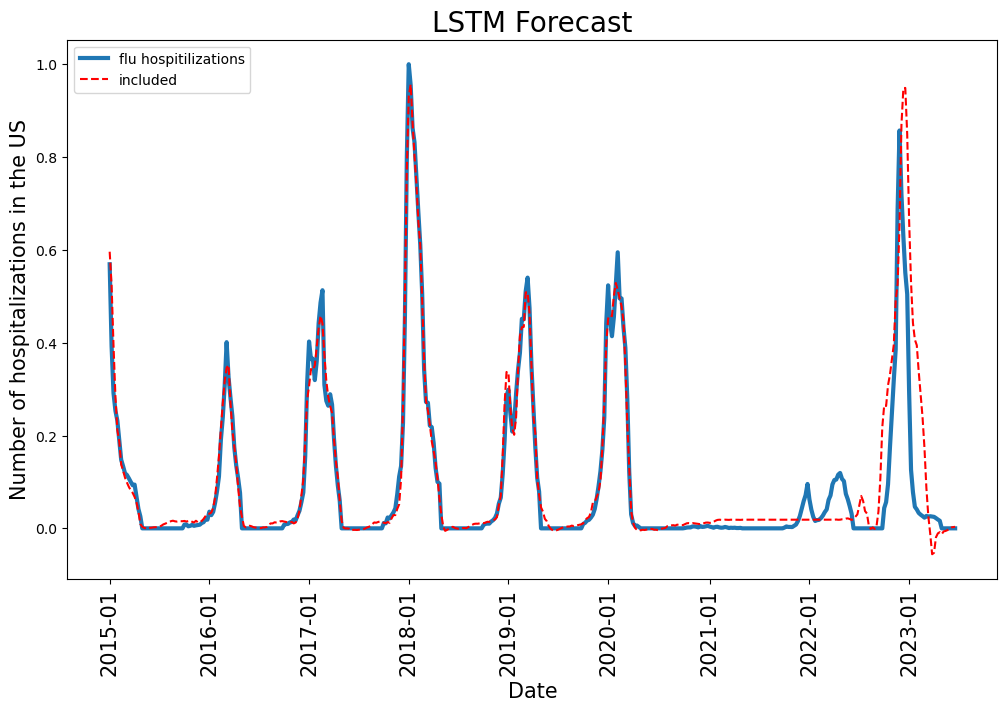

In [272]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [273]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_3lay_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [274]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 2.721263869637885 Val loss: 0.00032419266062788665 Time: 1.1603813999972772
epoch 1 0 0
Train loss: 2.971110897853656 Val loss: 0.00010732162627391517 Time: 1.2064602000027662
epoch 2 0 1
Train loss: 2.433316056806309 Val loss: 0.0001108567084884271 Time: 1.2582860000111395
epoch 3 1 0
Train loss: 2.056089600845686 Val loss: 9.294369374401867e-05 Time: 1.2358266999945045
epoch 4 0 0
Train loss: 2.0560507036306266 Val loss: 0.0001303312456002459 Time: 1.2314857000019401
epoch 5 1 0
Train loss: 1.6040506554834462 Val loss: 8.45387767185457e-05 Time: 1.3913429999956861
epoch 6 0 0
Train loss: 1.6228068870276466 Val loss: 0.0001982950489036739 Time: 1.8614592000085395
epoch 7 1 1
Train loss: 1.7707645450767788 Val loss: 0.0001172496922663413 Time: 1.4151507999922615
epoch 8 0 2
Train loss: 1.2654121307639867 Val loss: 6.773910718038678e-05 Time: 1.1688476000126684
epoch 9 0 0
Train loss: 1.2441147997463502 Val loss: 8.377204358112067e-05 Time: 1.241592699996545
epoc

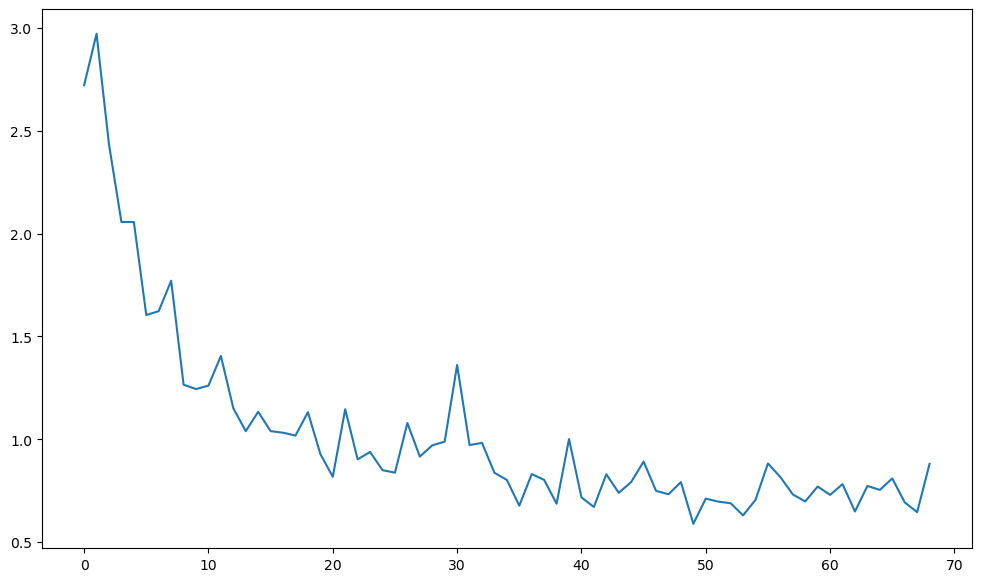

In [275]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

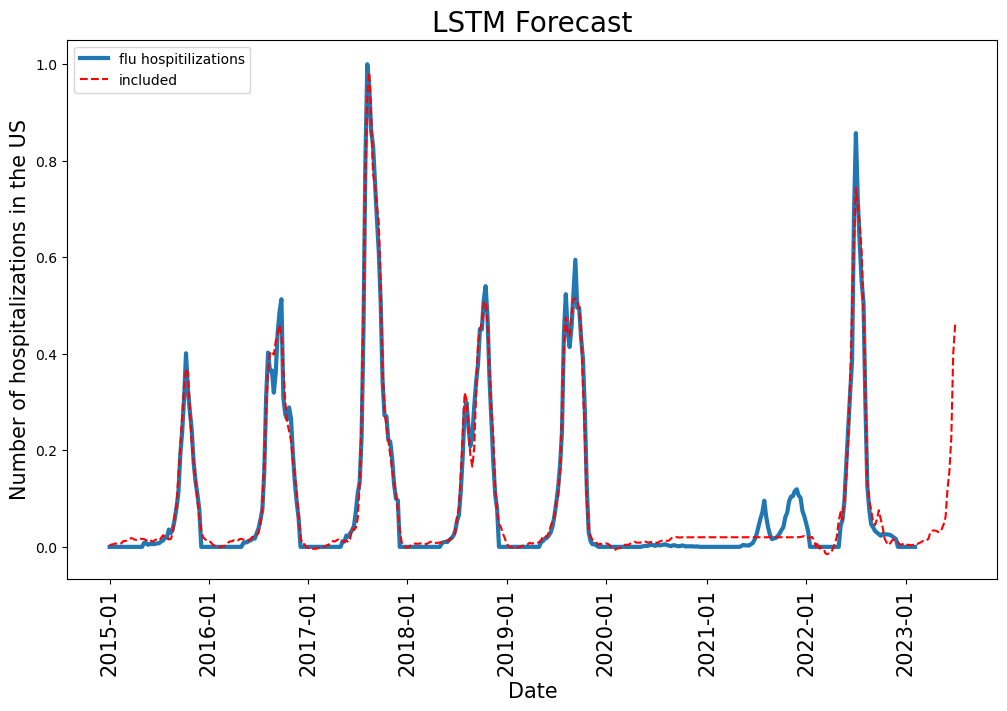

In [276]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# (throwout) GRU Drop B

In [22]:
class gru_drop_B(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru_drop_B, self).__init__()
        
        self.gru = nn.GRU(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),

            nn.Linear(seq_len*country_len,seq_len*country_len),
            nn.Dropout(0.1),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(50,1)
        )        
        
    def forward(self, x):
        
        logits, _ = self.gru(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.gru(logits)
        
        logits = self.seq(logits)
        
        
        return logits

# 22-23

In [328]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_drop_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [329]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.65863492532435 Val loss: 2.366238483613415 Time: 1.1372320000082254
epoch 1 0 0
Train loss: 14.368492018845814 Val loss: 2.371027490575216 Time: 1.1212723999924492
epoch 2 1 0
Train loss: 14.091291077503229 Val loss: 2.3512154582276708 Time: 1.102333799994085
epoch 3 0 0
Train loss: 12.216567124505588 Val loss: 1.937220497718954 Time: 1.124690800003009
epoch 4 0 0
Train loss: 7.868382210542514 Val loss: 1.1823348304606043 Time: 1.1481261999870185
epoch 5 0 0
Train loss: 6.766710738366509 Val loss: 1.0596471554381424 Time: 1.1374608999904012
epoch 6 0 0
Train loss: 6.073205642095734 Val loss: 0.9711651627512765 Time: 1.062365799996769
epoch 7 0 0
Train loss: 5.725944483562326 Val loss: 0.967220307495154 Time: 1.1328117999946699
epoch 8 0 0
Train loss: 5.480003746281105 Val loss: 0.9317652306034461 Time: 1.1929558999981964
epoch 9 0 0
Train loss: 5.359178481931851 Val loss: 0.9087591682027778 Time: 1.1434860000008484
epoch 10 0 0
Train loss: 5.243828365629984 V

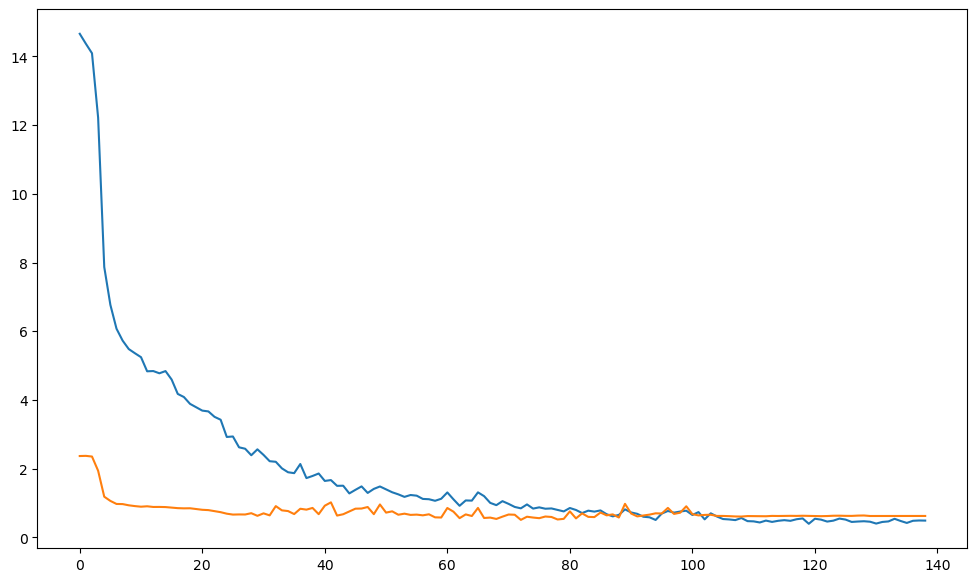

In [330]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

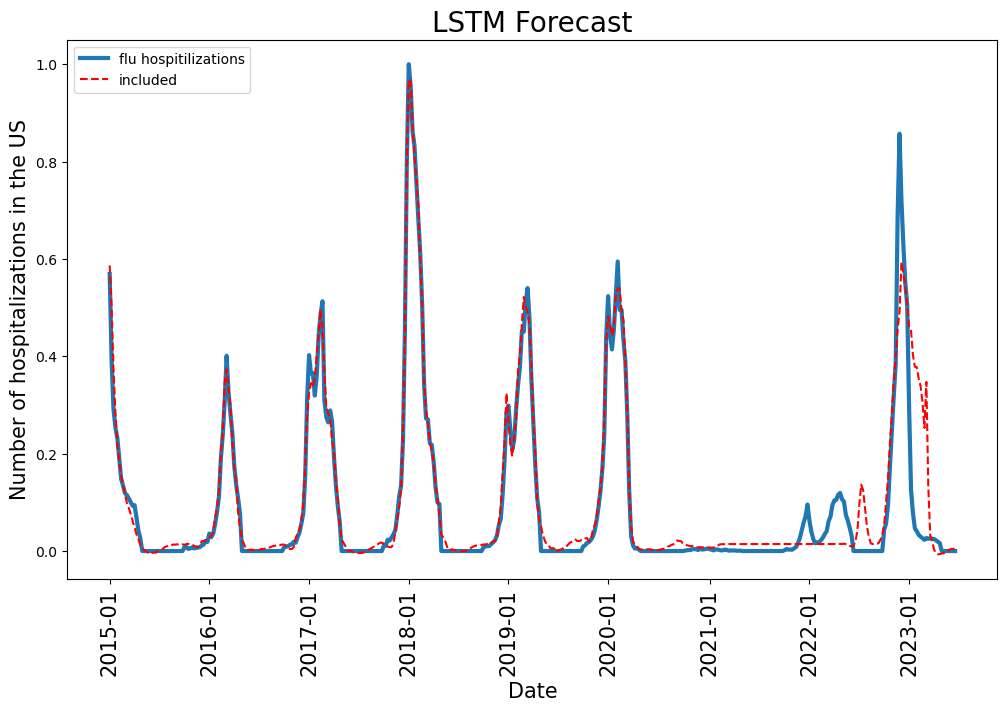

In [331]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# LSTM

In [84]:
class lstm(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm, self).__init__()
        
        
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [200]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.474489671546962 Val loss: 2.415540261601791 Time: 1.2206373999943025
epoch 1 0 0
Train loss: 14.159815170792228 Val loss: 2.4091310696676373 Time: 0.9068807000003289
epoch 2 0 0
Train loss: 14.099517686826752 Val loss: 2.3217978474858683 Time: 0.9196096000086982
epoch 3 0 0
Train loss: 13.539378684562282 Val loss: 2.207002379174014 Time: 0.9186772000102792
epoch 4 0 0
Train loss: 12.699618559638338 Val loss: 1.9860588182527863 Time: 0.8979965000035008
epoch 5 0 0
Train loss: 10.82678228792642 Val loss: 1.6060749031603336 Time: 0.8573677000094904
epoch 6 0 0
Train loss: 8.164547849790324 Val loss: 1.2545395700725024 Time: 0.9020385000039823
epoch 7 0 0
Train loss: 6.672245478572785 Val loss: 1.1336108664399944 Time: 0.9413620999985142
epoch 8 0 0
Train loss: 6.074593031451411 Val loss: 1.0776338410796598 Time: 0.8992152999999234
epoch 9 0 0
Train loss: 5.949836345588301 Val loss: 1.053827122959774 Time: 0.8504455000074813
epoch 10 0 0
Train loss: 5.93509014296

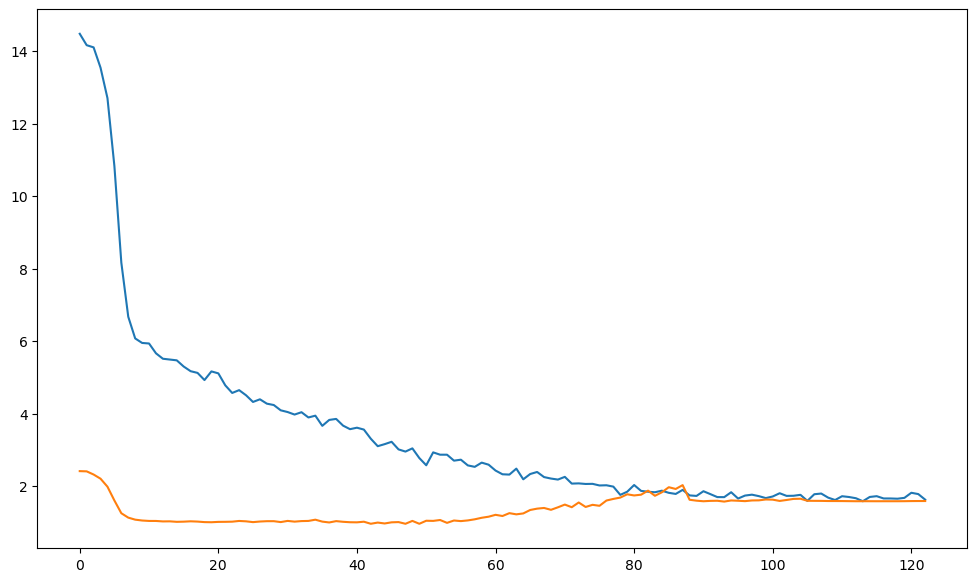

In [201]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

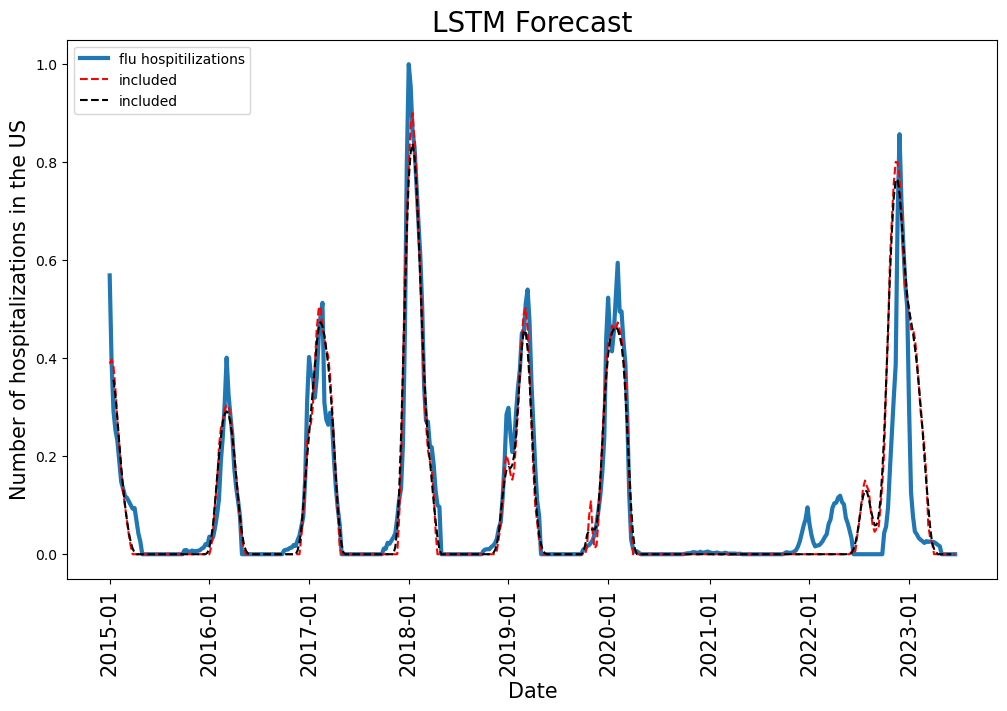

In [202]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'].rolling(5,center=True).mean(),linestyle="dashed",color='black',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [203]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [204]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 3.388585950486451 Val loss: 0.0 Time: 1.0004228000034345
epoch 1 0 0
Train loss: 3.614659081639161 Val loss: 0.0 Time: 0.9695357000018703
epoch 2 0 1
Train loss: 3.6722860813562512 Val loss: 0.0 Time: 0.9597976000077324
epoch 3 0 2
Train loss: 3.2791296579138667 Val loss: 0.0 Time: 1.3558713999955216
epoch 4 0 0
Train loss: 3.30128160541409 Val loss: 0.0 Time: 1.386462800001027
epoch 5 0 1
Train loss: 3.4060978602771557 Val loss: 0.0 Time: 1.3170354000030784
epoch 6 0 2
Train loss: 3.413901887529562 Val loss: 0.0 Time: 1.4747847000107868
epoch 7 0 3
Train loss: 2.948133286959802 Val loss: 0.0 Time: 1.1328531000035582
epoch 8 0 0
Train loss: 3.2515049395923796 Val loss: 0.0 Time: 1.3830462000041734
epoch 9 0 1
Train loss: 3.1034021264671026 Val loss: 0.0 Time: 1.7825462000037078
epoch 10 0 2
Train loss: 2.8898138487565124 Val loss: 0.0 Time: 1.8209924999973737
epoch 11 0 0
Train loss: 2.950524866659947 Val loss: 0.0 Time: 1.8013000000064494
epoch 12 0 1
Train los

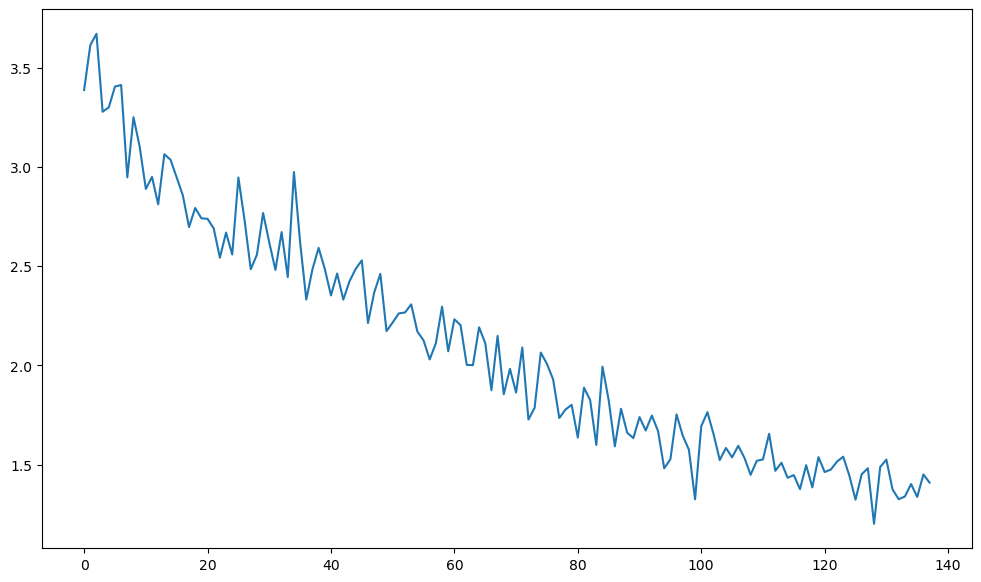

In [205]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

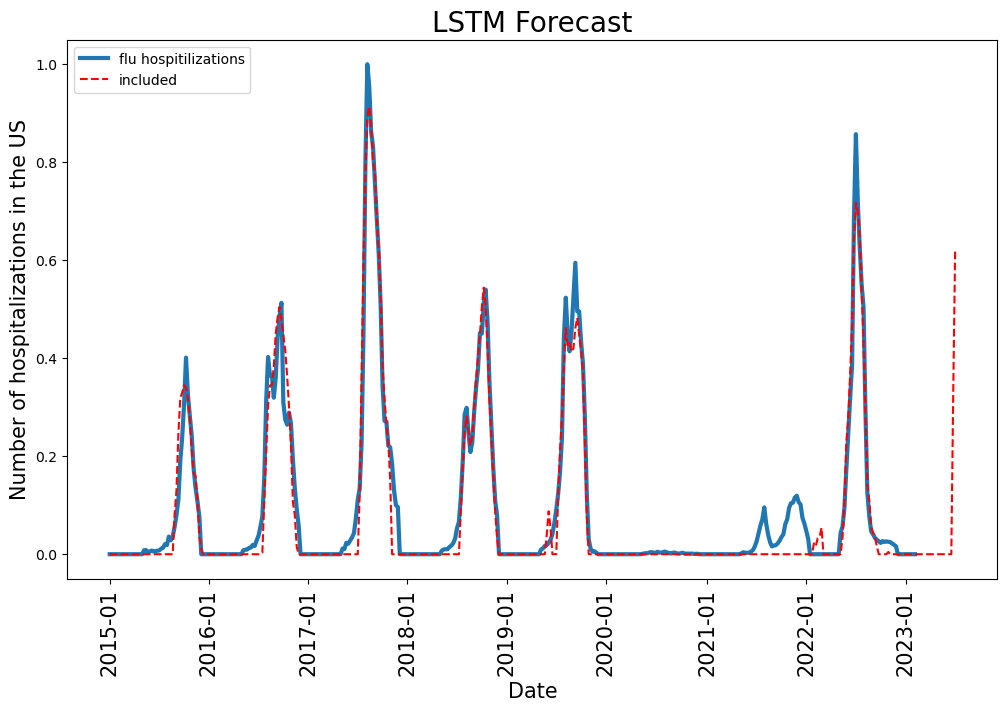

In [206]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# LSTM - Linear - LSTM - Linear - Linear

In [85]:
class lstm_drop(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_drop, self).__init__()
        
        
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.20),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [209]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.319221319353886 Val loss: 2.3828484726345778 Time: 0.9735170000058133
epoch 1 0 0
Train loss: 14.230626233416032 Val loss: 2.3679547240462853 Time: 0.911635300013586
epoch 2 0 0
Train loss: 14.109666596004672 Val loss: 2.3547786141425604 Time: 0.8868604000017513
epoch 3 0 0
Train loss: 13.500583527372072 Val loss: 2.2485410102526657 Time: 0.8966448999999557
epoch 4 0 0
Train loss: 11.083739825403882 Val loss: 1.6707020164594724 Time: 0.9157229000120424
epoch 5 0 0
Train loss: 7.764725114016296 Val loss: 1.2742567839450203 Time: 0.8669708999950672
epoch 6 0 0
Train loss: 6.407766229751164 Val loss: 1.1905658500327263 Time: 0.8826202000054764
epoch 7 0 0
Train loss: 5.9884319915155935 Val loss: 1.157313403178705 Time: 0.8822611999930814
epoch 8 0 0
Train loss: 6.069765684930847 Val loss: 1.148108327164664 Time: 0.9067820999916876
epoch 9 0 1
Train loss: 5.829205622241961 Val loss: 1.159200254951429 Time: 0.8780200000037439
epoch 10 1 0
Train loss: 5.63335405661

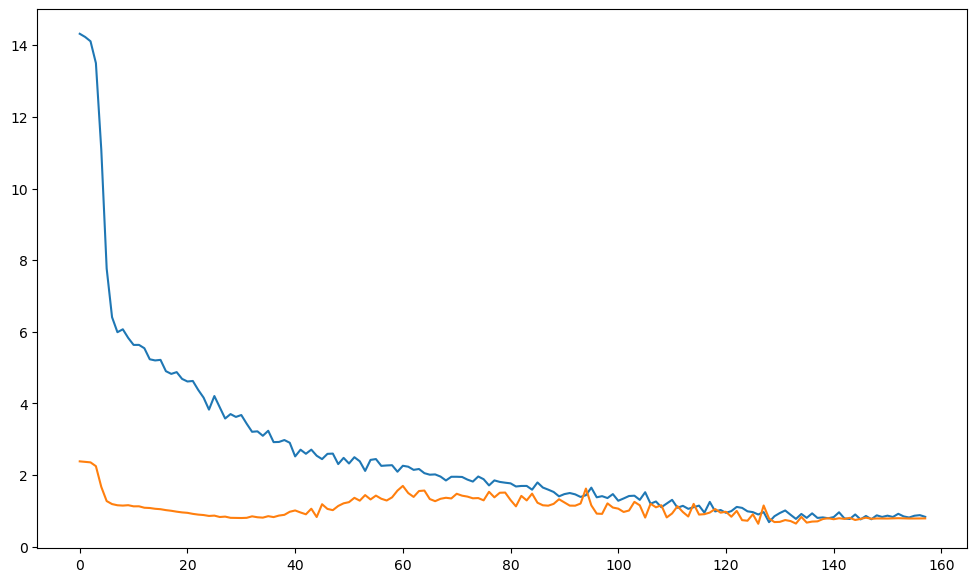

In [211]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

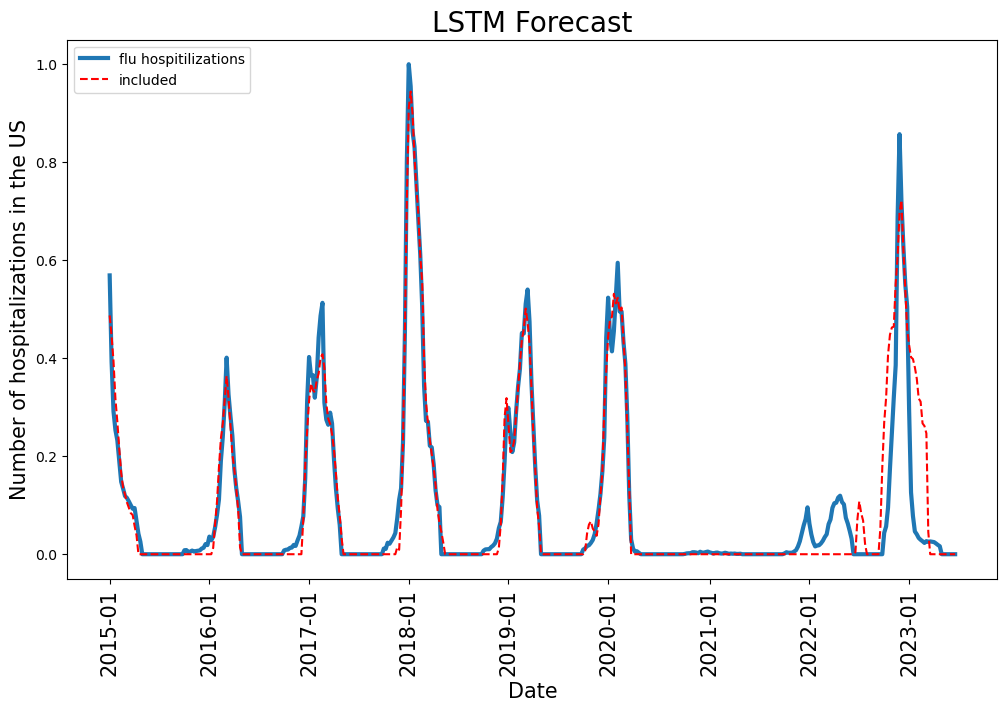

In [212]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [213]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [214]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 1.9240993616688797 Val loss: 0.0 Time: 1.0381205000012415
epoch 1 0 0
Train loss: 2.169387720548272 Val loss: 0.0 Time: 0.9982825000042794
epoch 2 0 1
Train loss: 2.137650001397219 Val loss: 0.0 Time: 1.0548203000071226
epoch 3 0 2
Train loss: 1.659426719471437 Val loss: 0.0 Time: 1.1208508999989135
epoch 4 0 0
Train loss: 1.6720364379816601 Val loss: 0.0 Time: 1.0225033999886364
epoch 5 0 1
Train loss: 1.413007691878306 Val loss: 0.0 Time: 0.9910930000041844
epoch 6 0 0
Train loss: 1.4962920210321409 Val loss: 0.0 Time: 0.9545270999951754
epoch 7 0 1
Train loss: 1.4774516884067896 Val loss: 0.0 Time: 1.0039747999981046
epoch 8 0 2
Train loss: 1.4962821095614451 Val loss: 0.0 Time: 1.1555086000007577
epoch 9 0 3
Train loss: 1.235162916720526 Val loss: 0.0 Time: 1.104233000005479
epoch 10 0 0
Train loss: 1.2859243733037857 Val loss: 0.0 Time: 1.1540424000122584
epoch 11 0 1
Train loss: 1.229392999276513 Val loss: 0.0 Time: 1.1181064000120386
epoch 12 0 0
Train lo

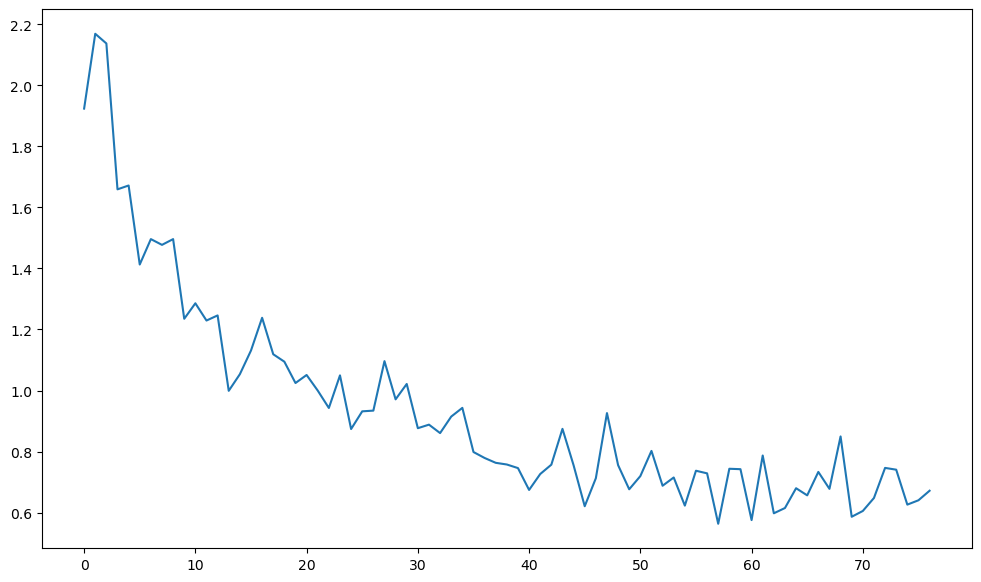

In [215]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

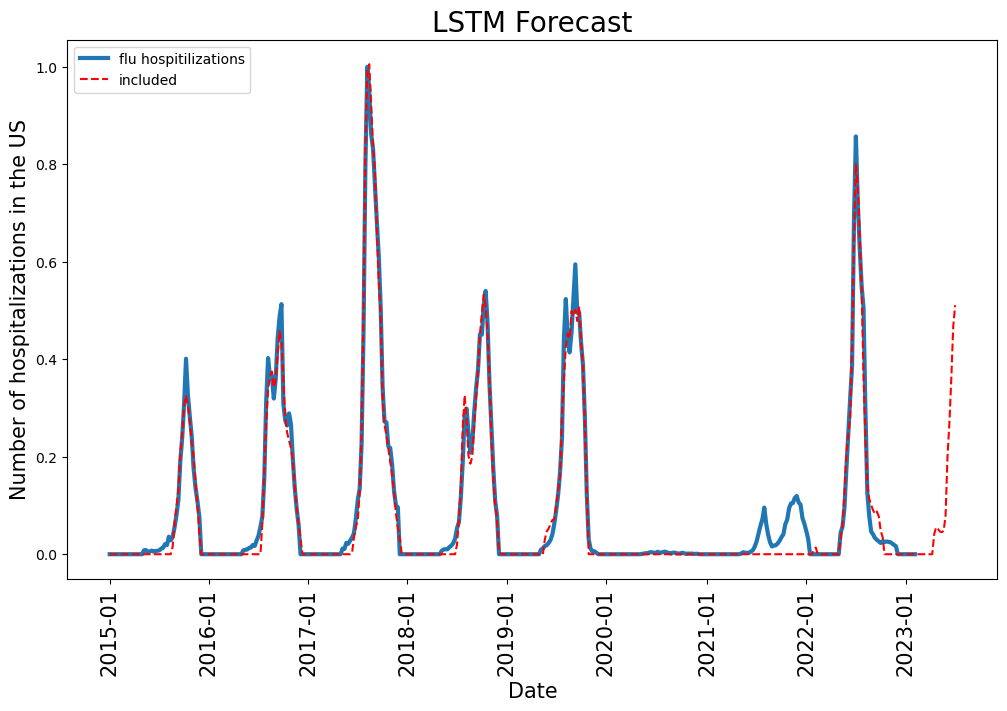

In [216]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# LSTM - Linear - LSTM - Linear - LSTM - Linear - Linear

In [87]:
class lstm_3lay_drop(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_3lay_drop, self).__init__()
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(50,1)
        )        
        
    def forward(self, x):
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [244]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_3lay_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [245]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 15.64415413920168 Val loss: 2.531999301918404 Time: 2.080021300003864
epoch 1 0 0
Train loss: 14.642779575933414 Val loss: 2.476724979667779 Time: 2.149593999987701
epoch 2 0 0
Train loss: 14.440149876654651 Val loss: 2.4265284029985423 Time: 2.162806099993759
epoch 3 0 0
Train loss: 14.5281391784618 Val loss: 2.409147869881963 Time: 1.796965600005933
epoch 4 0 1
Train loss: 14.414312054243965 Val loss: 2.3994423548638224 Time: 1.0734498999954667
epoch 5 0 0
Train loss: 14.358613161170041 Val loss: 2.423465033903085 Time: 1.1526998999906937
epoch 6 1 0
Train loss: 14.323822128998131 Val loss: 2.3447464717828552 Time: 1.1303062999941176
epoch 7 0 0
Train loss: 13.151912755676905 Val loss: 1.9840565627310127 Time: 1.1049027999979444
epoch 8 0 0
Train loss: 9.177096218843076 Val loss: 1.2661541593042784 Time: 1.1331352999986848
epoch 9 0 0
Train loss: 7.181851650326523 Val loss: 1.1762715775694232 Time: 1.1103395000100136
epoch 10 0 0
Train loss: 6.667841734685245 

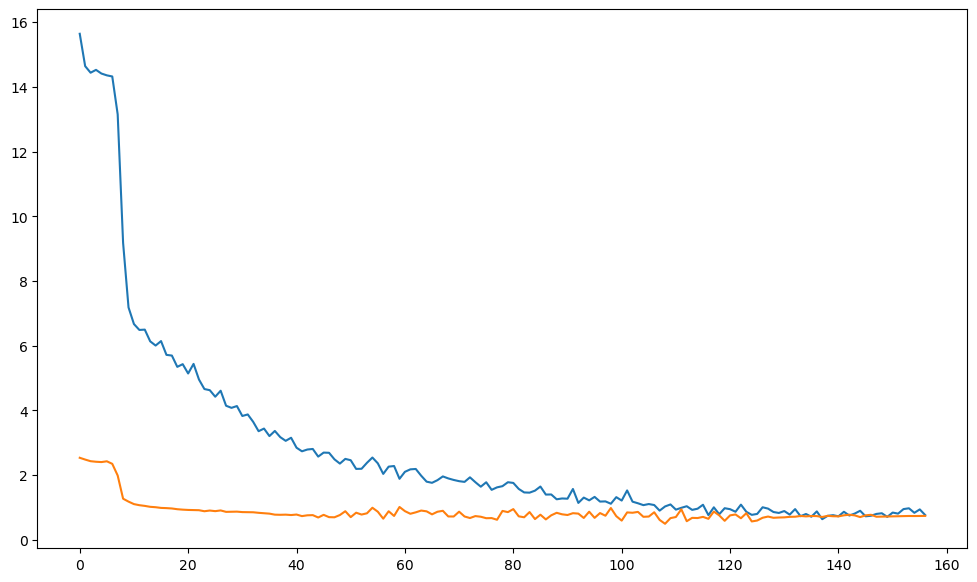

In [246]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

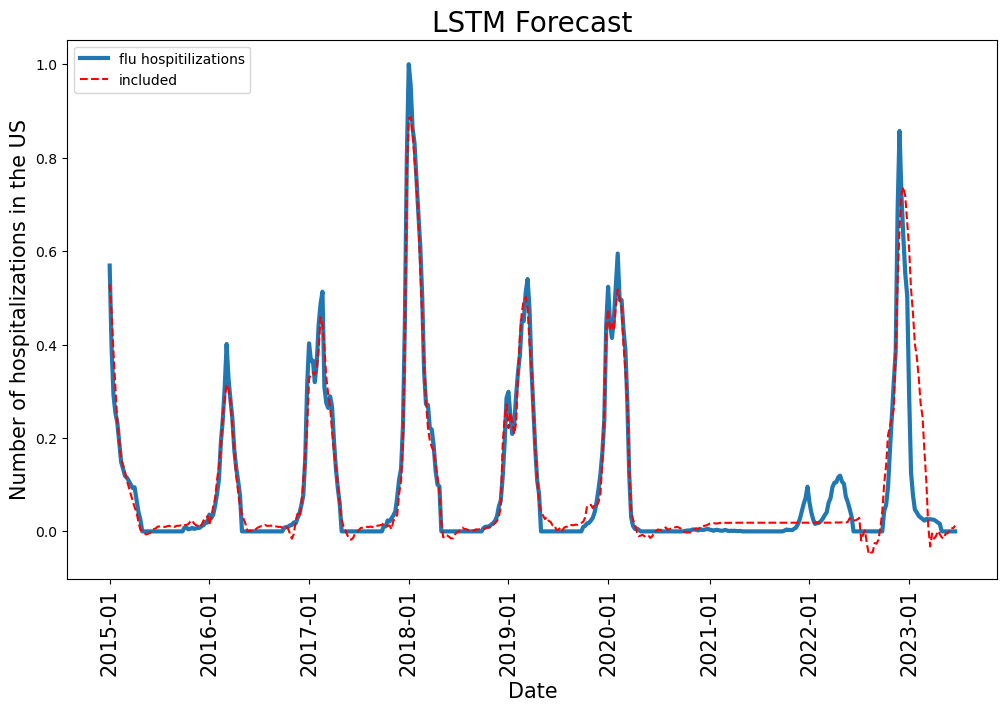

In [247]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [252]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_3lay_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-5
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [253]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 1.8387458389720006 Val loss: 0.00026585397426970303 Time: 1.3372520999982953
epoch 1 0 0
Train loss: 1.9555731828757348 Val loss: 0.00030274069285951555 Time: 1.2298987999965902
epoch 2 1 1
Train loss: 1.7365454488128051 Val loss: 0.0002683145576156676 Time: 1.209812500004773
epoch 3 0 0
Train loss: 2.1019258651491146 Val loss: 0.00026336798327974975 Time: 1.2161053000018
epoch 4 0 1
Train loss: 1.9792400785204478 Val loss: 0.0003150541160721332 Time: 1.2375700999982655
epoch 5 1 2
Train loss: 1.6189471088702523 Val loss: 0.00031368318013846874 Time: 1.1835738999943715
epoch 6 0 0
Train loss: 1.7152474610102075 Val loss: 0.0003187918337062001 Time: 1.2218685999978334
epoch 7 1 1
Train loss: 1.6700768739140017 Val loss: 0.0002770706487353891 Time: 1.233193099993514
epoch 8 0 2
Train loss: 1.8449526214500214 Val loss: 0.00031476642470806837 Time: 1.2683843999984674
epoch 9 1 3
Train loss: 1.4919003539056888 Val loss: 0.0003085126227233559 Time: 1.2657668000028934


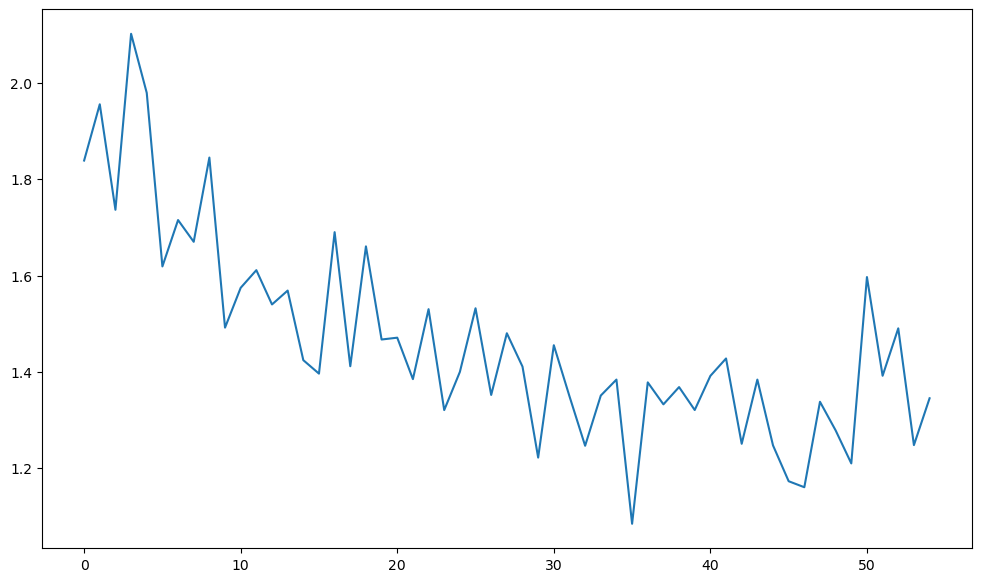

In [254]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

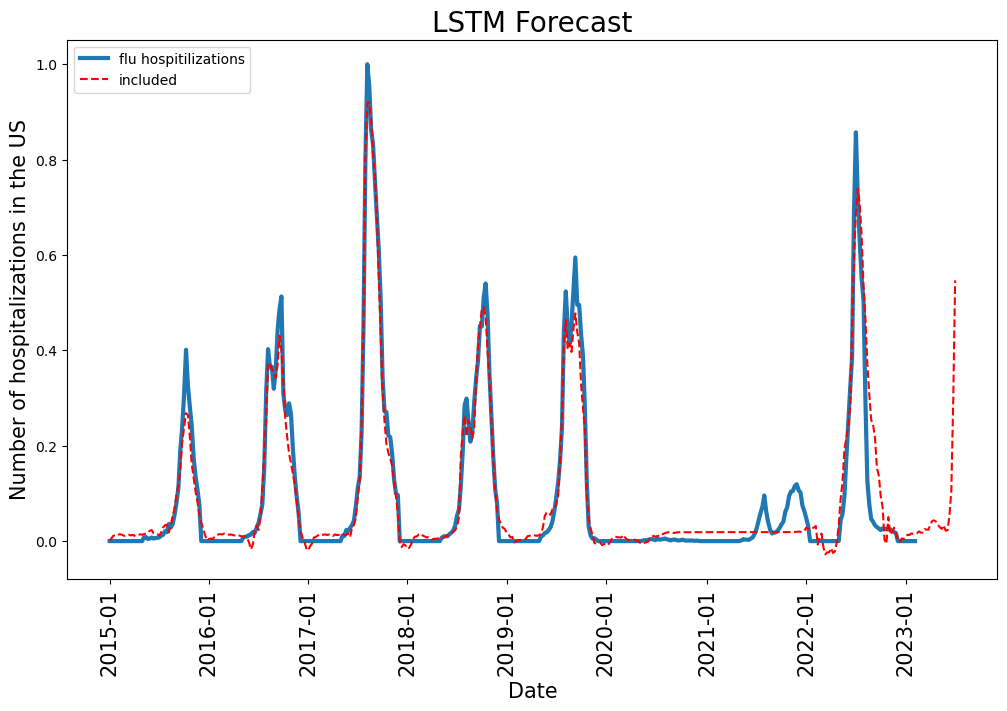

In [255]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# LSTM Drop B

In [88]:
class lstm_drop_2lin_B(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_drop_2lin_B, self).__init__()
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),

            nn.Linear(seq_len*country_len,seq_len*country_len),
            nn.Dropout(0.2),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(50,1)
        )        
        
    def forward(self, x):
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.lstm(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [427]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_drop_2lin_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [428]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.906023831884738 Val loss: 2.474667577949731 Time: 1.2336837999755517
epoch 1 0 0
Train loss: 14.51270654549285 Val loss: 2.436065703719123 Time: 1.2223898000083864
epoch 2 0 0
Train loss: 14.533764677393265 Val loss: 2.4304419308848537 Time: 1.1119026000087615
epoch 3 0 1
Train loss: 14.217895592407512 Val loss: 2.4357609325238627 Time: 1.1486781999992672
epoch 4 1 0
Train loss: 14.16516927361016 Val loss: 2.4235727011748622 Time: 1.1487637000100221
epoch 5 0 0
Train loss: 13.997338585352907 Val loss: 2.3002316404745216 Time: 1.1082475000002887
epoch 6 0 0
Train loss: 11.51894806904653 Val loss: 1.6760788732208312 Time: 1.1696471000032034
epoch 7 0 0
Train loss: 8.158038152766586 Val loss: 1.2160955306389951 Time: 1.1060223999957088
epoch 8 0 0
Train loss: 6.9500734816762275 Val loss: 1.102481932797673 Time: 1.0949239000037778
epoch 9 0 0
Train loss: 6.525263917922198 Val loss: 1.0402672061391058 Time: 1.214804599992931
epoch 10 0 0
Train loss: 6.360986775091

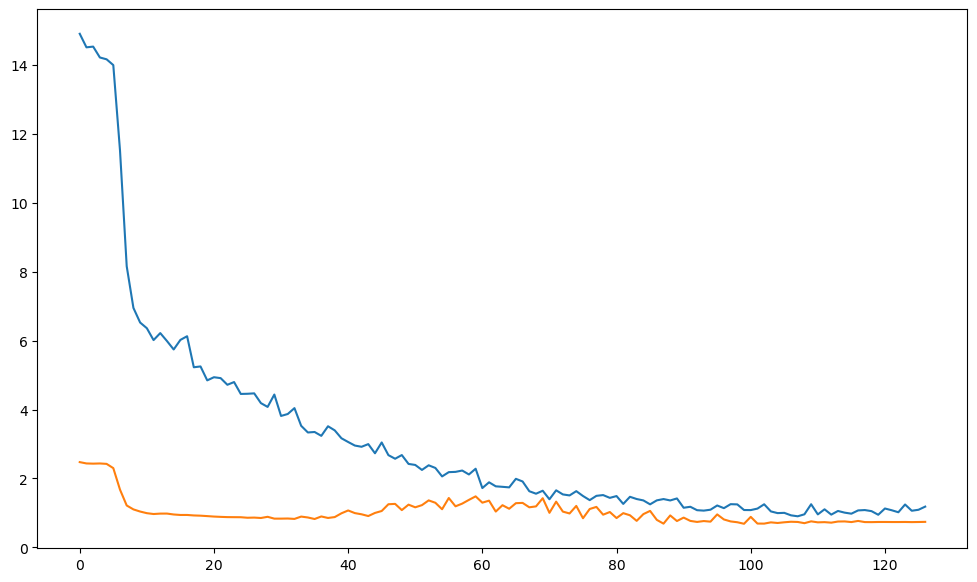

In [429]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

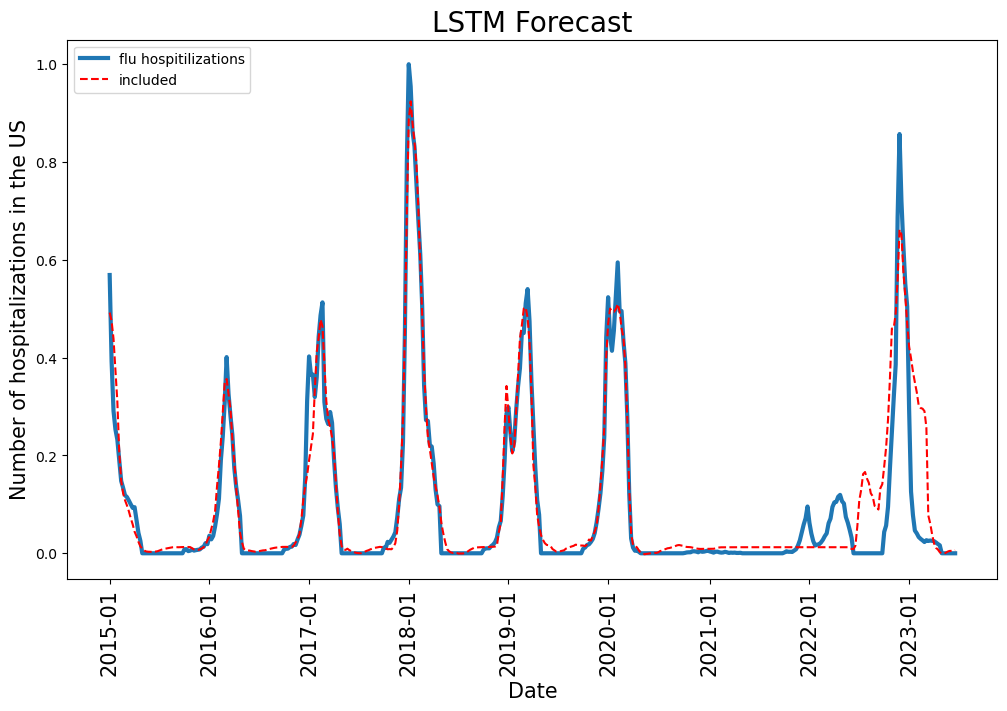

In [430]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [431]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_drop_2lin_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [432]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 2.0827606563932735 Val loss: 9.205852620652877e-06 Time: 1.322285300004296
epoch 1 0 0
Train loss: 2.1078264803115303 Val loss: 3.620132338255644e-05 Time: 1.3765276999911293
epoch 2 1 1
Train loss: 1.902839109637604 Val loss: 9.84642520052148e-06 Time: 1.211956699989969
epoch 3 0 0
Train loss: 1.8584264302310423 Val loss: 3.2168961752176983e-06 Time: 1.2076931000046898
epoch 4 0 0
Train loss: 1.9014087645116284 Val loss: 9.494008281762945e-07 Time: 1.2555073000257835
epoch 5 0 1
Train loss: 1.973427879800882 Val loss: 2.526153139115195e-06 Time: 1.5070201999915298
epoch 6 1 2
Train loss: 1.5065214560135818 Val loss: 5.212324595049722e-06 Time: 1.953349099989282
epoch 7 2 0
Train loss: 1.6208488415638203 Val loss: 1.7129644369617836e-09 Time: 1.161669900000561
epoch 8 0 1
Train loss: 1.3697415484188946 Val loss: 1.2902512935397681e-05 Time: 1.6189467999793123
epoch 9 1 0
Train loss: 1.590171267344981 Val loss: 7.762815243950172e-07 Time: 1.5036314000026323
epoch

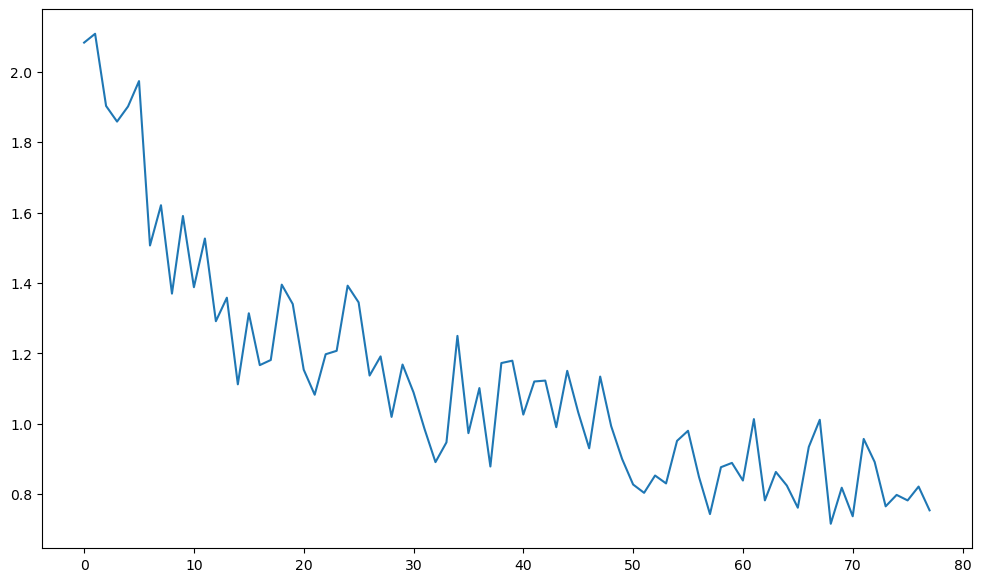

In [433]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

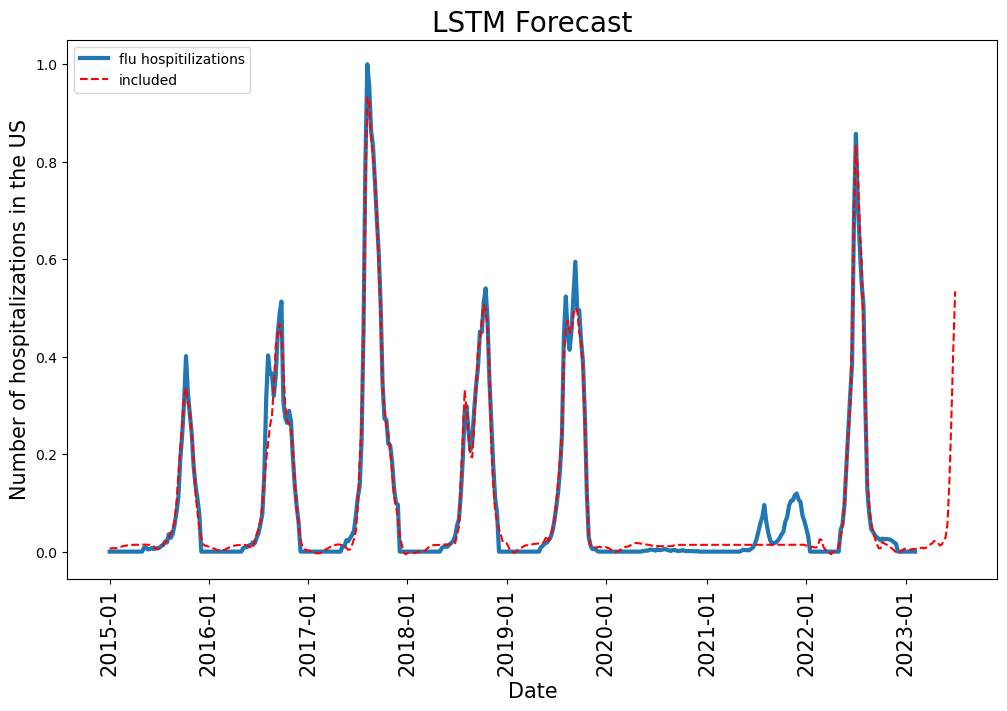

In [434]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# RNN

In [89]:
class rnn(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(rnn, self).__init__()
        
        
        
        self.rnn = nn.RNN(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.rnn(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.rnn(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23


In [218]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [219]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.878456700973203 Val loss: 2.4684392561757704 Time: 0.6207143999927212
epoch 1 0 0
Train loss: 14.659322500504004 Val loss: 2.4574582737113815 Time: 0.5841192999941995
epoch 2 0 0
Train loss: 13.501343980844894 Val loss: 2.4555363140057125 Time: 0.7982267999905162
epoch 3 0 0
Train loss: 11.99545332870241 Val loss: 2.2378325076788315 Time: 0.6931995000049938
epoch 4 0 0
Train loss: 9.140683449555667 Val loss: 1.8272286020801403 Time: 0.686082100000931
epoch 5 0 0
Train loss: 6.825535893624991 Val loss: 1.5836822150122316 Time: 0.6881438999989768
epoch 6 0 0
Train loss: 5.777285393962291 Val loss: 1.5115478423977038 Time: 0.8844074999942677
epoch 7 0 0
Train loss: 5.841412830452697 Val loss: 1.4313018083466886 Time: 1.4312666000041645
epoch 8 0 1
Train loss: 5.612082298057013 Val loss: 1.3949265231531172 Time: 1.5120734999945853
epoch 9 0 0
Train loss: 5.12429820490058 Val loss: 1.3402153368806466 Time: 1.3755909000028623
epoch 10 0 0
Train loss: 5.065187570246

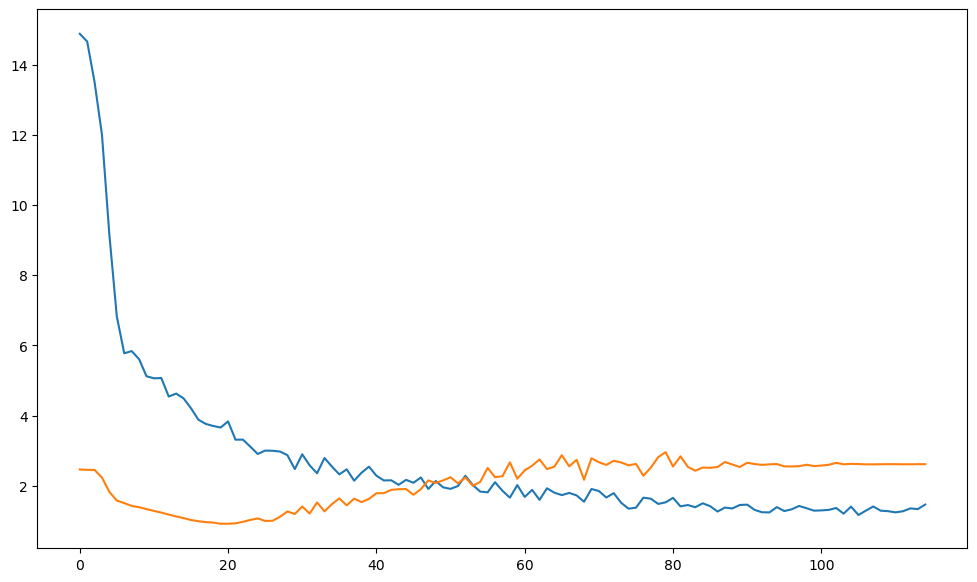

In [220]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

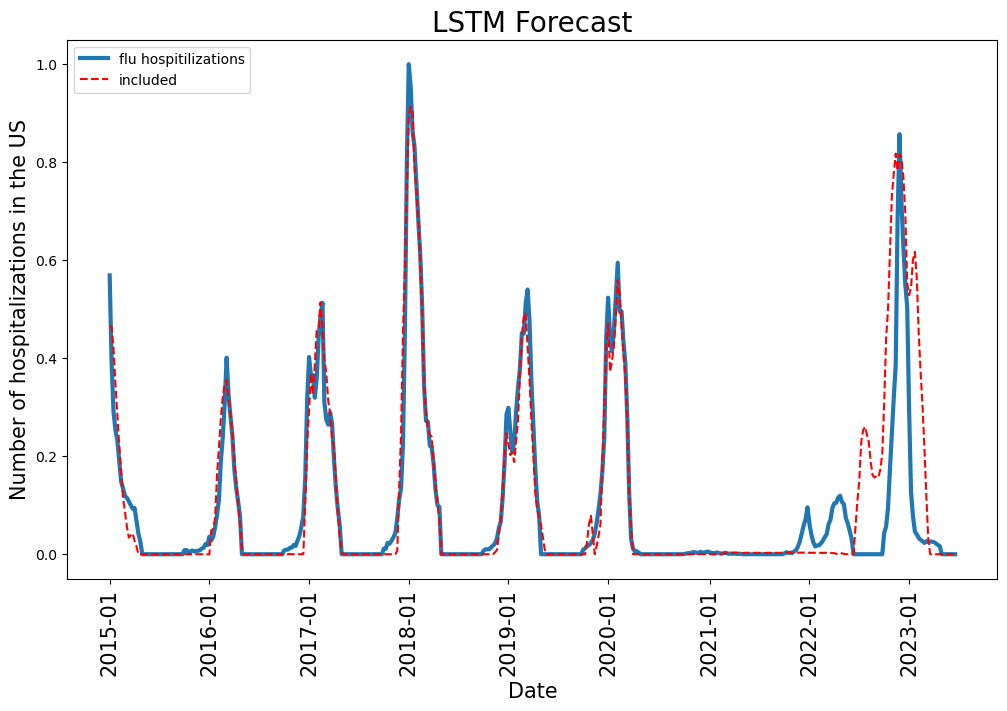

In [221]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [222]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [223]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 3.6566134806263904 Val loss: 0.0 Time: 0.8739204000012251
epoch 1 0 0
Train loss: 4.586134081622873 Val loss: 0.0 Time: 1.216451899992535
epoch 2 0 1
Train loss: 4.134623204598178 Val loss: 0.0 Time: 2.321623099996941
epoch 3 0 2
Train loss: 3.738876005228974 Val loss: 0.0 Time: 2.3279546999983722
epoch 4 0 3
Train loss: 3.245675600198183 Val loss: 0.0 Time: 2.111197500009439
epoch 5 0 0
Train loss: 3.1337331630619474 Val loss: 0.0 Time: 1.8705251999926986
epoch 6 0 0
Train loss: 3.1753938974745495 Val loss: 0.0 Time: 1.3681518999947002
epoch 7 0 1
Train loss: 3.1512081558120713 Val loss: 0.0 Time: 1.7320586999994703
epoch 8 0 2
Train loss: 2.77179720627338 Val loss: 0.0 Time: 1.7941446000040742
epoch 9 0 0
Train loss: 3.0610527753172114 Val loss: 0.0 Time: 1.8750719000090612
epoch 10 0 1
Train loss: 2.9060187232962815 Val loss: 0.0 Time: 1.8939906999876257
epoch 11 0 2
Train loss: 2.7989690148404804 Val loss: 0.0 Time: 1.8746609999943757
epoch 12 0 3
Train loss

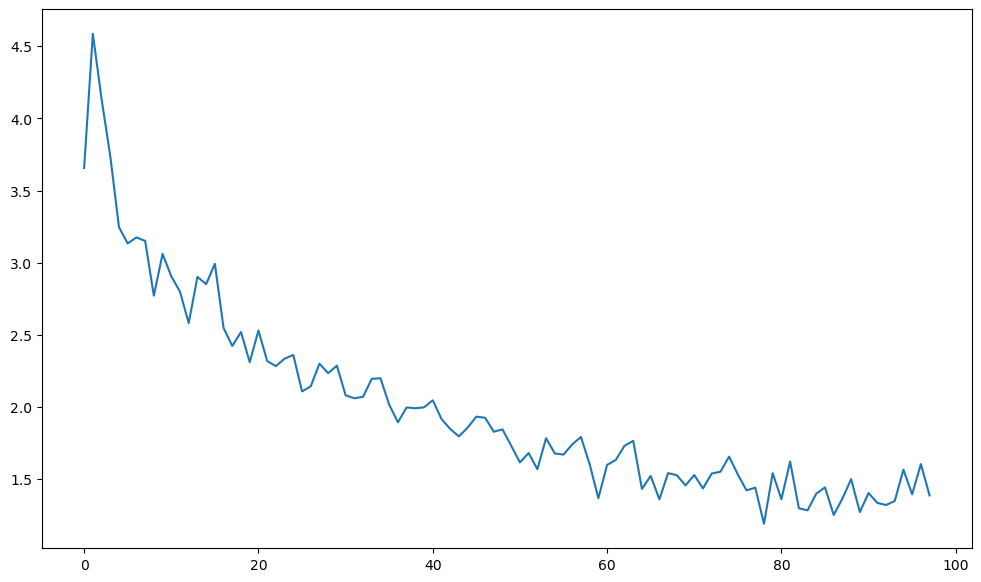

In [224]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

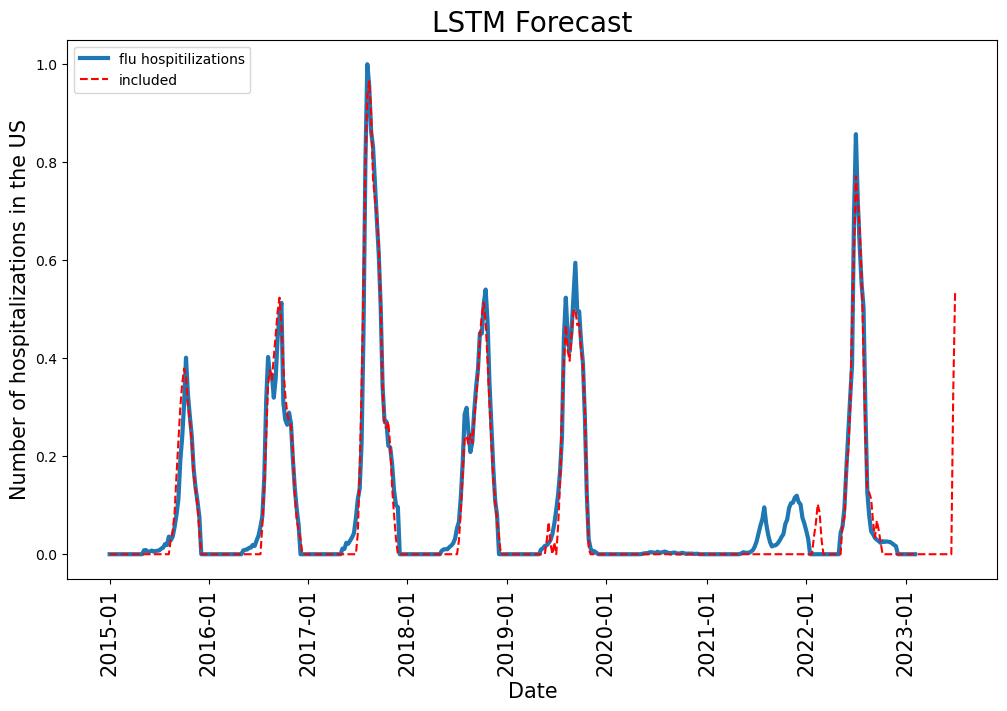

In [225]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# RNN - Linear - RNN - Linear - Linear

In [90]:
class rnn_drop(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(rnn_drop, self).__init__()
        
        
        
        self.rnn = nn.RNN(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.10),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.rnn(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.rnn(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [233]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [234]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.67013290901184 Val loss: 2.49305013155481 Time: 0.8590458000107901
epoch 1 0 0
Train loss: 13.6510688798421 Val loss: 2.1761251155039645 Time: 0.732318900001701
epoch 2 0 0
Train loss: 10.926237007471912 Val loss: 1.4255645419470966 Time: 0.7072556000057375
epoch 3 0 0
Train loss: 7.313971976731038 Val loss: 0.9885358265455579 Time: 1.03425789999892
epoch 4 0 0
Train loss: 6.039301469059438 Val loss: 0.9232140918538789 Time: 1.7374861999996938
epoch 5 0 0
Train loss: 5.947542776954204 Val loss: 0.8790995245607292 Time: 1.9086281999916537
epoch 6 0 0
Train loss: 5.596555538747133 Val loss: 0.816692892744868 Time: 1.6521779999893624
epoch 7 0 0
Train loss: 5.269201268672923 Val loss: 0.8104084284495912 Time: 1.4452167999988887
epoch 8 0 0
Train loss: 5.277788675689294 Val loss: 0.8002324509980099 Time: 1.3512547999998787
epoch 9 0 1
Train loss: 4.9713353541034735 Val loss: 0.7905415896876775 Time: 1.4767541000037454
epoch 10 0 0
Train loss: 4.953714557481607 Va

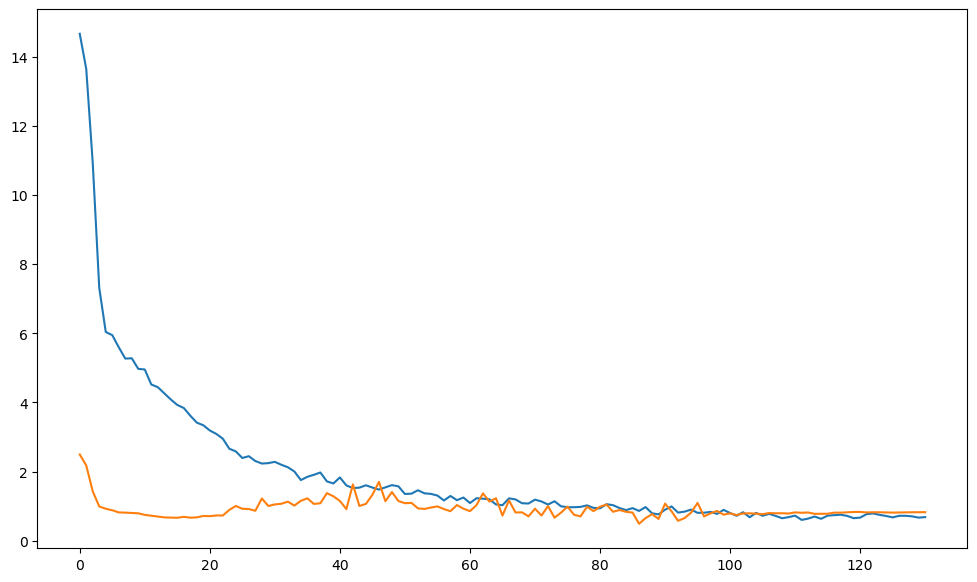

In [235]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

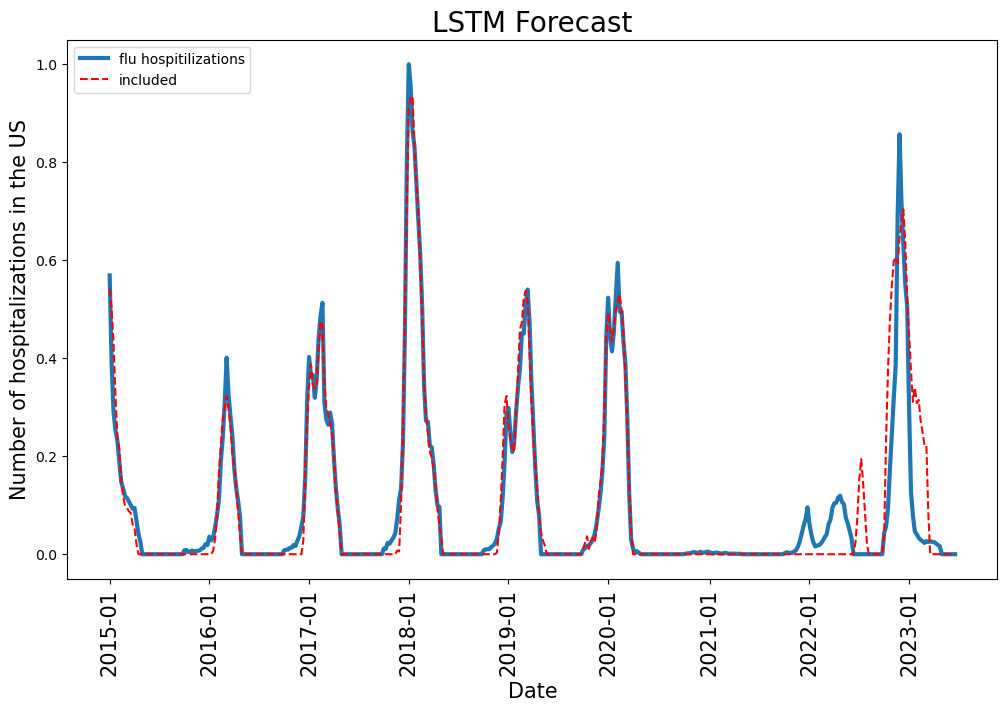

In [236]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [237]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [238]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 1.6447481432333995 Val loss: 0.0 Time: 0.7791876999981469
epoch 1 0 0
Train loss: 2.1518866640042096 Val loss: 0.0 Time: 0.8039053999964381
epoch 2 0 1
Train loss: 1.8037021994176712 Val loss: 0.0 Time: 0.780688500002725
epoch 3 0 2
Train loss: 1.5751220202926248 Val loss: 0.0 Time: 0.7888264000066556
epoch 4 0 0
Train loss: 1.4401645790111672 Val loss: 0.0 Time: 1.2307100999896647
epoch 5 0 0
Train loss: 1.3649955815167125 Val loss: 0.0 Time: 2.140879099999438
epoch 6 0 0
Train loss: 1.3902628994325044 Val loss: 0.0 Time: 1.8154907999996794
epoch 7 0 1
Train loss: 1.2781522295228953 Val loss: 0.0 Time: 1.6517679000098724
epoch 8 0 0
Train loss: 1.0658344071381691 Val loss: 0.0 Time: 1.6742453999904683
epoch 9 0 0
Train loss: 1.1469611489790168 Val loss: 0.0 Time: 1.6346829999965848
epoch 10 0 1
Train loss: 0.9905973448136685 Val loss: 0.0 Time: 1.67725700000301
epoch 11 0 0
Train loss: 1.1110259889511553 Val loss: 0.0 Time: 1.474868699995568
epoch 12 0 1
Train 

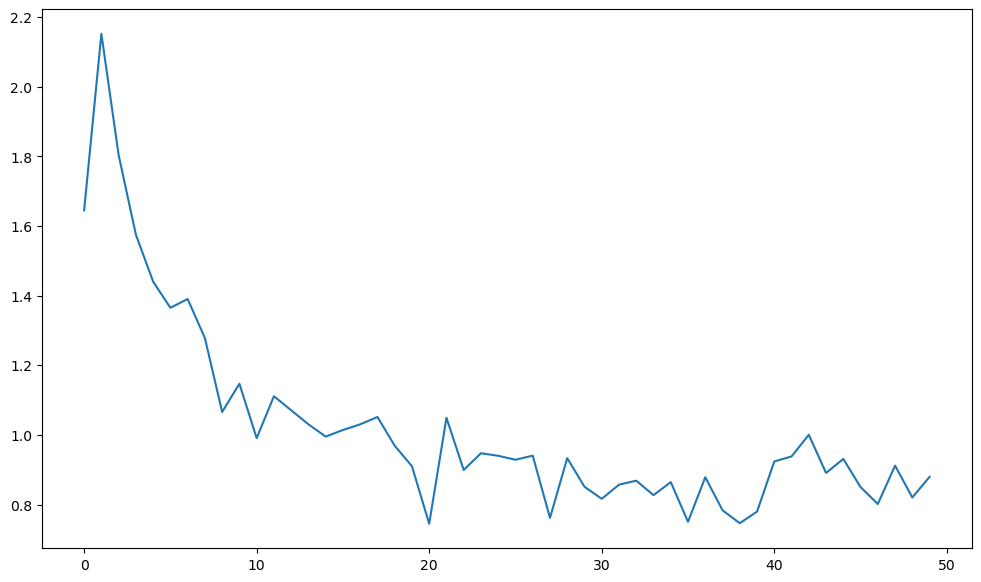

In [239]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

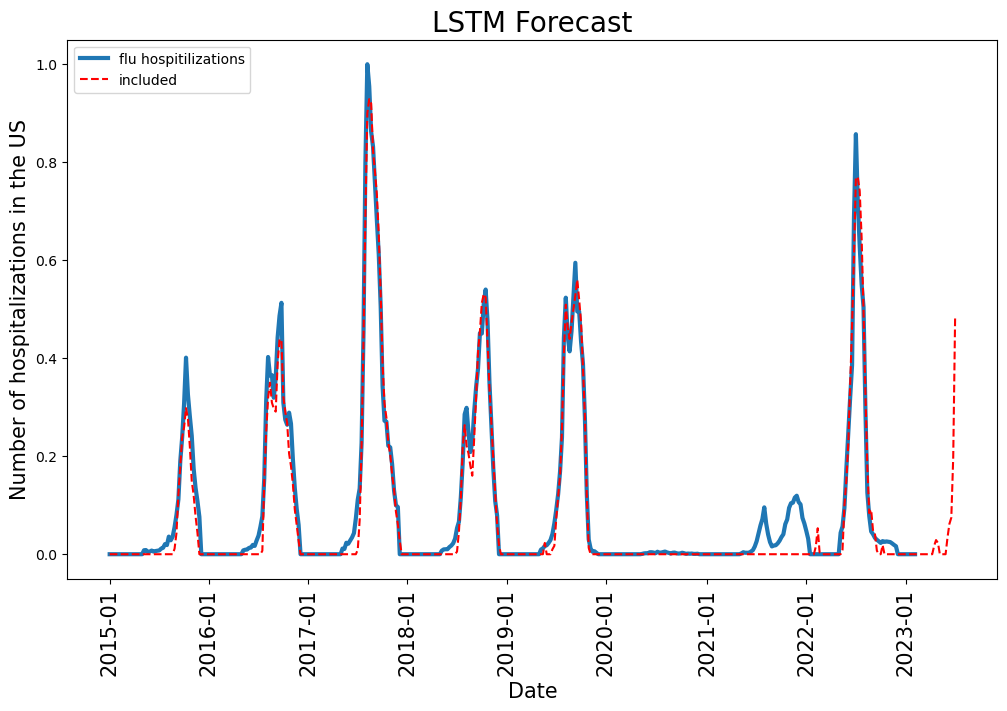

In [240]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# (throwout) RNN - Linear - RNN - Linear - RNN - Linear - Linear

In [29]:
class rnn_3lay_drop(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(rnn_3lay_drop, self).__init__()
        
        self.rnn= nn.RNN(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):
        
        logits, _ = self.rnn(x.permute(0,2,1))
        logits = self.enc(logits)
        logits, _ = self.rnn(logits)
        logits = self.enc(logits)
        logits, _ = self.rnn(logits)
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [287]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = rnn_3lay_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [288]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.84235290859408 Val loss: 2.4669359315594193 Time: 1.0126543999940623
epoch 1 0 0
Train loss: 14.59923579669362 Val loss: 2.469783471595292 Time: 0.9703824999887729
epoch 2 1 0
Train loss: 14.333768513452487 Val loss: 2.5063716435834067 Time: 0.9119692999956897
epoch 3 2 0
Train loss: 12.911013382471538 Val loss: 2.3039807383029256 Time: 0.8781950999982655
epoch 4 0 0
Train loss: 8.017905604346993 Val loss: 1.7002734677407716 Time: 0.8681034000037471
epoch 5 0 0
Train loss: 6.507906748702485 Val loss: 1.5589904235093854 Time: 0.8531914000050165
epoch 6 0 0
Train loss: 5.980430119595951 Val loss: 1.4716719124699011 Time: 0.8514543999917805
epoch 7 0 0
Train loss: 5.714708172188033 Val loss: 1.4332849291167804 Time: 0.8537637999979779
epoch 8 0 0
Train loss: 5.4563512072403135 Val loss: 1.3613175662758294 Time: 0.8323628000071039
epoch 9 0 0
Train loss: 5.139788991617493 Val loss: 1.3540402514045127 Time: 0.8537027999991551
epoch 10 0 0
Train loss: 4.99755688804

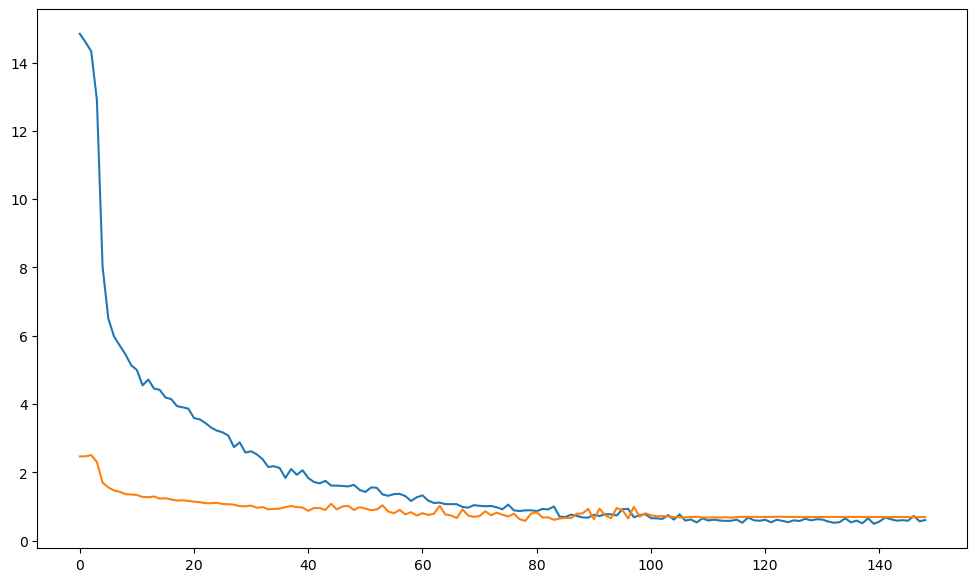

In [289]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

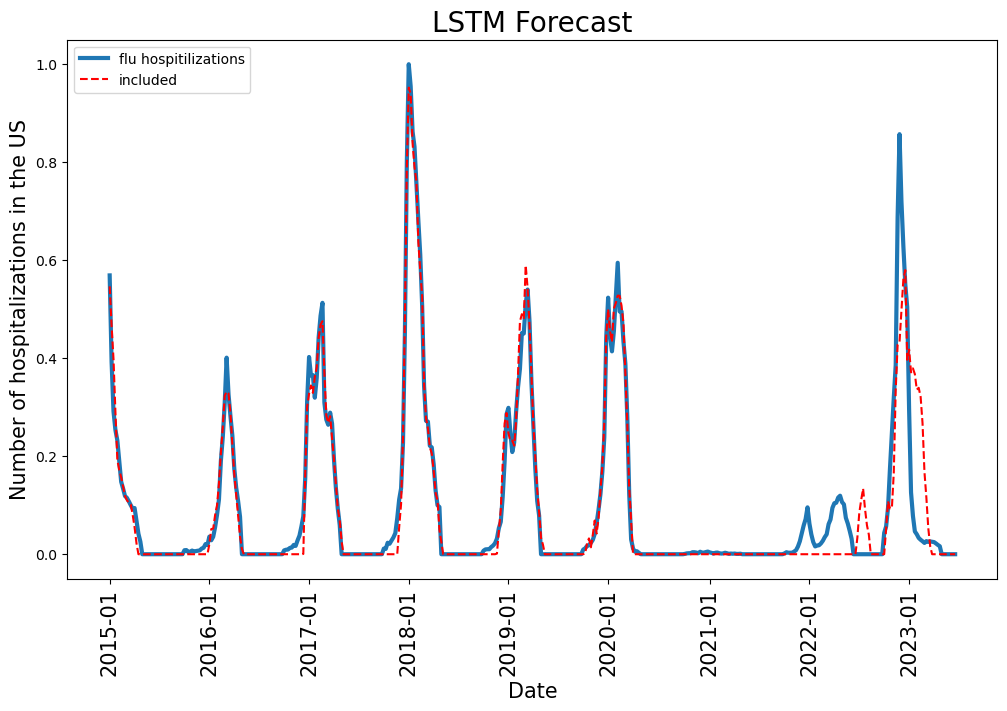

In [290]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# (throwout) LSTM - CNN - LSTM - Linear - Linear

In [30]:
class lstm_cnn_drop(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_cnn_drop, self).__init__()
        
        
        self.convo = nn.Sequential(
           # nn.Flatten(start_dim =2, end_dim = -1),
            nn.ConstantPad1d(1,0),
            nn.Conv1d(seq_len,seq_len,kernel_size=3),
            nn.ReLU()
        )
        self.lstm = nn.RNN(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(seq_len*country_len,50),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(50,1)
        )      
        
    def forward(self, x):

        
        
        logits, _ = self.lstm(x.permute(0,2,1))
        logits = self.convo(logits.permute(0,2,1))
        #logits = self.enc(logits.permute(0,2,1))
        logits, _ = self.lstm(logits.permute(0,2,1))
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [305]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_cnn_drop(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [306]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 13.939937815734243 Val loss: 2.2507799054474162 Time: 0.8863917999988189
epoch 1 0 0
Train loss: 10.034807140646343 Val loss: 1.4975162275950424 Time: 0.8358879000006709
epoch 2 0 0
Train loss: 7.251813576287587 Val loss: 1.2617370125080924 Time: 0.8120807000086643
epoch 3 0 0
Train loss: 6.563257614370107 Val loss: 1.0513510404434783 Time: 0.8341593999939505
epoch 4 0 0
Train loss: 6.0526494223650245 Val loss: 0.9892818273947341 Time: 0.8431018999981461
epoch 5 0 0
Train loss: 5.968262235159144 Val loss: 0.9788839965476654 Time: 0.8251586999977008
epoch 6 0 0
Train loss: 5.64641877848577 Val loss: 0.964048321631708 Time: 0.8452706999960355
epoch 7 0 0
Train loss: 5.474495255740529 Val loss: 0.9528281025982324 Time: 0.8263267000002088
epoch 8 0 0
Train loss: 5.167708425276494 Val loss: 0.968393207549525 Time: 0.8576551000005566
epoch 9 1 0
Train loss: 4.641523867930384 Val loss: 0.9793834286210767 Time: 0.8072675000003073
epoch 10 2 0
Train loss: 4.6595164011335

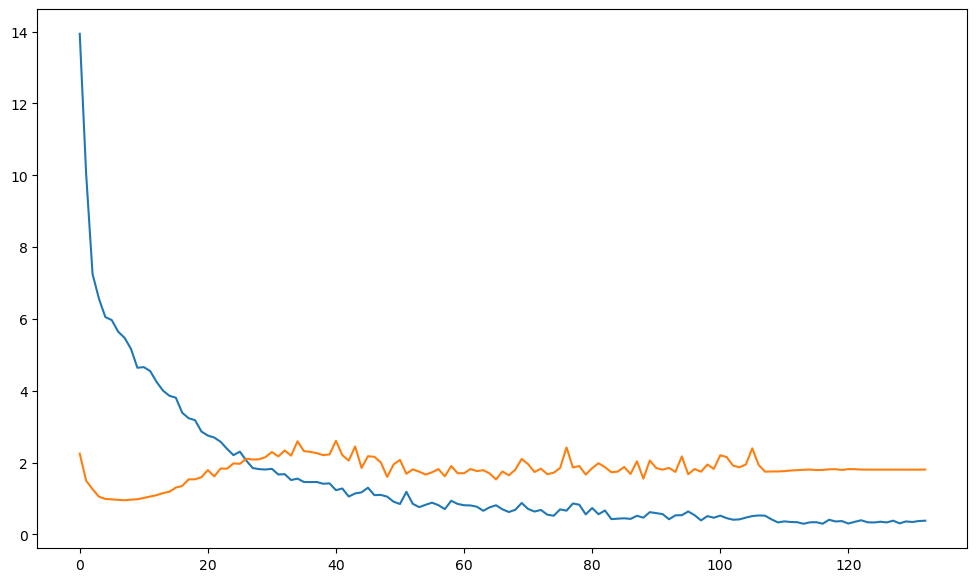

In [307]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

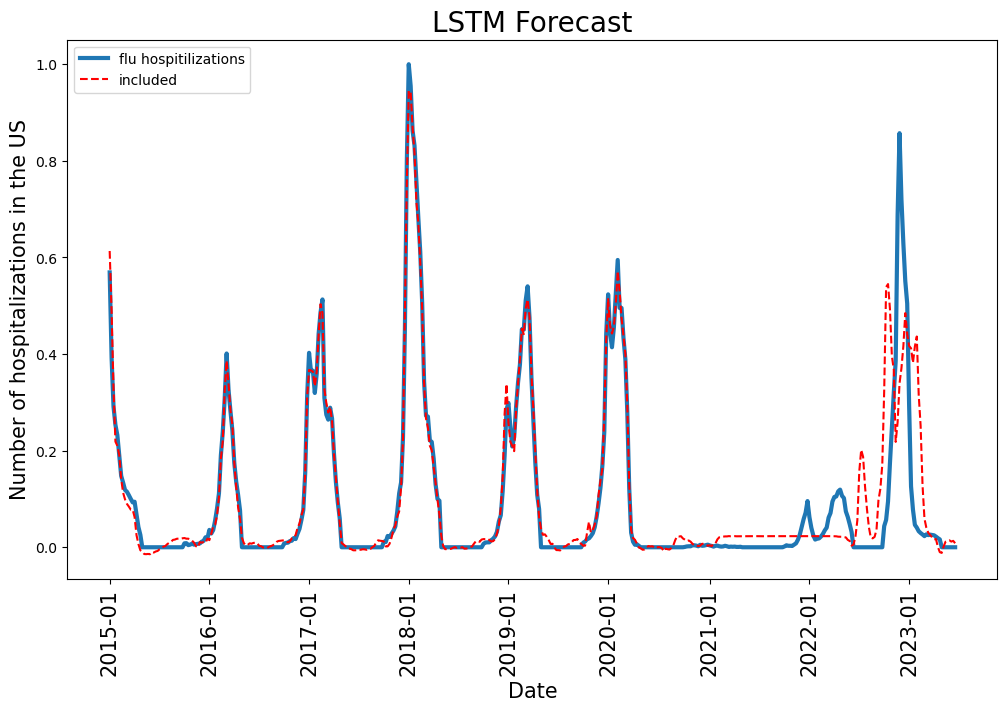

In [308]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# (throwout) CNN

In [31]:
class cnn(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(cnn, self).__init__()
        
        
        self.convo = nn.Sequential(
           # nn.Flatten(start_dim =2, end_dim = -1),
            nn.ConstantPad1d(1,0),
            nn.Conv1d(seq_len,seq_len,kernel_size=2),
            #nn.MaxPool1d(country_len, stride=2),
            nn.ReLU()
        )
        

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
           
            nn.Linear(156,50),

            nn.ReLU(),

            nn.Dropout(0.2),

            nn.Linear(50,1),

            nn.ReLU()
        )      
        
    def forward(self, x):

        
        
      
        logits = self.convo(x)
        
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [366]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [367]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 12.55244577092295 Val loss: 1.7968160058226204 Time: 0.5383514999994077
epoch 1 0 0
Train loss: 7.721058352563672 Val loss: 1.2122177275764443 Time: 0.48752799999783747
epoch 2 0 0
Train loss: 5.786258335165101 Val loss: 1.1252273553982377 Time: 0.48650160001125187
epoch 3 0 0
Train loss: 5.17108197182683 Val loss: 0.9864522702082468 Time: 0.4457012999919243
epoch 4 0 0
Train loss: 4.971708989417337 Val loss: 0.9704013672726433 Time: 0.5079980000155047
epoch 5 0 0
Train loss: 4.478293811267626 Val loss: 0.9165110829053447 Time: 0.43655679997755215
epoch 6 0 0
Train loss: 4.351068542256725 Val loss: 0.921675101144956 Time: 0.4517508999851998
epoch 7 1 0
Train loss: 3.8304702418171956 Val loss: 0.8984784411106128 Time: 0.45468119997531176
epoch 8 0 0
Train loss: 3.738543484316182 Val loss: 0.9910908391466364 Time: 0.451075100019807
epoch 9 1 0
Train loss: 3.2177988935378123 Val loss: 0.9461376389954239 Time: 0.4601058999833185
epoch 10 0 0
Train loss: 2.9162230164

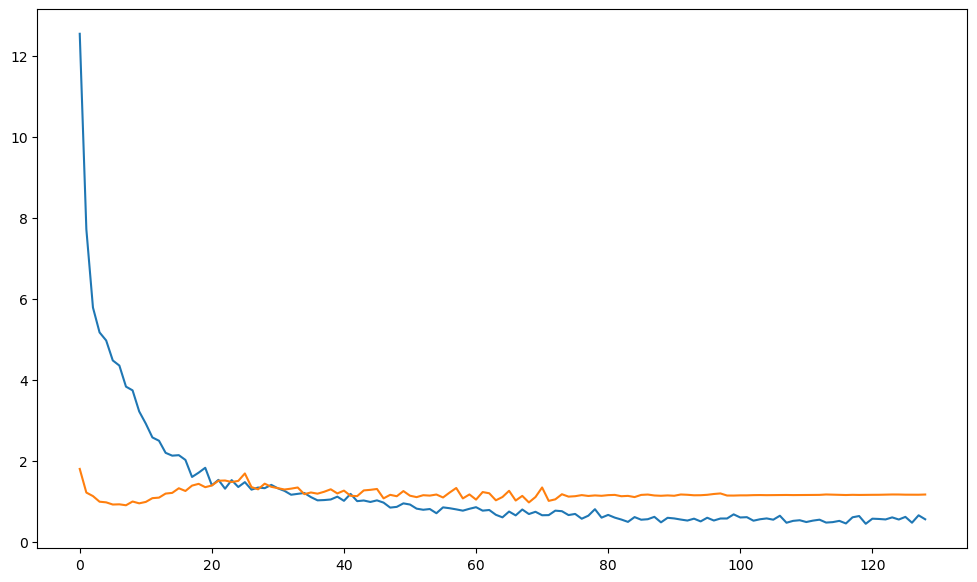

In [368]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

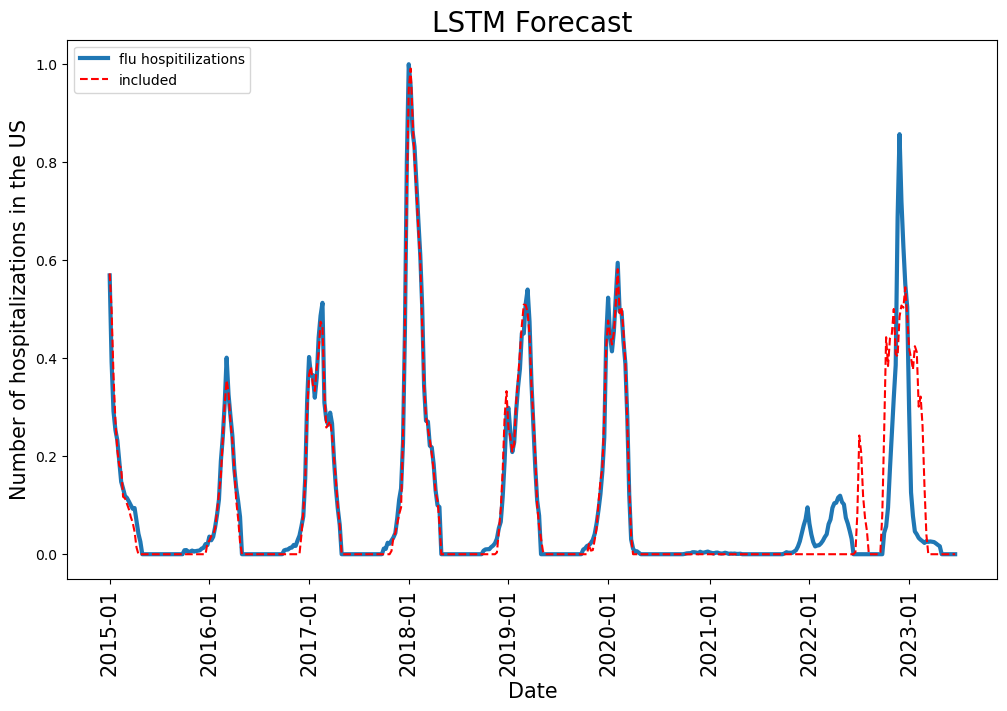

In [369]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# LSTM_B

In [95]:
class lstm_B(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_B, self).__init__()
        
        
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [376]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [377]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.45957625152522 Val loss: 2.143606121491757 Time: 0.5850255999830551
epoch 1 0 0
Train loss: 12.171776478667947 Val loss: 1.8102082209952641 Time: 0.5410857000097167
epoch 2 0 0
Train loss: 10.598930617019562 Val loss: 1.5787380034453236 Time: 0.49303949999739416
epoch 3 0 0
Train loss: 8.805218044706635 Val loss: 1.367655384932732 Time: 0.4849736999894958
epoch 4 0 0
Train loss: 7.443755582226027 Val loss: 1.2133783997123828 Time: 0.4963867000187747
epoch 5 0 0
Train loss: 6.4615746647605565 Val loss: 1.1433320906944573 Time: 0.5040769999905024
epoch 6 0 0
Train loss: 5.908591702782132 Val loss: 1.1165823108167388 Time: 0.5013245999871287
epoch 7 0 0
Train loss: 5.772362377249247 Val loss: 1.1115055484697223 Time: 0.4830962999840267
epoch 8 0 0
Train loss: 5.576106886502462 Val loss: 1.1119540936488193 Time: 0.5011172000085935
epoch 9 1 0
Train loss: 5.424236078782343 Val loss: 1.1207420400023693 Time: 0.48003520001657307
epoch 10 2 0
Train loss: 5.3483813152

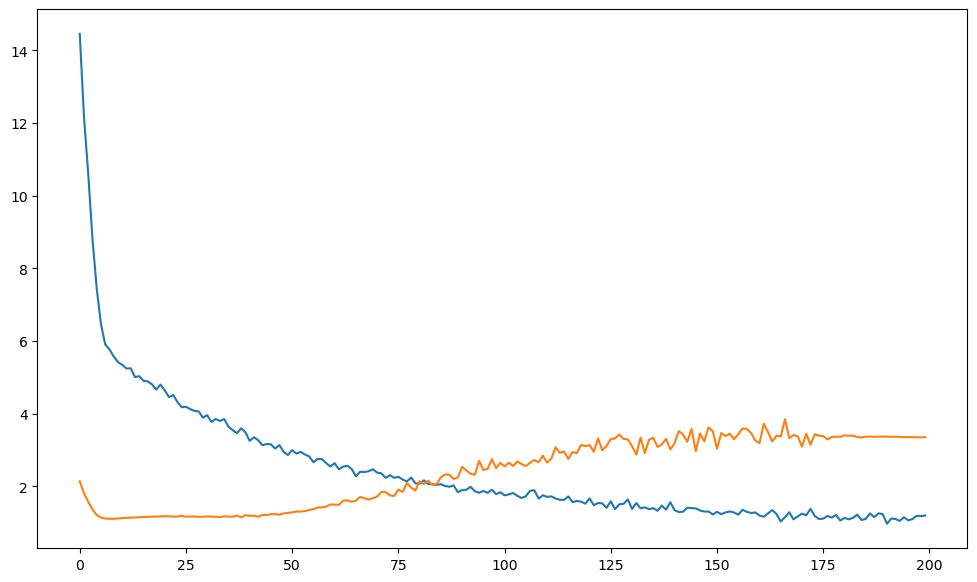

In [378]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

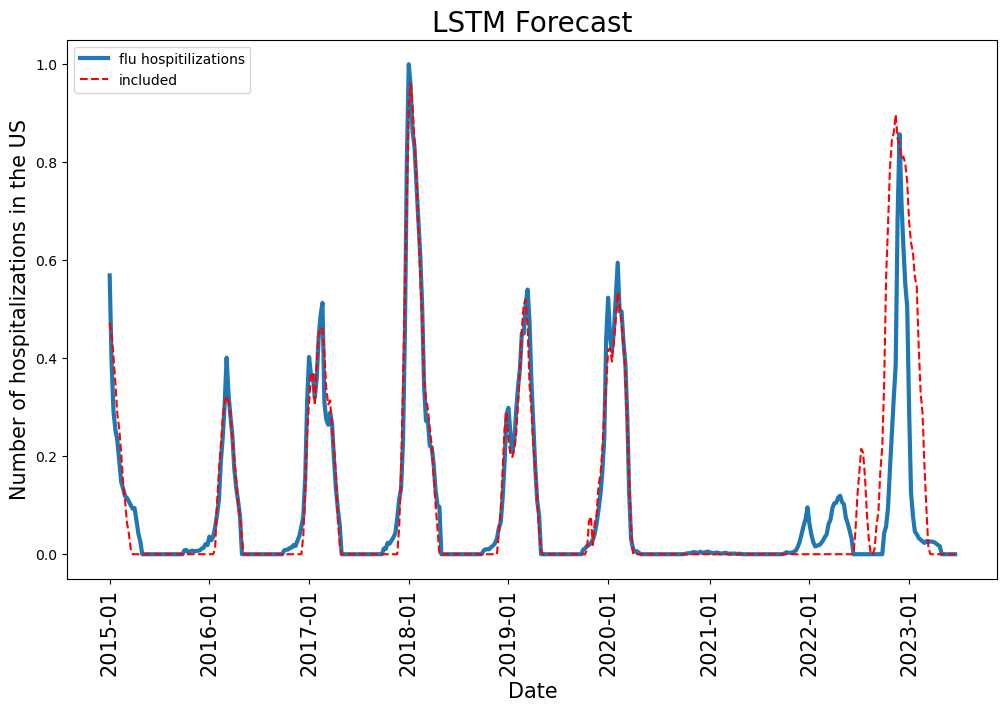

In [379]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [380]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [381]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 4.508131090141035 Val loss: 0.0 Time: 0.5602349000109825
epoch 1 0 0
Train loss: 4.613195320510613 Val loss: 0.0 Time: 0.5727226000162773
epoch 2 0 1
Train loss: 3.6935943357549093 Val loss: 0.0 Time: 0.5574684000166599
epoch 3 0 0
Train loss: 3.4996776518977697 Val loss: 0.0 Time: 0.5434031000186224
epoch 4 0 0
Train loss: 3.106901892479102 Val loss: 0.0 Time: 0.5513437999761663
epoch 5 0 0
Train loss: 3.3199393726520157 Val loss: 0.0 Time: 0.5338526999985334
epoch 6 0 1
Train loss: 3.092649944648544 Val loss: 0.0 Time: 0.5418788999959361
epoch 7 0 0
Train loss: 2.755854109971011 Val loss: 0.0 Time: 0.5672565999848302
epoch 8 0 0
Train loss: 2.834546090835463 Val loss: 0.0 Time: 0.5308917000074871
epoch 9 0 1
Train loss: 2.8746005611322403 Val loss: 0.0 Time: 0.5349736000061966
epoch 10 0 2
Train loss: 2.5872546404835077 Val loss: 0.0 Time: 0.5391308999969624
epoch 11 0 0
Train loss: 2.476873978451146 Val loss: 0.0 Time: 0.5367590999812819
epoch 12 0 0
Train lo

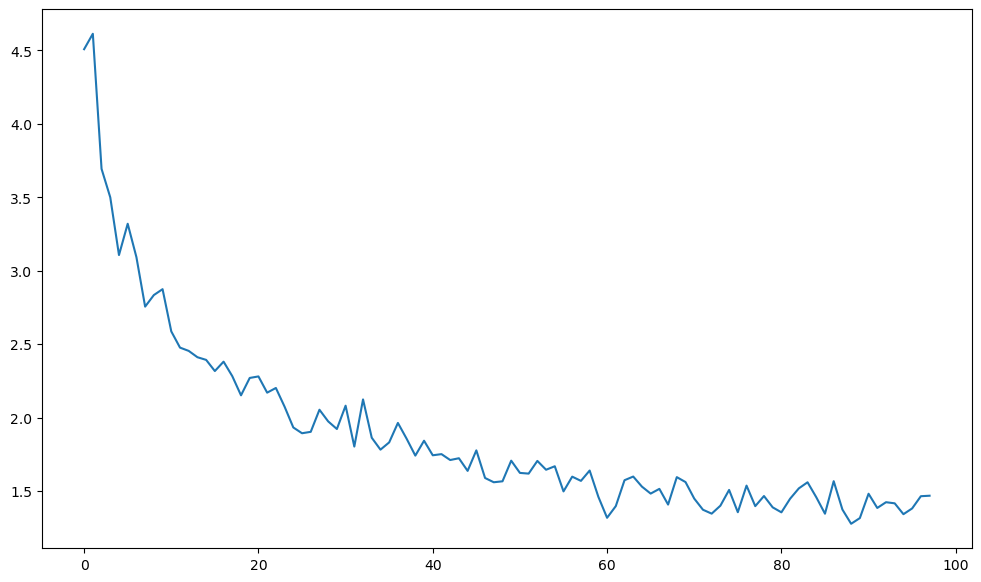

In [382]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

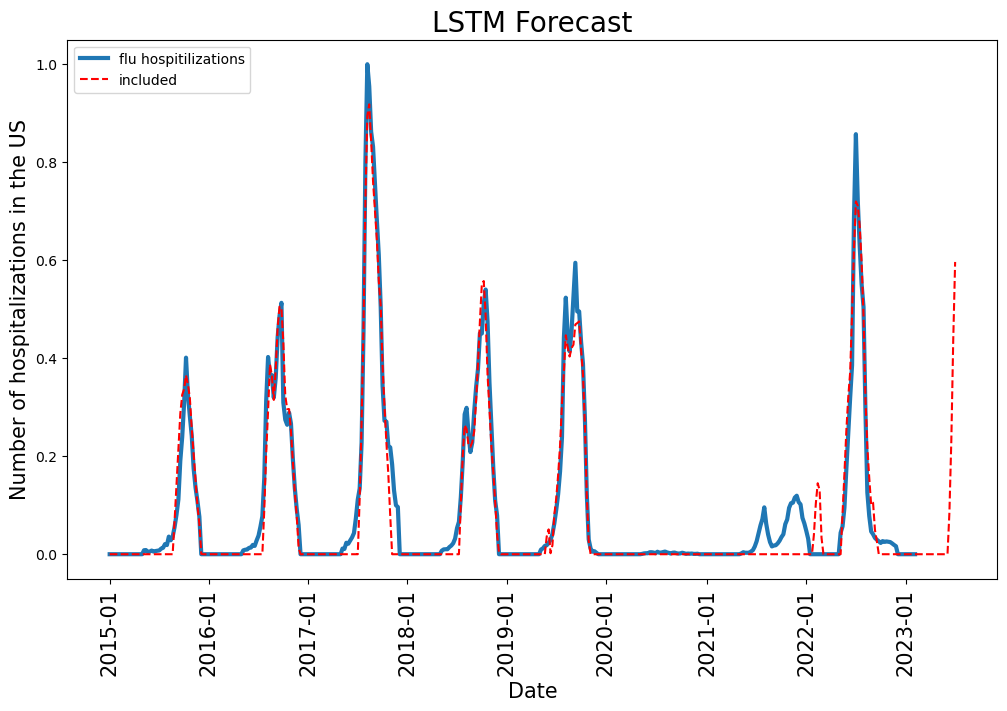

In [383]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# LSTM drop B

In [91]:
class lstm_drop_B(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_drop_B, self).__init__()
        
        
        
        self.lstm = nn.LSTM(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(seq_len*country_len,50),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [388]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_drop_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [389]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 13.663493631436822 Val loss: 2.1432438698684564 Time: 0.707029799988959
epoch 1 0 0
Train loss: 11.208617516340013 Val loss: 1.700732502504252 Time: 0.7807484999939334
epoch 2 0 0
Train loss: 8.336238345856941 Val loss: 1.294465434664744 Time: 0.7152484999969602
epoch 3 0 0
Train loss: 6.534247813713037 Val loss: 1.1478548979571315 Time: 0.6879143000114709
epoch 4 0 0
Train loss: 6.061739507224262 Val loss: 1.1018077500048093 Time: 0.6435849000117742
epoch 5 0 0
Train loss: 5.587157476688908 Val loss: 1.060940815252252 Time: 0.6755668999976479
epoch 6 0 0
Train loss: 5.577879028531669 Val loss: 1.0388934250513557 Time: 0.6641699000028893
epoch 7 0 0
Train loss: 5.21452303898715 Val loss: 1.0636334154929727 Time: 0.6503322000207845
epoch 8 1 0
Train loss: 5.132769872566762 Val loss: 1.0238779375090417 Time: 0.6780283999978565
epoch 9 0 0
Train loss: 4.979326736187005 Val loss: 1.0966259879860445 Time: 0.6734070999955293
epoch 10 1 0
Train loss: 4.733656805994318 

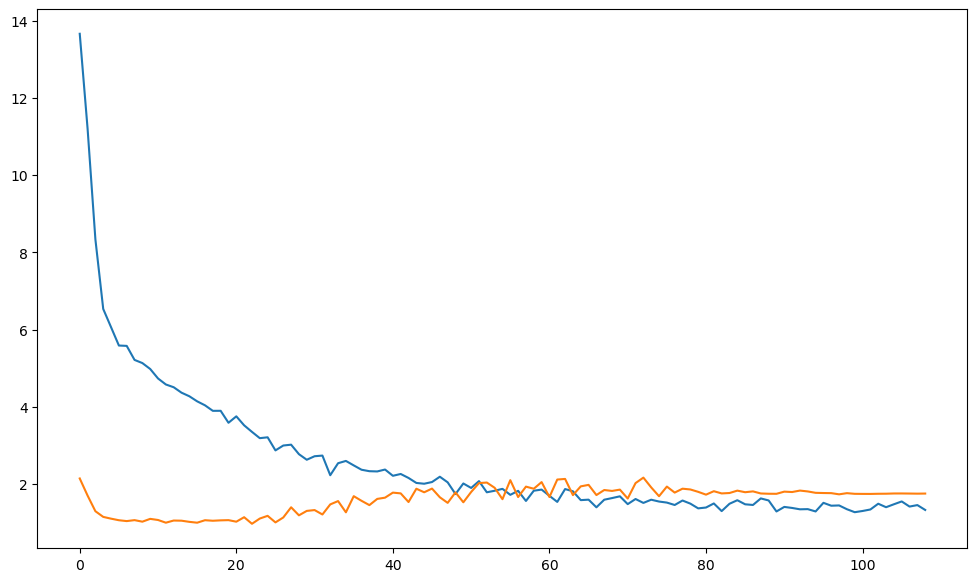

In [390]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

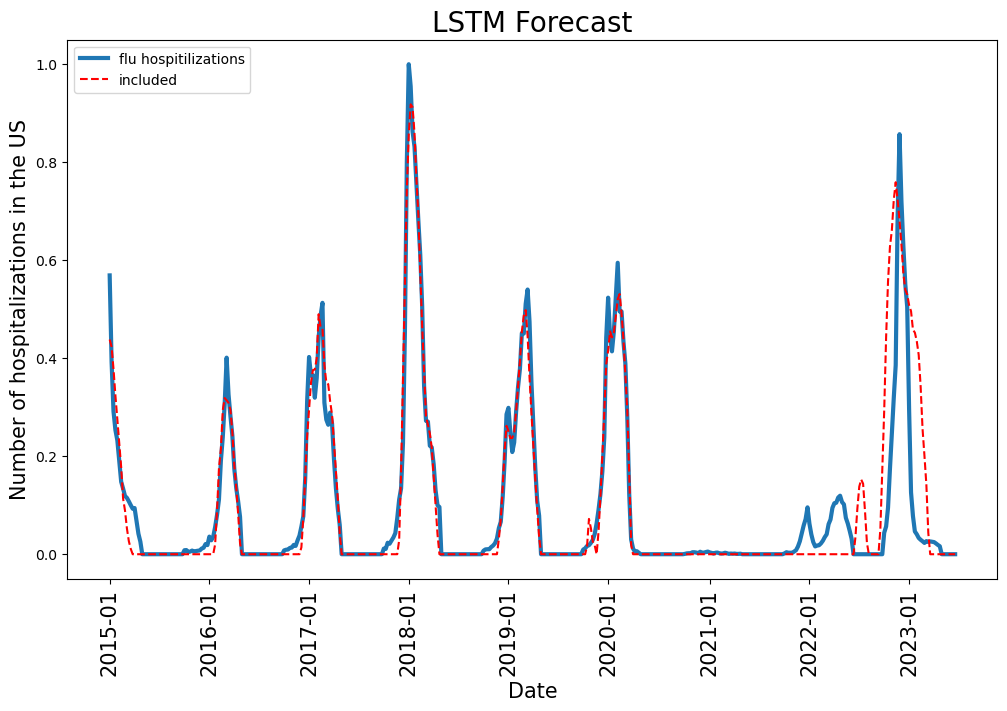

In [391]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [392]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_drop_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [393]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 3.265979280602422 Val loss: 0.0 Time: 0.7741962999862153
epoch 1 0 0
Train loss: 3.3388491178790014 Val loss: 0.0 Time: 0.7843374999938533
epoch 2 0 1
Train loss: 3.1630859285386066 Val loss: 0.0 Time: 0.7424170000012964
epoch 3 0 0
Train loss: 2.979262298961544 Val loss: 0.0 Time: 0.7391646999749355
epoch 4 0 0
Train loss: 2.78595056032529 Val loss: 0.0 Time: 0.7822390000219457
epoch 5 0 0
Train loss: 2.594342399761217 Val loss: 0.0 Time: 0.7680143999750726
epoch 6 0 0
Train loss: 2.5787896888534476 Val loss: 0.0 Time: 0.7031438999983948
epoch 7 0 0
Train loss: 2.433245405470757 Val loss: 0.0 Time: 0.7022694000042975
epoch 8 0 0
Train loss: 2.208609108118699 Val loss: 0.0 Time: 0.723098199989181
epoch 9 0 0
Train loss: 2.617651304196329 Val loss: 0.0 Time: 0.7587867999973241
epoch 10 0 1
Train loss: 2.3870763793300718 Val loss: 0.0 Time: 0.7515048999921419
epoch 11 0 2
Train loss: 2.0417724284488656 Val loss: 0.0 Time: 0.7266436999780126
epoch 12 0 0
Train loss

(1370,)


Text(0.5, 0, 'Date')

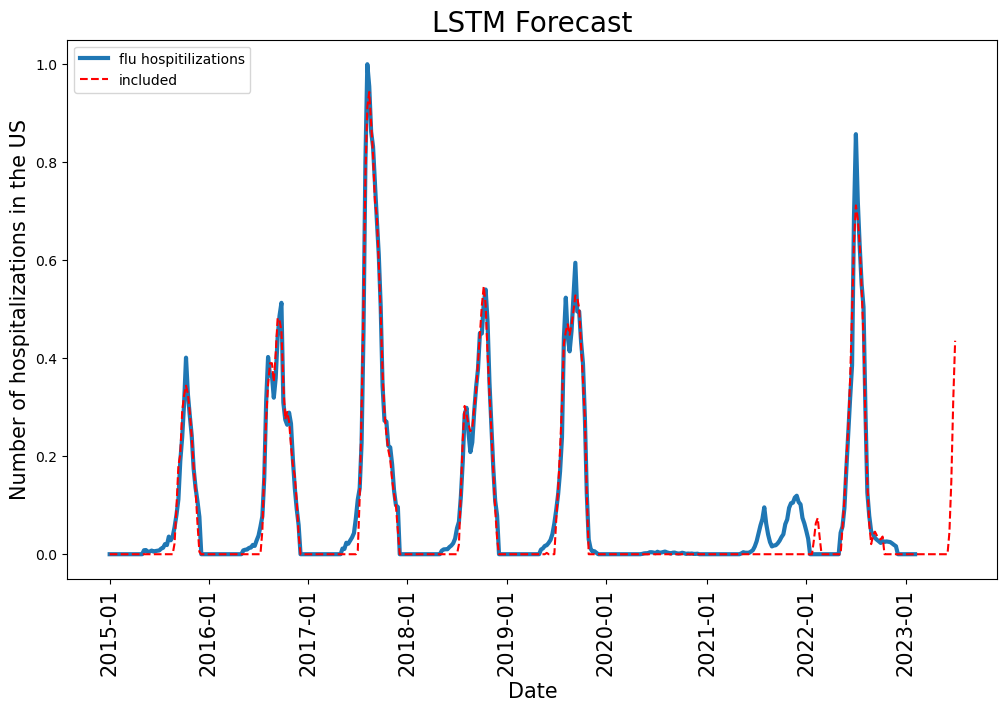

In [394]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# GRU_B

In [93]:
class gru_B(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru_B, self).__init__()
        
        
        
        self.gru = nn.GRU(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(seq_len*country_len,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.gru(x.permute(0,2,1))
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [406]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [407]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 13.956899584209225 Val loss: 2.1389605932563427 Time: 0.7558125000214204
epoch 1 0 0
Train loss: 12.668664491182028 Val loss: 1.9396790661839987 Time: 0.602114100009203
epoch 2 0 0
Train loss: 10.757357341363871 Val loss: 1.6234158194274642 Time: 0.47041449998505414
epoch 3 0 0
Train loss: 8.432472159064986 Val loss: 1.3486071256920695 Time: 0.49221910000778735
epoch 4 0 0
Train loss: 6.853829945456528 Val loss: 1.2148218362417538 Time: 0.4835000000020955
epoch 5 0 0
Train loss: 6.18125865032718 Val loss: 1.1727563690510578 Time: 0.45864029999938793
epoch 6 0 0
Train loss: 5.816466509400772 Val loss: 1.1552163119777106 Time: 0.4676045999804046
epoch 7 0 0
Train loss: 5.582084335132418 Val loss: 1.1481548117881175 Time: 0.45007340001757257
epoch 8 0 0
Train loss: 5.480889052987534 Val loss: 1.1450378736262792 Time: 0.466286900016712
epoch 9 0 0
Train loss: 5.326498801897612 Val loss: 1.1438162763761284 Time: 0.4384800000116229
epoch 10 0 0
Train loss: 5.171402876

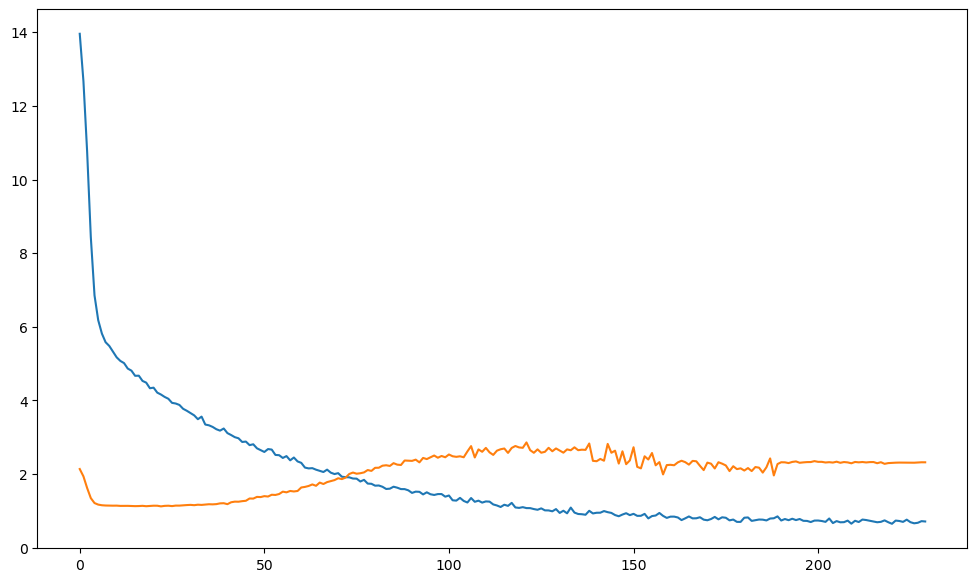

In [408]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

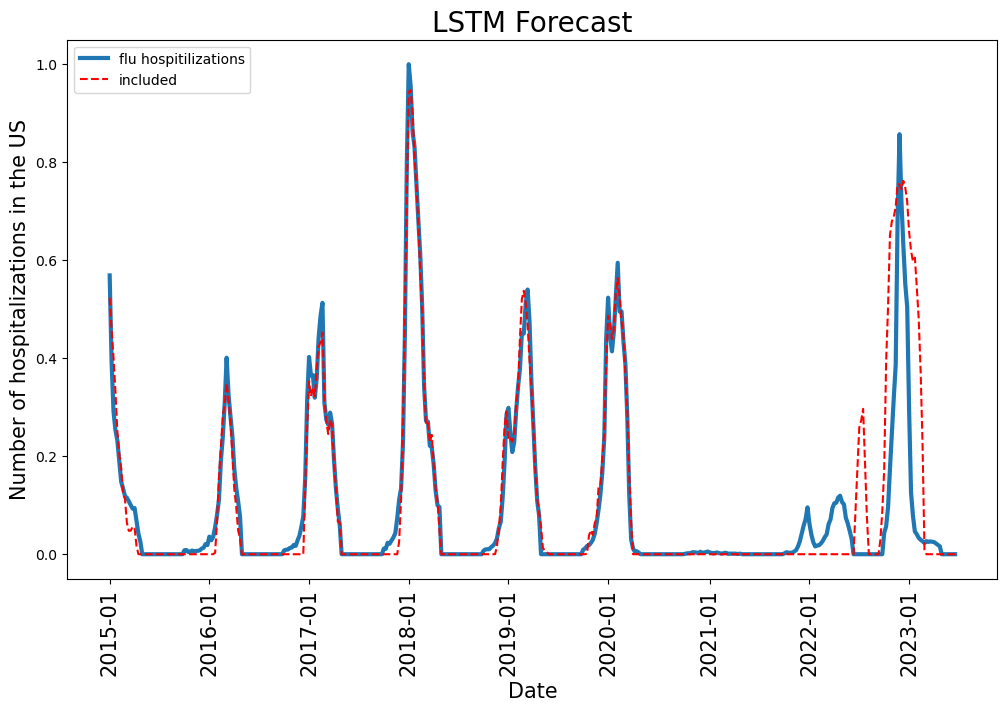

In [409]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

## 23-24

In [410]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_23-24.pth'
LOAD_PATH =  'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23_train.pth'
#print(LOAD_PATH)
model.load_state_dict(torch.load(LOAD_PATH))

loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2023-25')
noise = False
forecast = 1

torch.manual_seed(5)

In [411]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 2.6414784299446765 Val loss: 0.0 Time: 0.4561517999973148
epoch 1 0 0
Train loss: 3.7532221955646956 Val loss: 0.0 Time: 0.4784462999959942
epoch 2 0 1
Train loss: 2.92678736289065 Val loss: 0.0 Time: 0.5535049999889452
epoch 3 0 2
Train loss: 2.5701485097439445 Val loss: 0.0 Time: 0.4407771000114735
epoch 4 0 0
Train loss: 2.472458407000431 Val loss: 0.0 Time: 0.4680196000263095
epoch 5 0 0
Train loss: 2.2974100223989353 Val loss: 0.0 Time: 0.5740932000044268
epoch 6 0 0
Train loss: 2.0529446228250663 Val loss: 0.0 Time: 0.7016348000033759
epoch 7 0 0
Train loss: 2.1055462118946764 Val loss: 0.0 Time: 0.7585491000209004
epoch 8 0 1
Train loss: 2.0315562910993528 Val loss: 0.0 Time: 0.8040244999865536
epoch 9 0 0
Train loss: 1.9011990350417562 Val loss: 0.0 Time: 0.8922262999985833
epoch 10 0 0
Train loss: 1.908045949055861 Val loss: 0.0 Time: 0.9058785999950487
epoch 11 0 1
Train loss: 1.770243753072827 Val loss: 0.0 Time: 1.1345510000246577
epoch 12 0 0
Train 

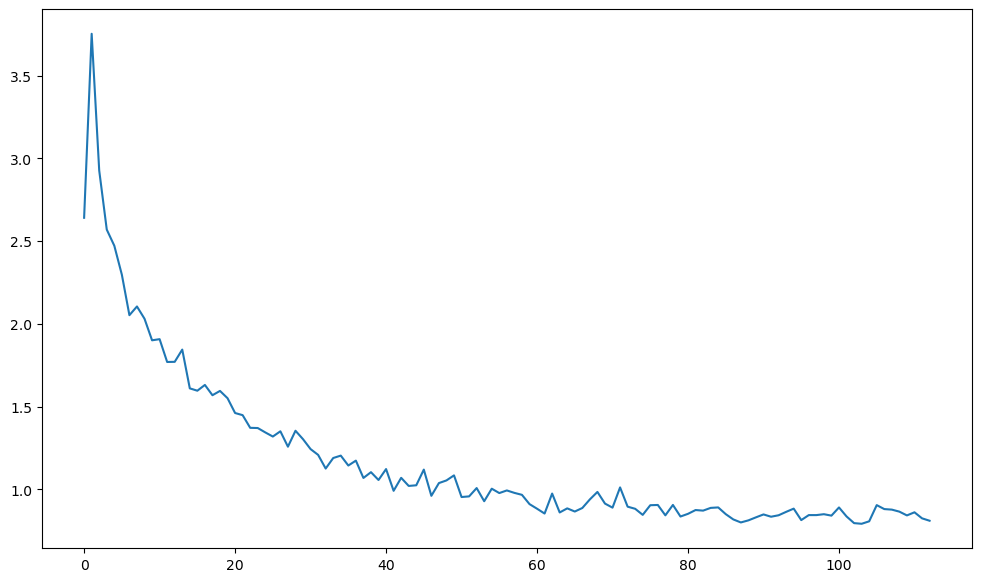

In [412]:
plt.plot(loss_t)

(1370,)


Text(0.5, 0, 'Date')

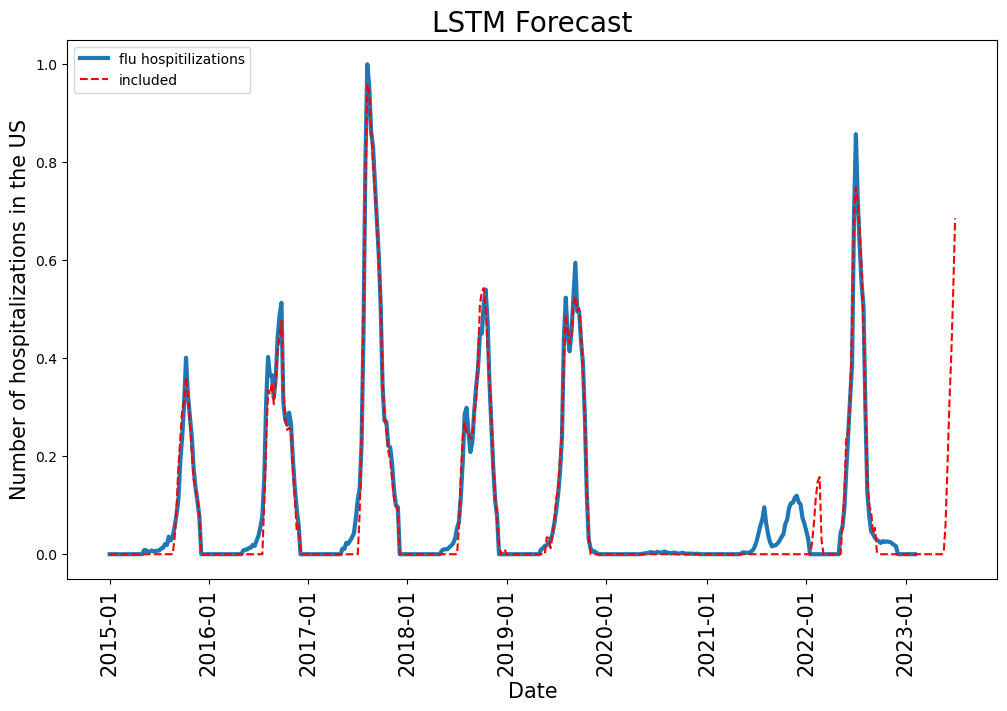

In [413]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all'],axis=1),26,25)

MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.shift(-21).values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# (throwout) GRU drop B

In [35]:
class gru_drop_B(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(gru_drop_B, self).__init__()
        
        
        
        self.gru = nn.GRU(seq_len,seq_len,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(seq_len*country_len,50),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.gru(x.permute(0,2,1))
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [441]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = gru_drop_B(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 250
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(5)

In [442]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 14.165852335689399 Val loss: 2.0868503620295087 Time: 0.8101854000124149
epoch 1 0 0
Train loss: 10.829703343007665 Val loss: 1.4713460023631342 Time: 0.7316802999994252
epoch 2 0 0
Train loss: 7.3910432558361165 Val loss: 1.0964334684040296 Time: 0.699464099976467
epoch 3 0 0
Train loss: 5.940078672907042 Val loss: 0.9802878167233757 Time: 0.6863908999948762
epoch 4 0 0
Train loss: 5.580591026278562 Val loss: 0.9261354399641277 Time: 0.6727321000071242
epoch 5 0 0
Train loss: 5.155158081426862 Val loss: 0.8989141021083924 Time: 0.6743106999783777
epoch 6 0 0
Train loss: 4.952692748920871 Val loss: 0.8899356711481232 Time: 0.6309563999820966
epoch 7 0 0
Train loss: 4.89259799784034 Val loss: 0.9009133979780017 Time: 0.6479349999863189
epoch 8 1 0
Train loss: 4.691985665394782 Val loss: 0.908283130190739 Time: 0.6352627000014763
epoch 9 2 0
Train loss: 4.3733885993359625 Val loss: 0.9065627541858703 Time: 0.6524613999936264
epoch 10 0 0
Train loss: 4.212516408769

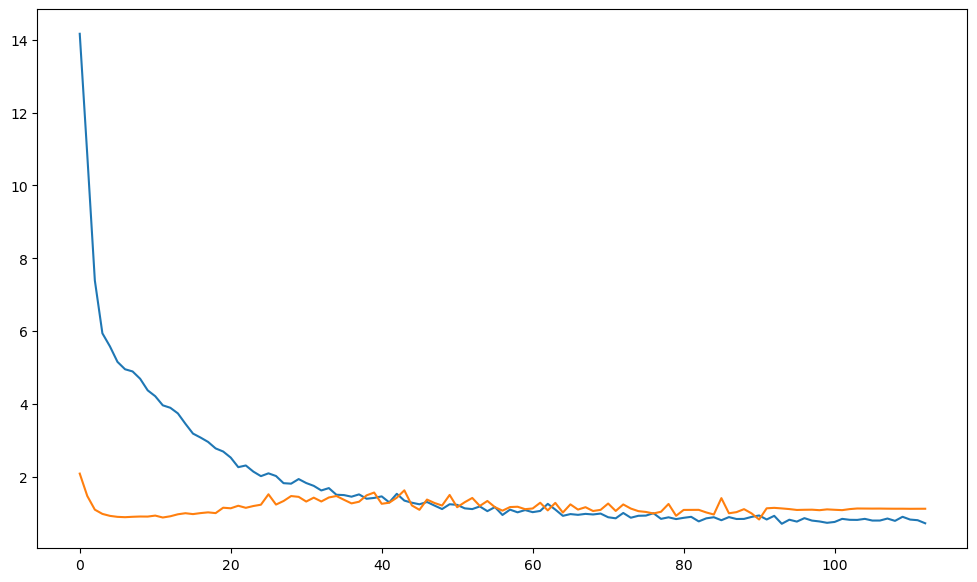

In [443]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

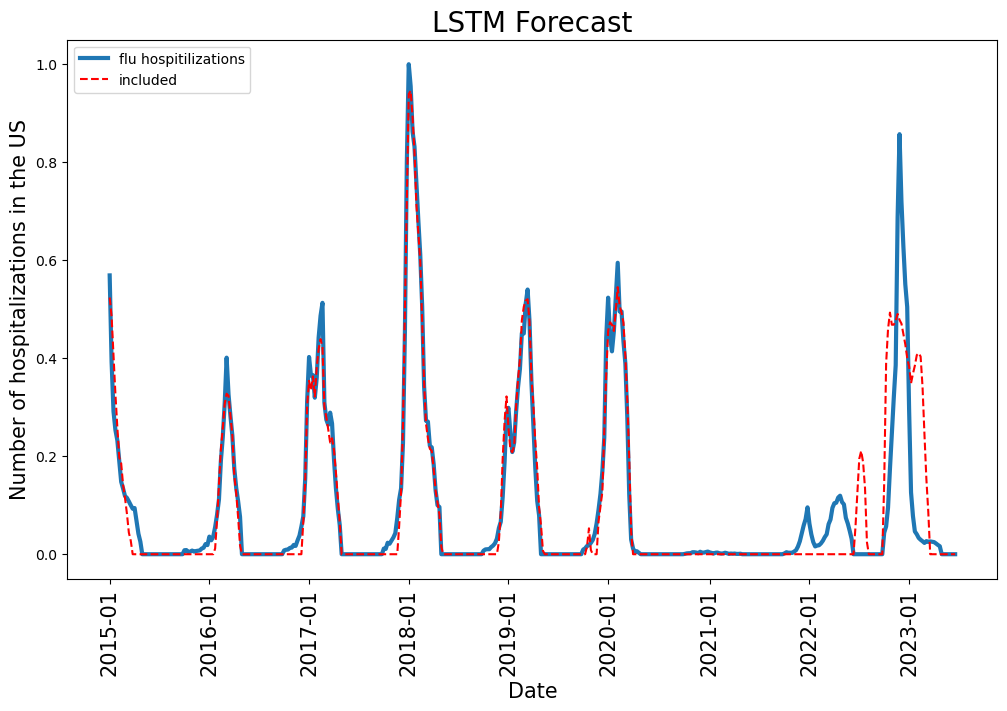

In [444]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# (throwout) LSTM Simple

In [36]:
class lstm_simple(nn.Module):
    
    # input shape [time,everything,seq]
    
    def __init__(self,seq_len,country_len):
        super(lstm_simple, self).__init__()
        
        
        
        self.lstm = nn.LSTM(seq_len,5,num_layers = 1)

        self.enc = nn.Sequential(
        nn.ReLU(),
        nn.Linear(seq_len,seq_len)

       )

        self.seq = nn.Sequential( 
            nn.Flatten(),
            nn.ReLU(),
            
            nn.Linear(country_len*5,1),
            nn.Dropout(0.2),
            nn.ReLU()
        )        
        
    def forward(self, x):

        #logits = self.convo(x).permute(0,2,1)
        
        logits, _ = self.lstm(x.permute(0,2,1))
        
        logits = self.seq(logits)
        
        
        return logits

## 22-23

In [558]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_simple(26,5).to(device)
#LOAD_PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_train.pth'
PATH = 'Q:\\00- PROJECTS\\Flu Forecasts\\flu\\flu\\models\\'+model.__class__.__name__+'_22-23.pth'



loss_fn = nn.MSELoss()
batched_sequence = data_in
learn_rate = 1e-4
num_epochs = 2e3
kill = num_epochs
batch_size_ = 1
t_beg = index.index('2013-01')
t_end = index.index('2022-27')
noise = False
forecast = 30

torch.manual_seed(9)

In [559]:
loss_t,loss_v = train_model(PATH,model,device,loss_fn,batched_sequence,learn_rate,num_epochs,kill,batch_size_,t_beg,t_end,noise,forecast)

epoch 0 0 0
Train loss: 16.682476440864264 Val loss: 2.612972970076953 Time: 0.9829489000258036
epoch 1 0 0
Train loss: 16.04807260402393 Val loss: 2.5262164569209653 Time: 0.6101323000038974
epoch 2 0 0
Train loss: 15.075837060404517 Val loss: 2.4511227143466385 Time: 0.5361031999927945
epoch 3 0 0
Train loss: 15.411589754780266 Val loss: 2.4295800090330886 Time: 0.5257819000107702
epoch 4 0 1
Train loss: 15.208430198975492 Val loss: 2.4064755323688587 Time: 0.7289343000156805
epoch 5 0 2
Train loss: 15.110287795119348 Val loss: 2.3664521862099264 Time: 0.7279315000050701
epoch 6 0 3
Train loss: 14.07165733710832 Val loss: 2.262971952677617 Time: 0.5754020999884233
epoch 7 0 0
Train loss: 13.832837032869065 Val loss: 2.1643067812692607 Time: 0.513955900009023
epoch 8 0 0
Train loss: 13.338948220526163 Val loss: 2.0513832836841175 Time: 0.5339019000239205
epoch 9 0 0
Train loss: 12.330845031713807 Val loss: 1.9350960605952423 Time: 0.5394437999930233
epoch 10 0 0
Train loss: 11.1698347

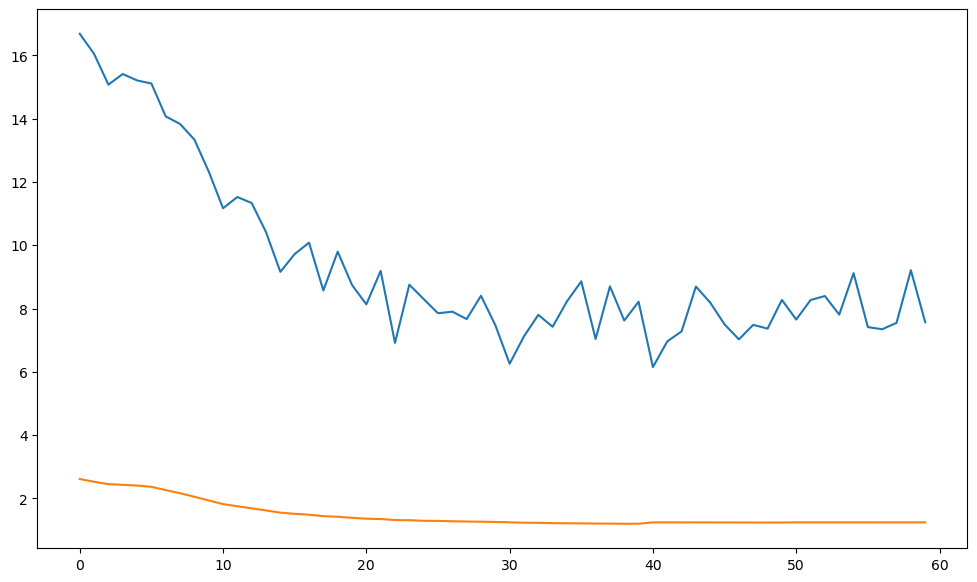

In [560]:
plt.plot(loss_t)
plt.plot(loss_v)

Text(0.5, 0, 'Date')

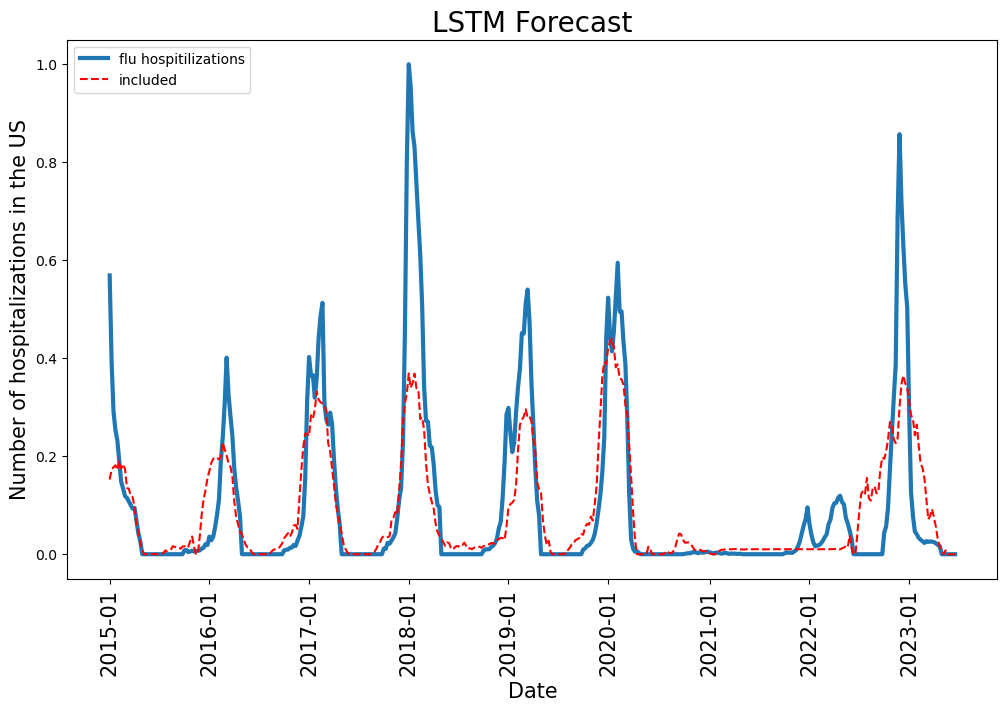

In [561]:
MODEL_PATH = PATH[:-4]+"_train.pth"
pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
plot_df["pred"] = pred
plt.rcParams['figure.figsize'] = (12, 7)

plt.plot(plot_df["INF_ALL"].loc['2015-01':'2023-25'],linewidth=3,label='flu hospitilizations')
#plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
plt.plot(plot_df["pred"].loc['2015-01':'2023-25'],linestyle="dashed",color='red',label='included')
#plt.plot(plot_df["pred"].loc['2022-26':'2023-10'],color='red',label='prediction')
plt.legend(loc='upper left')
plt.xticks(ticks = ['2015-01','2016-01','2017-01','2018-01','2019-01','2020-01','2021-01','2022-01','2023-01'], rotation=90,size=15)
plt.title('LSTM Forecast',size =20)
plt.ylabel('Number of hospitalizations in the US',size =15)
plt.xlabel('Date',size=15)

# Summary

In [96]:
model_list = [gru(26,5),gru_drop(26,5),gru_3lay_drop(26,5),lstm(26,5),lstm_drop(26,5),lstm_3lay_drop(26,5),lstm_drop_2lin_B(26,5),lstm_B(26,5),lstm_drop_B(26,5),rnn(26,5),rnn_drop(26,5),gru_B(26,5)]

In [97]:
max_ = flu_surv['INF_ALL'].max()

In [98]:
max_

2949.0

gru


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gru_drop


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gru_3lay_drop


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


lstm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


lstm_drop


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


lstm_3lay_drop


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


lstm_drop_2lin_B


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


lstm_B
lstm_drop_B


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rnn


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rnn_drop


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gru_B


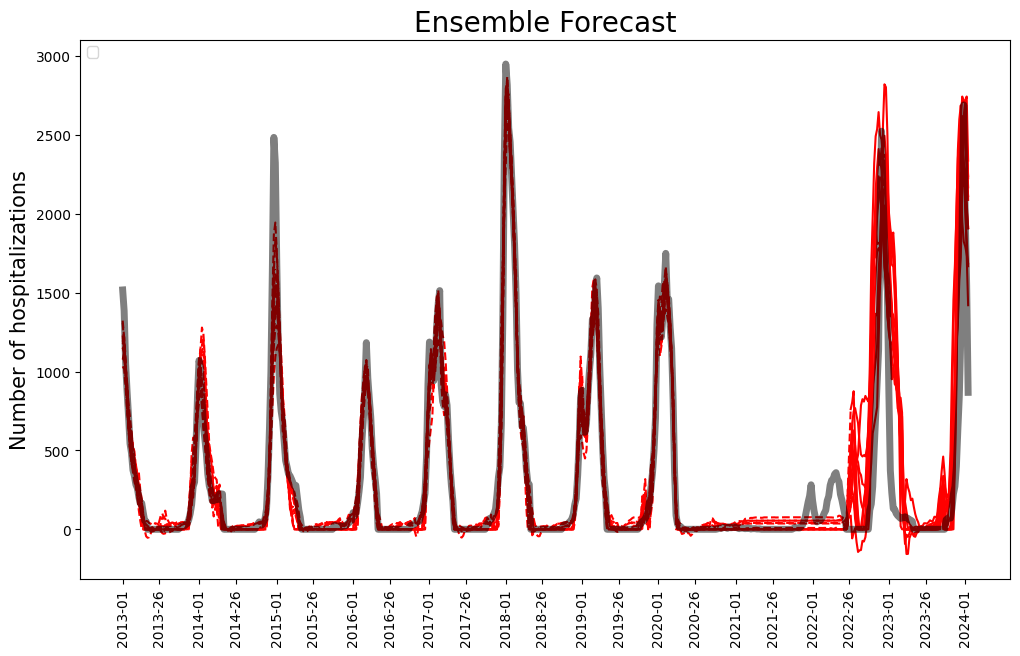

In [105]:
plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batched_sequence = data_in

for model in model_list:
    model = model.to(device)
    print(model.__class__.__name__)

    MODEL_PATH = 'models/'+model.__class__.__name__+'_22-23_train.pth'
    pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)

    
    plot_df[model.__class__.__name__] = pred

    plt.rcParams['figure.figsize'] = (12, 7)

    
    #plt.plot(plot_df["AUS_flu"].loc['2015-01':'2023-10'])
    plt.plot(max_*plot_df[model.__class__.__name__].loc['2013-01':'2022-27'],linestyle="dashed",color='red')#,label=model.__class__.__name__+'(included)')
    plt.plot(max_*plot_df[model.__class__.__name__].loc['2022-27':],color='red')#label=model.__class__.__name__+'(prediction)',linewidth=1)
    plt.legend(loc='upper left')
    x_ticks=['2013-01','2013-26','2014-01','2014-26','2015-01','2015-26','2016-01','2016-26','2017-01','2017-26','2018-01','2018-26','2019-01','2019-26','2020-01','2020-26','2021-01','2021-26','2022-01','2022-26','2023-01','2023-26','2024-01']



    plt.xticks(ticks = x_ticks,rotation=90)
    plt.title('Ensemble Forecast',size =20)
    plt.ylabel('Number of hospitalizations',fontsize=15)
plt.plot(max_*plot_df["INF_ALL"].loc['2013-01':],linewidth=5,color='black',alpha=0.5)

## create shifted predictions

In [106]:
index_old = list(usa_infall_norm.index)
index_old[-1]

'2024-03'

In [107]:
index_new = []
start_date = index_old[-1]

yr = int(start_date[:4])
day = int(start_date[-2:])
for i in range(21):
    if day == 52:
        day = 1
        yr +=1
    else:
        day+=1
    if day < 10:
        day_str = '0'+str(day)
    else:
        day_str = str(day)
    new_date = str(yr)+'-'+day_str
    index_new.append(new_date)
index_new = index_old[21:] + index_new






In [108]:
len(index_new)

1398

In [109]:
model_names = []
for model in model_list:
    model_names.append(model.__class__.__name__+'_22-23')

In [112]:
batched_sequence = Dataset_(tmp["all"],tmp.drop(['all','key_0'],axis=1),26,25)
predictions = []
for i in range(len(model_list)):

    model = model_list[i].to(device)
    PATH = 'models/'+model.__class__.__name__+'_22-23.pth'
    MODEL_PATH = PATH[:-4]+"_train.pth"

    pred = create_prediction(MODEL_PATH,model,device,batched_sequence,0,0,True)
    print(pred.shape)
    predictions.append(pred[:,0])

#so_cos = list(df_norm.columns)
#for i in range(len(so_cos)):
#    predictions.append(df_norm[so_cos[i]].shift(-21).to_numpy())
predictions = np.array(predictions)

pred_df = pd.DataFrame(data=predictions.T, columns = model_names,index = index_new)
pred_df = pred_df.join(df_norm,on=pred_df.index)

(1398,)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)
(1398, 1)


In [115]:
pred_df = pred_df.drop('key_0',axis=1)

In [117]:
pred_df.columns

Index(['gru_22-23', 'gru_drop_22-23', 'gru_3lay_drop_22-23', 'lstm_22-23',
       'lstm_drop_22-23', 'lstm_3lay_drop_22-23', 'lstm_drop_2lin_B_22-23',
       'lstm_B_22-23', 'lstm_drop_B_22-23', 'rnn_22-23', 'rnn_drop_22-23',
       'gru_B_22-23', 'INF_ALLAUS', 'INF_ALLCHL', 'INF_ALLPRY', 'INF_ALLARG',
       'INF_ALLURY'],
      dtype='object')

Text(0.5, 0, 'Date')

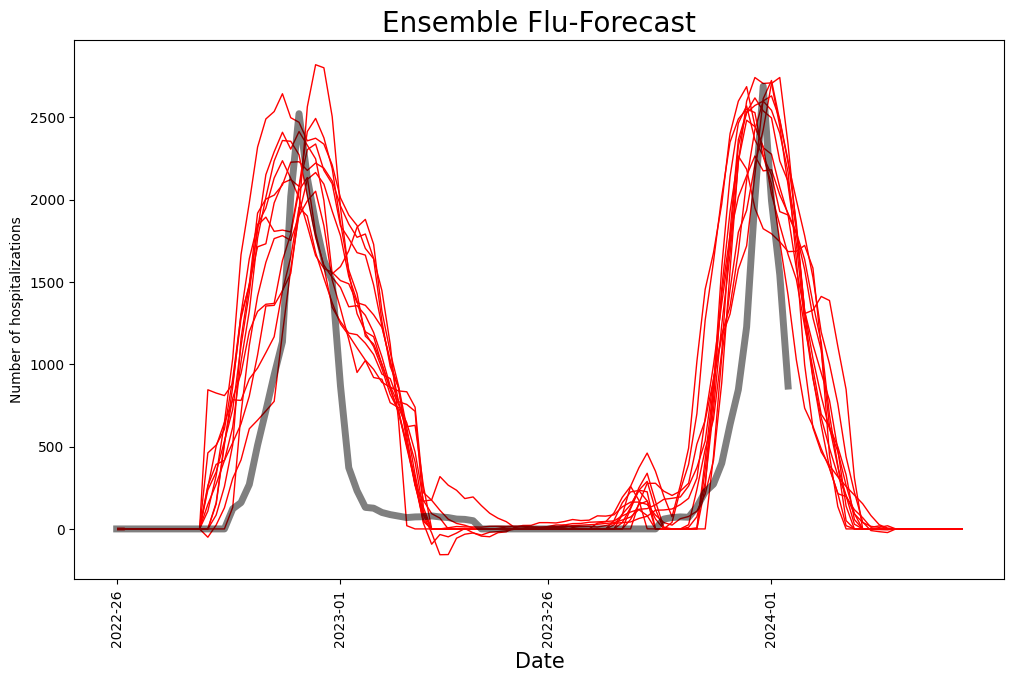

In [121]:
start_date = '2022-26'
plot_df = pd.DataFrame(data=usa_infall_norm.values,columns = ['INF_ALL'],index=usa_infall_norm.index)
batched_sequence = data_in

for model in ['gru_22-23', 'gru_drop_22-23', 'gru_3lay_drop_22-23', 'lstm_22-23',
       'lstm_drop_22-23', 'lstm_3lay_drop_22-23', 'lstm_drop_2lin_B_22-23',
       'lstm_B_22-23', 'lstm_drop_B_22-23', 'rnn_22-23', 'rnn_drop_22-23',
       'gru_B_22-23']:
    tmp_ = pred_df[model]
    tmp_.loc['2022-21':'2022-36'] = np.zeros(shape = tmp_.loc['2022-21':'2022-36'].to_numpy().shape)
    tmp_.loc['2024-16':] = np.zeros(shape = tmp_.loc['2024-16':].to_numpy().shape)
    plt.plot(max_*tmp_.loc[start_date:'2022-27'],linestyle="dashed",label=model+'(included)',color='red')
    plt.plot(max_*tmp_.loc['2022-27':],label=model+'(prediction)',linewidth=1,color='red')
    #plt.legend(loc='upper left')
    #x_ticks=['2013-01','2013-26','2014-01','2014-26','2015-01','2015-26','2016-01','2016-26','2017-01','2017-26','2018-01','2018-26','2019-01','2019-26','2020-01','2020-26','2021-01','2021-26','2022-01','2022-26','2023-01','2024-26']
    x_ticks=['2022-26','2023-01','2023-26','2024-01']

plt.plot(max_*plot_df["INF_ALL"].loc[start_date:],linewidth=5,color='black',alpha=0.5)
#plt.plot(smooth_df)
plt.xticks(ticks = x_ticks,rotation=90)
plt.title('Ensemble Flu-Forecast',size =20)
plt.ylabel('Number of hospitalizations')
plt.xlabel('Date',size=15)

In [195]:
# want to get max, max location, and half-width

window1, window2 = '2022-30','2023-17'

def make_lorenzian_params(window1,window2,pred_df):

    maxs, maxs_loc, half_width_list, width_list = [],[],[],[]
    for col in list(pred_df.columns):

        max_ = pred_df[col].loc[window1:window2].max()
        id_max_ = pred_df[col].loc[window1:window2].idxmax()

        maxs.append(max_)
        maxs_loc.append(id_max_)

        half_max = 0.5 * max_

        for id in list(pred_df.loc[window1:id_max_].index):
            
            if pred_df[col].loc[id] > half_max:

                id_half = id
                break

        for id in list(pred_df.loc[id_max_:window2].index):
            
            if pred_df[col].loc[id] < half_max:

                id_sec_half = id
                break

        half_width = len(pred_df.loc[id_half:id_max_])
        width = len(pred_df.loc[id_half:id_sec_half])
        half_width_list.append(half_width)
        width_list.append(width)

    curve_params = pd.DataFrame(data=zip(maxs,maxs_loc,half_width_list,width_list),columns = ['max','max_loc','half_width','width'],index=list(pred_df.columns))
    return curve_params
        


In [196]:
window1, window2 = '2022-30','2023-17'
curve_params = make_lorenzian_params(window1,window2,pred_df)
curve_params = curve_params.drop(['INF_ALLAUS','INF_ALLCHL','INF_ALLPRY','INF_ALLARG','INF_ALLURY'],axis=0)

In [197]:
curve_params

max  max_loc  half_width  width
gru_22-23               0.793104  2022-50          10     19
gru_drop_22-23          0.845816  2022-50           9     15
gru_3lay_drop_22-23     0.956456  2022-50           5     10
lstm_22-23              0.800286  2022-46           5     17
lstm_drop_22-23         0.723978  2022-49           8     16
lstm_3lay_drop_22-23    0.734329  2022-50           5     13
lstm_drop_2lin_B_22-23  0.662688  2022-48           6     15
lstm_B_22-23            0.896677  2022-46           6     18
lstm_drop_B_22-23       0.758663  2022-46           6     19
rnn_22-23               0.818760  2022-48           8     19
rnn_drop_22-23          0.695816  2022-50           9     14
gru_B_22-23             0.756559  2022-48           8     20

In [198]:
curve_params['max'].std()

0.08402928951115583

In [199]:
def lorentzian(max_,gamma,x0,x):
    func_ = (1/np.pi) * (0.5*gamma) / ( (x-x0)**2 + (0.5*gamma)**2)
    weight = max_ * np.pi * gamma/2
    func_*=weight
    return func_ 

In [200]:
def make_lorenzian_df(window1,window2,curve_params,two_bool):

    max_val = curve_params['max'].mean()
    curve_params['max_loc_adj'] = curve_params['max_loc'].apply(lambda x: int(x.split('-')[1]) if int(x.split('-')[1]) > 10 else int(x.split('-')[1])+52)

    loc = curve_params['max_loc_adj'].mean()
    loc_std = curve_params['max_loc_adj'].std()

    # assuming models get the width wrong by a factor of 2

    #gamma = 9.8
    gamma = curve_params['half_width'].mean()

    if two_bool == True:

        gamma*=2


    # pred_df hard coded in here is bad practice but whatever

    index_tmp = list(pred_df.loc[window1:window2].index)

    lor = lorentzian(max_val,gamma,loc,np.arange(int(window1.split('-')[1]),int(window1.split('-')[1])+len(index_tmp),1))

    return pd.DataFrame(data = lor,columns = ['smooth'],index=index_tmp)

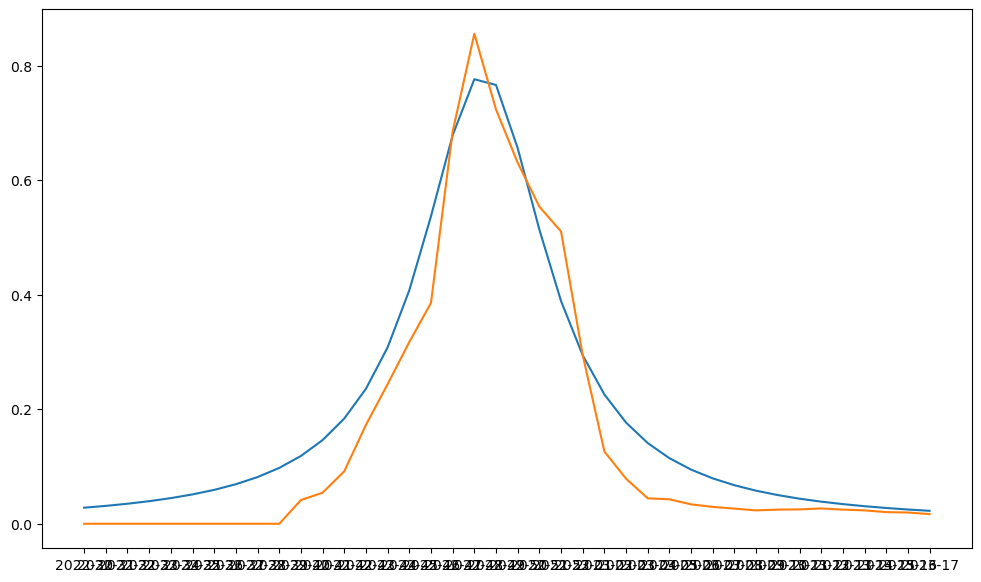

In [201]:
window1, window2 = '2022-30','2023-17'
curve_params = make_lorenzian_params(window1,window2,pred_df)
curve_params = curve_params.drop(['INF_ALLAUS','INF_ALLCHL','INF_ALLPRY','INF_ALLARG','INF_ALLURY'],axis=0)
smooth_df = make_lorenzian_df(window1,window2,curve_params,False)

plt.plot(smooth_df.loc[window1:window2])
plt.plot(usa_infall_norm.loc[window1:window2])

In [68]:
curve_params

max  max_loc  half_width  width  max_loc_adj
gru_22-23               0.793104  2022-50         5.0    9.5           50
gru_drop_22-23          0.845816  2022-50         4.5    7.5           50
gru_3lay_drop_22-23     0.956456  2022-50         2.5    5.0           50
lstm_22-23              0.800286  2022-46         2.5    8.5           46
lstm_drop_22-23         0.723978  2022-49         4.0    8.0           49
lstm_3lay_drop_22-23    0.734329  2022-50         2.5    6.5           50
lstm_drop_2lin_B_22-23  0.662688  2022-48         3.0    7.5           48
lstm_B_22-23            0.896677  2022-46         3.0    9.0           46
lstm_drop_B_22-23       0.758663  2022-46         3.0    9.5           46
rnn_22-23               0.818760  2022-48         4.0    9.5           48
rnn_drop_22-23          0.695816  2022-50         4.5    7.0           50
gru_B_22-23             0.756559  2022-48         4.0   10.0           48

In [258]:
window1, window2 = '2022-30','2023-17'
curve_params = make_lorenzian_params(window1,window2,pred_df)
curve_params = curve_params.drop(['INF_ALLAUS','INF_ALLCHL','INF_ALLPRY','INF_ALLARG','INF_ALLURY'],axis=0)
smooth_df = make_lorenzian_df(window1,window2,curve_params,False)
#smooth_df = smooth_df.join(make_lorenzian_df(window1,window2,curve_params,False),on=smooth_df.index,rsuffix='half')

window1, window2 = '2023-30',index_new[-1]
curve_params = make_lorenzian_params(window1,window2,pred_df)
curve_params = curve_params.drop(['INF_ALLAUS','INF_ALLCHL','INF_ALLPRY','INF_ALLARG','INF_ALLURY'],axis=0)
smooth_23_24_df =  make_lorenzian_df(window1,window2,curve_params,False)
#smooth_23_24_df = smooth_23_24_df.join(make_lorenzian_df(window1,window2,curve_params,False), on=smooth_23_24_df.index,rsuffix='half')



In [70]:
#usa_infall_norm.loc['2023-47'] = np.nan

In [123]:
usa_infall_norm.loc['2023-47']

nan

In [259]:
pred_df = pred_df.join(usa_infall_norm,how='left',on=pred_df.index)

In [221]:
# correct the large widths

def width_correction(x,fmax,xmax,gamma):

    denom =16* ( ( x -xmax)**2 + gamma**2/4) * ( ( x- xmax)**2 + gamma**2/16)
    num =  3*fmax*(gamma**2) * ( x -xmax)**2
    return ( num/denom )

In [249]:
def create_corrected_model(model_col,pred_df,curve_params,window1,window2):
    df_ = pred_df[model_col]
    df_ = df_.loc[window1:window2]
    index_tmp = list(df_.loc[window1:window2].index)
    df_.index = np.arange(int(window1.split('-')[1]),int(window1.split('-')[1])+len(index_tmp),1)
    max_ = curve_params['max'].loc[model_col]
    gamma = curve_params['width'].loc[model_col]*16
    xmax = max_ = curve_params['max_loc_adj'].loc[model_col]
    new_vals = []
    for x in df_.index:
        val = df_.loc[x] - width_correction(x,max_,xmax,gamma)
        c=2
        if df_.loc[x]> 0.10:
            while val < 0:

                val = df_.loc[x] - width_correction(x,max_,xmax,gamma)/c
                c+=1
        if val < 0:
            val = 0
            
        new_vals.append(val)
    print(len(new_vals))
    df_new = pd.DataFrame()
    df_new[model_col] = new_vals
    df_new.index = index_tmp

    return df_new

In [241]:
curve_params

max  max_loc  half_width  width  max_loc_adj
gru_22-23               0.930138  2024-02           7     10           54
gru_drop_22-23          0.930071  2023-51           4     10           51
gru_3lay_drop_22-23     0.923955  2024-01           5     11           53
lstm_22-23              0.871667  2023-50           4     10           50
lstm_drop_22-23         0.892189  2024-01           6     11           53
lstm_3lay_drop_22-23    0.842131  2023-50           3     10           50
lstm_drop_2lin_B_22-23  0.881450  2023-52           6     11           52
lstm_B_22-23            0.865026  2023-50           5     14           50
lstm_drop_B_22-23       0.768444  2023-51           5     13           51
rnn_22-23               0.768060  2023-49           3     13           49
rnn_drop_22-23          0.888055  2023-51           4     11           51
gru_B_22-23             0.911238  2023-50           6     13           50

47


(0.0, 1.0)

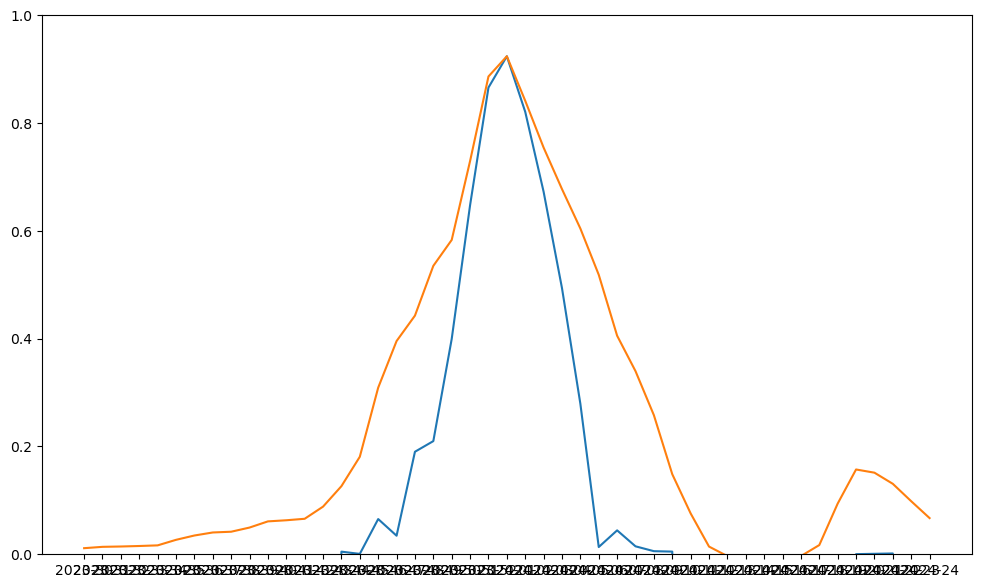

In [242]:
plt.plot(create_corrected_model('gru_3lay_drop_22-23',pred_df,curve_params,'2023-30',index_new[-1]))
plt.plot(pred_df['gru_3lay_drop_22-23'].loc['2023-30':index_new[-1]])
plt.ylim([0,1])

In [256]:
model_names

['gru_22-23',
 'gru_drop_22-23',
 'gru_3lay_drop_22-23',
 'lstm_22-23',
 'lstm_drop_22-23',
 'lstm_3lay_drop_22-23',
 'lstm_drop_2lin_B_22-23',
 'lstm_B_22-23',
 'lstm_drop_B_22-23',
 'rnn_22-23',
 'rnn_drop_22-23',
 'gru_B_22-23']

In [261]:
for model in model_names:
    fixed = create_corrected_model(model,pred_df,curve_params,'2023-30',index_new[-1])
    pred_df = pred_df.join(fixed,on=pred_df.index,rsuffix='_fixed')

47
47
47
47
47
47
47
47
47
47
47
47


In [254]:
pred_df = pred_df.join(smooth_df,on=pred_df.index,rsuffix='22-23')
pred_df = pred_df.join(smooth_23_24_df,on=pred_df.index,rsuffix='23-24')

pred_df.to_excel('models_flu_predictions_1-29-2024.xlsx')

In [192]:
pred_df

gru_22-23  gru_drop_22-23  gru_3lay_drop_22-23  lstm_22-23  \
1997-21   0.025999        0.013696             0.018640    0.000000   
1997-22   0.026072        0.013700             0.018630    0.000000   
1997-23   0.025838        0.013719             0.018629    0.000000   
1997-24   0.025891        0.013718             0.018624    0.000000   
1997-25   0.026047        0.013743             0.018642    0.000000   
...            ...             ...                  ...         ...   
2024-20   0.159908        0.146951             0.157325    0.253965   
2024-21   0.176218        0.185534             0.151388    0.258896   
2024-22   0.187610        0.243673             0.130716    0.244035   
2024-23   0.151253        0.236363             0.098445    0.201280   
2024-24   0.118053        0.165874             0.067143    0.162546   

         lstm_drop_22-23  lstm_3lay_drop_22-23  lstm_drop_2lin_B_22-23  \
1997-21         0.000000              0.018620                0.012405   
1997-22         0.000000              0.018635                0.012406   
1997-23         0.000000              0.018644                0.012405   
1997-24         0.000000              0.018666                0.012411   
1997-25         0.000000              0.018665                0.012416   
...                  ...                   ...                     ...   
2024-20         0.426177              0.391534                0.464606   
2024-21         0.439048              0.341495                0.473627   
2024-22         0.430515              0.305973                0.458478   
2024-23         0.370588              0.243530                0.452669   
2024-24         0.298157              0.179318                0.425976   

         lstm_B_22-23  lstm_drop_B_22-23  rnn_22-23  ...  INF_ALL  smooth  \
1997-21      0.000000           0.000000   0.003189  ...      0.0     NaN   
1997-22      0.000000           0.000000   0.003300  ...      0.0     NaN   
1997-23      0.000000           0.000000   0.002868  ...      0.0     NaN   
1997-24      0.000000           0.000000   0.002842  ...      0.0     NaN   
1997-25      0.000000           0.000000   0.002968  ...      0.0     NaN   
...               ...                ...        ...  ...      ...     ...   
2024-20      0.134774           0.142015   0.146676  ...      NaN     NaN   
2024-21      0.153859           0.162941   0.167854  ...      NaN     NaN   
2024-22      0.185850           0.167287   0.191018  ...      NaN     NaN   
2024-23      0.173947           0.144132   0.186989  ...      NaN     NaN   
2024-24      0.131726           0.116085   0.152845  ...      NaN     NaN   

         smooth23-24  smooth22-23  smooth23-24  smooth22-23  smooth23-24  \
1997-21          NaN          NaN          NaN          NaN          NaN   
1997-22          NaN          NaN          NaN          NaN          NaN   
1997-23          NaN          NaN          NaN          NaN          NaN   
1997-24          NaN          NaN          NaN          NaN          NaN   
1997-25          NaN          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
2024-20     0.011587          NaN     0.011587          NaN     0.011587   
2024-21     0.010563          NaN     0.010563          NaN     0.010563   
2024-22     0.009668          NaN     0.009668          NaN     0.009668   
2024-23     0.008882          NaN     0.008882          NaN     0.008882   
2024-24     0.008187          NaN     0.008187          NaN     0.008187   

         smooth22-23  smooth23-24  gru_3lay_drop_22-23_fixed  
1997-21          NaN          NaN                        NaN  
1997-22          NaN          NaN                        NaN  
1997-23          NaN          NaN                        NaN  
1997-24          NaN          NaN                        NaN  
1997-25          NaN          NaN                        NaN  
...              ...          ...                  

# Tamiflu

In [21]:
import pyodbc
conn_string = 'Driver={ODBC Driver 17 for SQL Server}; Server=roproductionsql.database.windows.net; TrustedConnection=no; Database=ROAR; Uid={christopher.johnson@redoaksourcing.com}; Pwd={}; Authentication=ActiveDirectoryPassword; '
conn = pyodbc.connect(conn_string)

# PseudoPortfolio
tami_df = pd.read_sql_query("select concat(b.Year,'-',b.WeekofYear) , sum(a.NumberofScripts) from DispenseDaily as a left join Calendar as b on a.dispensedateid = b.dateid left join PseudoPortfolio as c on a.ProductID = c.ProductID where a.dispensedateid > 20180101 and c.gcn = 73441 and a.formularyid in (2,3,4) group by b.WeekOfYear, b.Year order by b.Year, b.WeekOfYear",conn)

In [22]:
tami_CAH_df = pd.read_sql_query("select concat(b.Year,'-',b.WeekofYear) , sum(a.OrderQTY) from CAHDailySL as a left join Calendar as b  on a.Date = b.date where a.Date > '2018-01-01' and a.gcn = 73441 group by b.WeekOfYear, b.Year order by b.Year, b.WeekOfYear",conn)
tamisyr_CAH_df = pd.read_sql_query("select concat(b.Year,'-',b.WeekofYear) , sum(a.OrderQTY) from CAHDailySL as a left join Calendar as b  on a.Date = b.date where a.Date > '2018-01-01' and a.gcn = 29729 group by b.WeekOfYear, b.Year order by b.Year, b.WeekOfYear",conn)

In [23]:
tami_df.columns = ['WeekTime','Dispensed']
tami_CAH_df.columns = ['WeekTime','Ordered']
tamisyr_CAH_df.columns = ['WeekTime','Ordered']

In [24]:
tami_df = tami_df.set_index('WeekTime')
tami_df = pdflusurv_to_weektime(tami_df)

tami_CAH_df = tami_CAH_df.set_index('WeekTime')
tami_CAH_df = pdflusurv_to_weektime(tami_CAH_df)

tamisyr_CAH_df = tamisyr_CAH_df.set_index('WeekTime')
tamisyr_CAH_df = pdflusurv_to_weektime(tamisyr_CAH_df)

In [25]:
merged_df = flu_surv.join(tami_df,how='left',on=flu_surv.index)

In [26]:
merged_df = merged_df.join(tami_CAH_df,how='left',on=flu_surv.index)

In [27]:
merged_df = merged_df.join(tamisyr_CAH_df,how='left',on=flu_surv.index,rsuffix='_syr')

In [28]:
usa_who = join_countries(['USA'])

In [29]:
merged_df = merged_df.join(usa_who,how='left',on=flu_surv.index)

In [30]:
merged_df.columns

Index(['SEASON', 'INFLUENZA A', 'INFLUENZA B', 'INFLUENZA A AND B', 'INF_ALL',
       'Dispensed', 'Ordered', 'Ordered_syr', 'INF_ALLUSA'],
      dtype='object')

In [31]:
merged_df[['Ordered','Ordered_syr']].loc['2018-01':]

Ordered  Ordered_syr
2018-01  46052.0       9725.0
2018-02  81516.0      18693.0
2018-03  60317.0      19118.0
2018-04  55211.0      25073.0
2018-05  55285.0      35770.0
...          ...          ...
2024-13      NaN          NaN
2024-14      NaN          NaN
2024-15      NaN          NaN
2024-16      NaN          NaN
2024-17      NaN          NaN

[204 rows x 2 columns]

([<matplotlib.axis.XTick at 0x1dd9e004b50>,
 [Text(0.0, 0, '2018'),
  Text(30.0, 0, '2019'),
  Text(60.0, 0, '2020'),
  Text(91.0, 0, '2021'),
  Text(121.0, 0, '2022'),
  Text(157.0, 0, '2023'),
  Text(187.0, 0, '2024')])

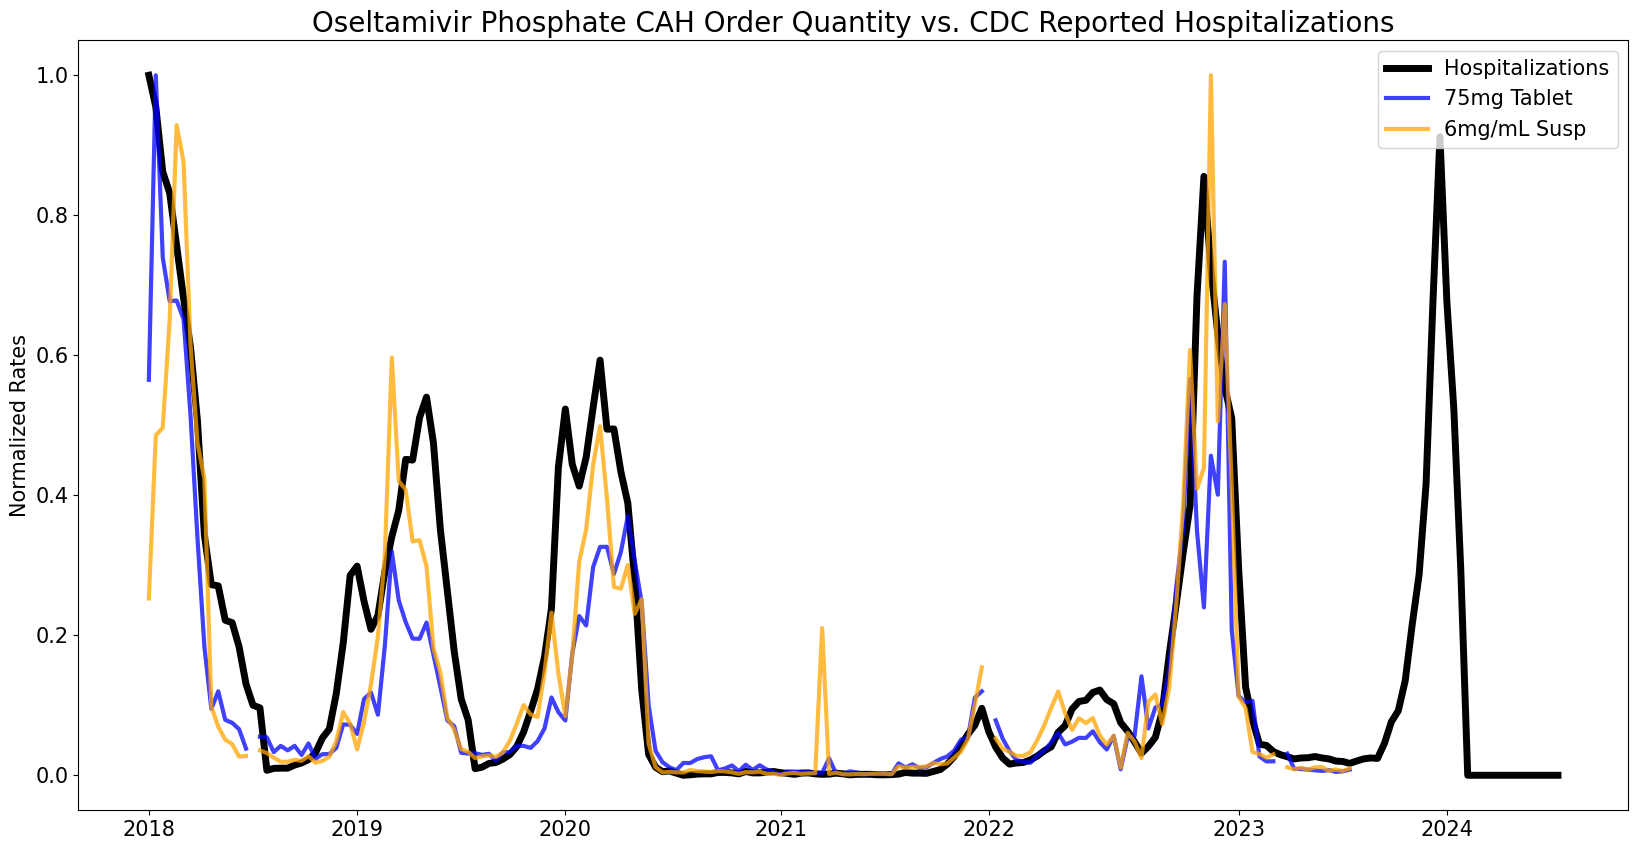

In [32]:
#plt.plot(merged_df[['Dispensed']].loc['2018-01':]/merged_df[['Dispensed']].loc['2018-01':].max(),label='dispensed')
plt.title('Oseltamivir Phosphate CAH Order Quantity vs. CDC Reported Hospitalizations',fontsize=20)
plt.ylabel('Normalized Rates',fontsize=15)
plt.yticks(fontsize=15)
plt.plot(merged_df['INF_ALL'].loc['2018-01':]/merged_df['INF_ALL'].loc['2018-01':].max(),label='Hospitalizations',linewidth=5,color='black')
#plt.plot(merged_df[['Ordered']].loc['2018-01':].rolling(3,center=True).max()/merged_df[['Ordered']].loc['2018-01':].max(),label='75mg Tablet')
#plt.plot(merged_df[['Ordered_syr']].loc['2018-01':].rolling(3,center=True).max()/merged_df[['Ordered_syr']].loc['2018-01':].max(),label='ordered_syr')

plt.plot(merged_df[['Ordered']].loc['2018-01':]/merged_df[['Ordered']].loc['2018-01':].max(),label='75mg Tablet',linewidth=3,alpha=0.75,color='blue')
plt.plot(merged_df[['Ordered_syr']].loc['2018-01':]/merged_df[['Ordered_syr']].loc['2018-01':].max(),label='6mg/mL Susp',linewidth=3,alpha=0.75,color='orange')
#plt.plot(merged_df[['INF_ALLUSA']].loc['2018-01':]/merged_df[['INF_ALLUSA']].loc['2018-01':].max(),label='cases')
plt.legend(loc='upper right',fontsize=15)
plt.xticks(ticks=['2018-01','2019-01','2020-01','2021-01','2022-01','2023-01','2024-01'],labels = ['2018','2019','2020','2021','2022','2023','2024'],fontsize=15)

oseltamivir phosphate: 75 mg (73441) scales, 6 mg/ml (29729) scales very well

Syrup needs to be stored in fridges, so this is likely a product difficult to get parents to build
 


In [128]:
merged_df[['INF_ALL','Ordered','Ordered_syr']].loc['2017-40':'2018-20'].max()

INF_ALL         2949.0
Ordered        81516.0
Ordered_syr    35770.0
dtype: float64

In [138]:
cpdc_maxes = [merged_df['INF_ALL'].loc['2017-40':'2018-20'].max(),merged_df['INF_ALL'].loc['2018-40':'2019-20'].max(),merged_df['INF_ALL'].loc['2019-40':'2020-20'].max(),merged_df['INF_ALL'].loc['2022-40':'2023-20'].max()]
tab_maxes = [merged_df['Ordered'].loc['2017-40':'2018-20'].max(),merged_df['Ordered'].loc['2018-40':'2019-20'].max(),merged_df['Ordered'].loc['2019-40':'2020-20'].max(),merged_df['Ordered'].loc['2022-40':'2023-20'].max()]
syr_maxes = [merged_df['Ordered_syr'].loc['2017-40':'2018-20'].max(),merged_df['Ordered_syr'].loc['2018-40':'2019-20'].max(),merged_df['Ordered_syr'].loc['2019-40':'2020-20'].max(),merged_df['Ordered_syr'].loc['2022-40':'2023-20'].max()]

([<matplotlib.axis.XTick at 0x20c44b9cdf0>,
 [Text(0, 0, '2018'),
  Text(1, 0, '2019'),
  Text(2, 0, '2020'),
  Text(3, 0, '2022')])

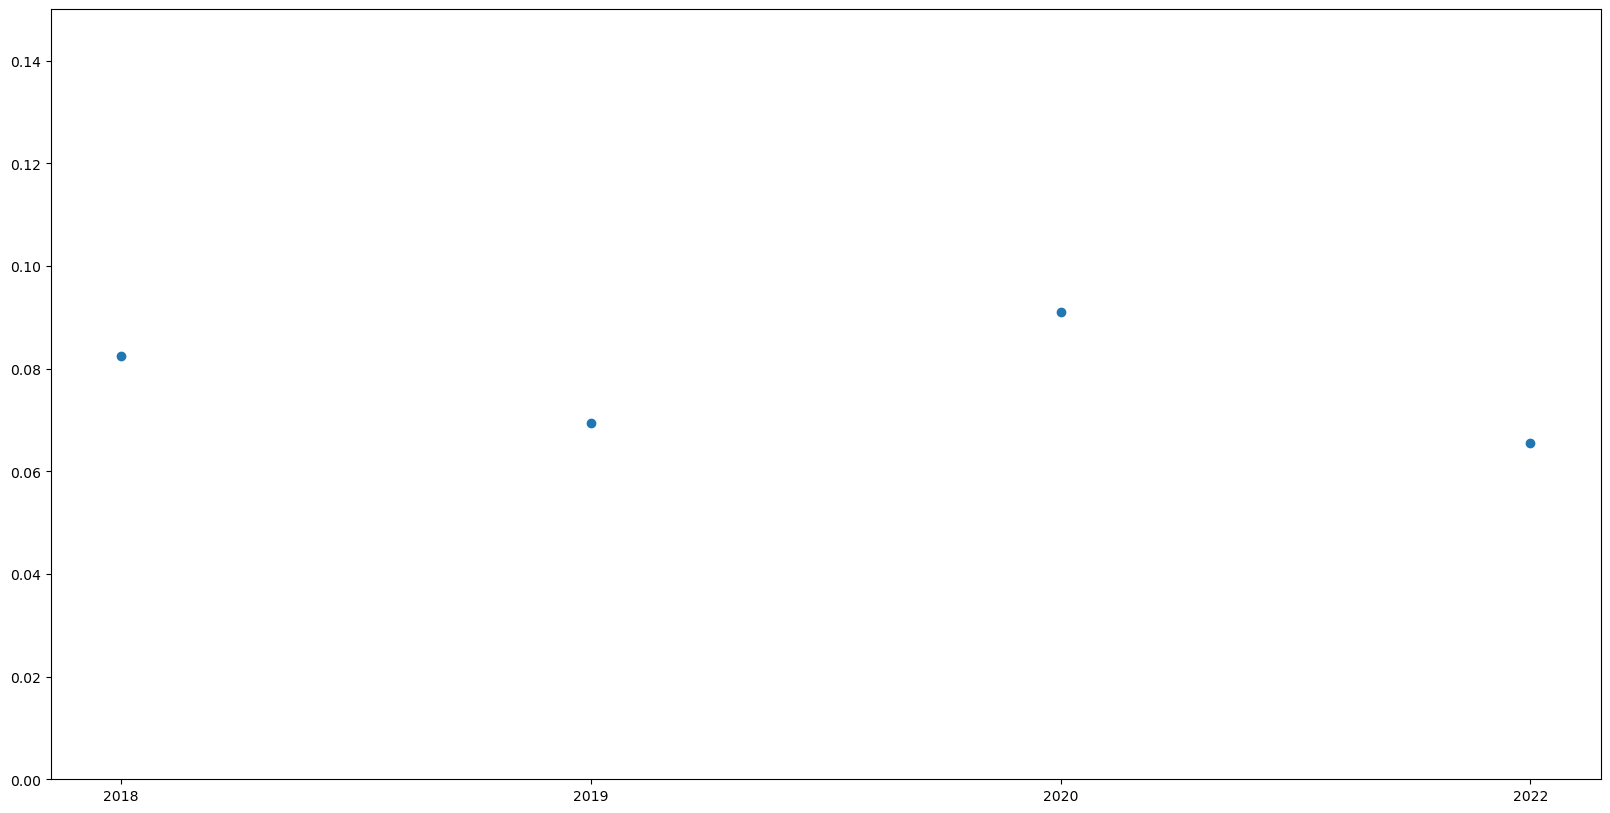

In [152]:
plt.plot(np.array(cpdc_maxes)/np.array(syr_maxes),marker = 'o',linewidth=0)

plt.ylim([0,0.15])

plt.xticks(ticks = [0,1,2,3],labels=['2018','2019','2020','2022'])

In [157]:
syr_maxes

[35770.0, 22975.0, 19202.0, 38507.0]

([<matplotlib.axis.XTick at 0x20c4ac00f70>,
 [Text(0, 0, '2018'),
  Text(1, 0, '2019'),
  Text(2, 0, '2020'),
  Text(3, 0, '2022')])

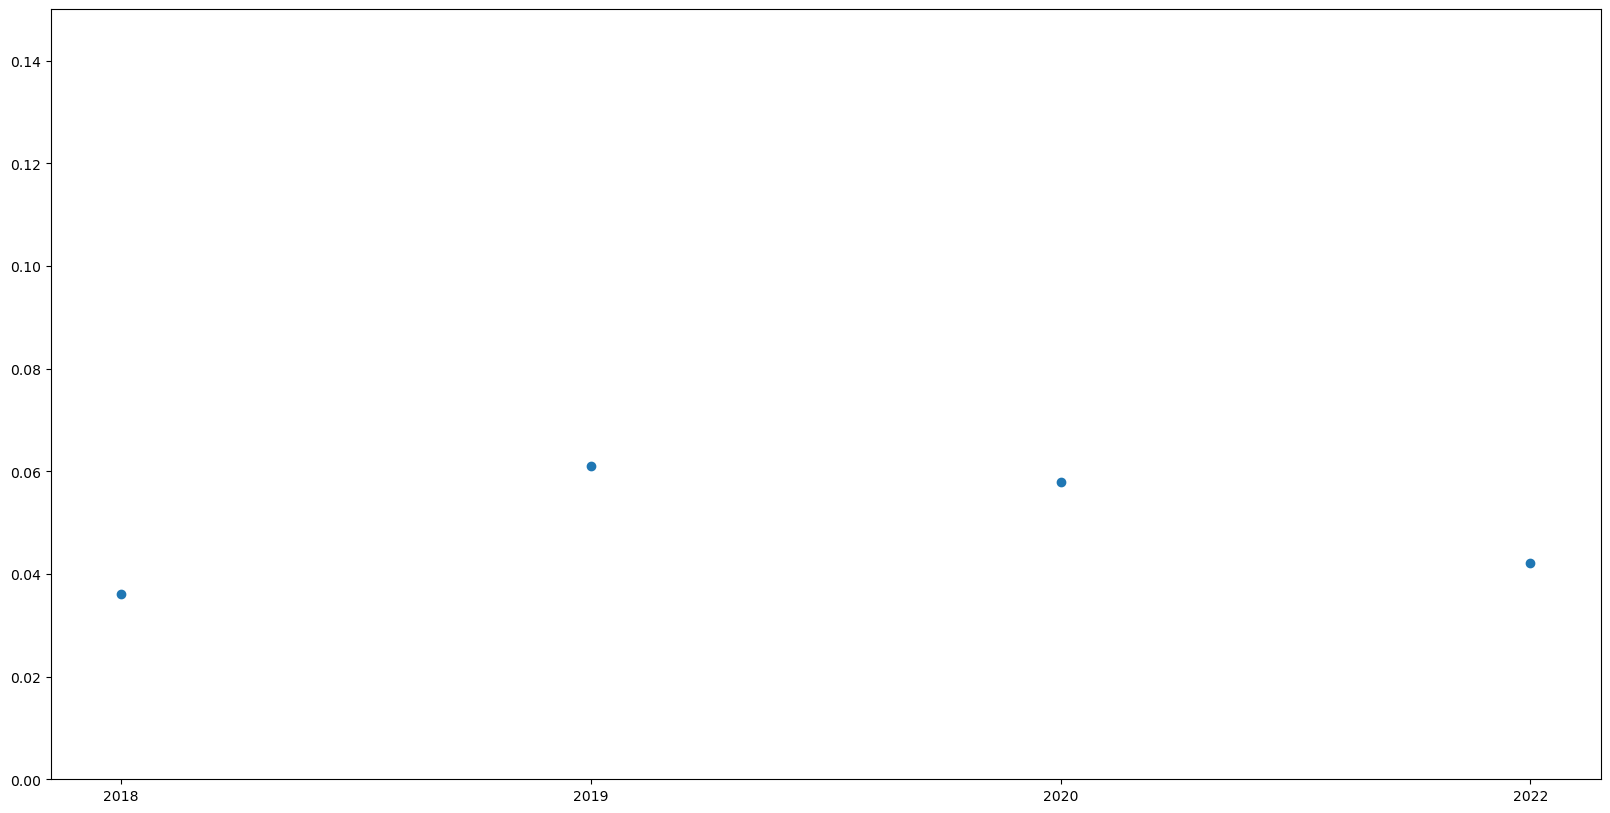

In [154]:
plt.plot(np.array(cpdc_maxes)/np.array(tab_maxes),marker = 'o',linewidth=0)

plt.ylim([0,0.15])

plt.xticks(ticks = [0,1,2,3],labels=['2018','2019','2020','2022'])

Comparing

In [81]:
flu_net.columns

Index(['WHOREGION', 'FLUSEASON', 'HEMISPHERE', 'ITZ', 'COUNTRY_CODE',
       'COUNTRY_AREA_TERRITORY', 'ISO_WEEKSTARTDATE', 'ISO_YEAR', 'ISO_WEEK',
       'MMWR_WEEKSTARTDATE', 'MMWR_YEAR', 'MMWR_WEEK', 'ORIGIN_SOURCE',
       'SPEC_PROCESSED_NB', 'SPEC_RECEIVED_NB', 'AH1N12009', 'AH1', 'AH3',
       'AH5', 'AH7N9', 'ANOTSUBTYPED', 'ANOTSUBTYPABLE', 'AOTHER_SUBTYPE',
       'AOTHER_SUBTYPE_DETAILS', 'INF_A', 'BVIC_2DEL', 'BVIC_3DEL',
       'BVIC_NODEL', 'BVIC_DELUNK', 'BYAM', 'BNOTDETERMINED', 'INF_B',
       'INF_ALL', 'INF_NEGATIVE', 'ILI_ACTIVITY', 'ADENO', 'BOCA',
       'HUMAN_CORONA', 'METAPNEUMO', 'PARAINFLUENZA', 'RHINO', 'RSV',
       'OTHERRESPVIRUS', 'OTHER_RESPVIRUS_DETAILS', 'LAB_RESULT_COMMENT',
       'WCR_COMMENT', 'ISO2', 'ISOYW', 'MMWRYW'],
      dtype='object')

In [88]:
def join_countries_more(country_list,col):

    
    c = 0
    country_codes = country_list
    for country in country_codes:
        tmp = flu_net[flu_net.COUNTRY_CODE == country][["MMWRYW",col]]
        tmp = tmp.groupby("MMWRYW").sum() #.set_index("MMWRYW")
        tmp = pd_to_weektime(tmp)
        tmp.columns = [col+'_'+country]
        if c == 0:
            df = tmp
            c+=1
        else:
            df = df.join(tmp,on=df.index)

    return df

In [91]:
join_countries_more(['USA'],'RSV').sum()

RSV_USA    0.0
dtype: float64

In [93]:
flu_id.columns

Index(['WHOREGION', 'FLUSEASON', 'HEMISPHERE', 'ITZ', 'COUNTRY_CODE',
       'COUNTRY_AREA_TERRITORY', 'ISO_WEEKSTARTDATE', 'ISO_YEAR', 'ISO_WEEK',
       'MMWR_WEEKSTARTDATE', 'MMWR_YEAR', 'MMWR_WEEK', 'ORIGIN_SOURCE',
       'AGEGROUP_CODE', 'ILI_CASES', 'ILI_OUTPATIENTS', 'ILI_POP_COV',
       'SARI_CASES', 'SARI_INPATIENTS', 'SARI_POP_COV', 'SARI_DEATHS',
       'ARI_CASES', 'ARI_OUTPATIENTS', 'ARI_POP_COV', 'PNEU_CASES',
       'PNEU_INPATIENTS', 'PNEU_POP_COV', 'GEOSPREAD', 'IMPACT', 'INTENSITY',
       'TREND', 'GEOSPREAD_COMMENTS', 'ILI_NB_SITES', 'SARI_NB_SITES',
       'ARI_NB_SITES', 'PNEU_NB_SITES', 'COMMENTS', 'ISO2', 'ISOYW', 'MMWRYW'],
      dtype='object')